In [ ]:
!unzip nfl-big-data-bowl-2026-prediction.zip

Archive:  nfl-big-data-bowl-2026-prediction.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: test_input.csv          
  inflating: train/input_2023_w01.csv  
  inflating: train/input_2023_w02.csv  
  inflating: train/input_2023_w03.csv  
  inflating: train/input_2023_w04.csv  
  inflating: train/input_2023_w05.csv  
  inflating: train/input_2023_w06.csv  
  inflating: train/input_2023_w07.csv  
  inflating: train/input_2023_w08.csv  
  inflating: train/input_2023_w09.csv  
  inflating: train/input_2023_w10.csv  
  inflating: train/input_2023_w11.csv  
  inflating: train/input_2023_w12.csv  
  inflating: train/input_2023_w13.csv  
  inflating: train/input_2023_w14.csv  
  inflating: train/input_2023_w15.csv  
  inflating: train/input_2023_w16.csv  
  inflating: train/input_2023_w17.csv  
  inflating: train/input_2023_w18.csv  
  inflating: train/output_2023_w01.csv  
  inflating: train/output_2023_w02.csv  
  inflating: train/output_2023_w03.c

In [ ]:
"""
NFL Big Data Bowl 2026 - Official API Inference Script
推理脚本
"""

import os
import numpy as np
import pandas as pd
import polars as pl
import torch
import torch.nn as nn
from pathlib import Path

import kaggle_evaluation.nfl_inference_server

# ============================================================
# 配置 - 与训练脚本保持一致
# ============================================================
class Config:
    # Kaggle路径
    MODEL_PATH = "/kaggle/input/baseline2/gru2_mha4_best.pt"  # 修改为你的模型路径

    # 模型参数 - 与训练脚本的HyperParams保持一致
    WINDOW_SIZE = 10
    MODEL_DIM = 192  # 原来是D_MODEL，改为MODEL_DIM以保持一致
    NUM_GRU_LAYERS = 2  # 新增，与训练脚本一致
    NUM_ATTENTION_HEADS = 4  # 新增，与训练脚本一致
    BATCH_SIZE = 128

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# 特征工程
# ============================================================
def add_basic_features(df: pd.DataFrame) -> pd.DataFrame:
    """添加基础特征（与训练时完全一致）"""
    df = df.copy()

    # 角色编码
    df['is_offense'] = (df['player_side'] == 'Offense').astype(np.int8)
    df['is_defense'] = (df['player_side'] == 'Defense').astype(np.int8)
    df['is_receiver'] = (df['player_role'] == 'Targeted Receiver').astype(np.int8)
    df['is_coverage'] = (df['player_role'] == 'Defensive Coverage').astype(np.int8)
    df['is_passer'] = (df['player_role'] == 'Passer').astype(np.int8)

    # 身高转换
    def height_to_feet(h):
        try:
            feet, inches = map(int, str(h).split('-'))
            return feet + inches / 12.0
        except:
            return 6.0
    df['height_feet'] = df['player_height'].apply(height_to_feet)

    # 体重填充
    df['weight'] = df['player_weight'].fillna(200.0)

    return df

# ============================================================
# 模型定义 - 与训练脚本完全一致
# ============================================================
class GRU2_MHA4(nn.Module):
    """GRU + Multi-head Attention model - 与训练脚本一致"""
    def __init__(self, input_dim: int, d_model: int, num_gru_layers: int, num_heads: int):
        super().__init__()
        self.proj = nn.Linear(input_dim, d_model)
        self.gru = nn.GRU(d_model, d_model, num_layers=num_gru_layers, batch_first=True)
        self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, batch_first=True)
        self.ln = nn.LayerNorm(d_model)
        self.dec = nn.GRU(d_model, d_model, num_layers=1, batch_first=True)
        self.out = nn.Linear(d_model, 2)

    def forward(self, X: torch.Tensor, H: int) -> torch.Tensor:
        h, _ = self.gru(self.proj(X))
        last = h[:, -1:, :]
        ctx, _ = self.mha(last, h, h)
        z = self.ln(last + ctx)
        dec_in = z.repeat(1, H, 1)
        y, _ = self.dec(dec_in)
        return self.out(y)

# ============================================================
# 预测器类
# ============================================================
class NFLPredictor:
    def __init__(self):
        self.model = None
        self.feature_cols = None
        self.initialized = False
        self.device = Config.DEVICE

        # 特征列表（必须与训练时一致）
        self.feature_cols = [
            'x', 'y', 's', 'a', 'o', 'dir',
            'absolute_yardline_number',
            'num_frames_output',
            'ball_land_x', 'ball_land_y',
            'is_offense', 'is_defense', 'is_receiver', 'is_coverage', 'is_passer',
            'height_feet', 'weight'
        ]

    def initialize(self):
        """初始化模型（只执行一次）"""
        if self.initialized:
            return

        print("="*60)
        print("Initializing NFL Predictor...")
        print("="*60)
        print(f"Device: {self.device}")
        print(f"Model path: {Config.MODEL_PATH}")
        print(f"Model Config:")
        print(f"  - Window Size: {Config.WINDOW_SIZE}")
        print(f"  - Model Dimension: {Config.MODEL_DIM}")
        print(f"  - GRU Layers: {Config.NUM_GRU_LAYERS}")
        print(f"  - Attention Heads: {Config.NUM_ATTENTION_HEADS}")

        # 加载模型 - 使用与训练脚本一致的参数
        self.model = GRU2_MHA4(
            input_dim=len(self.feature_cols),
            d_model=Config.MODEL_DIM,
            num_gru_layers=Config.NUM_GRU_LAYERS,
            num_heads=Config.NUM_ATTENTION_HEADS
        ).to(self.device)

        try:
            self.model.load_state_dict(
                torch.load(Config.MODEL_PATH, map_location=self.device)
            )
            self.model.eval()
            print("✅ Model loaded successfully!")
        except Exception as e:
            print(f"❌ Failed to load model: {e}")
            raise

        self.initialized = True
        print("="*60)

    def build_sequences(self, test_df: pd.DataFrame, test_input_df: pd.DataFrame):
        """
        构建测试序列

        返回:
            sequences: 序列数据
            last_xy: 最后一帧坐标
            player_to_seq_idx: 球员到序列索引的映射
            player_frame_mapping: 球员frame_id到时间步的映射
        """
        # 添加特征
        test_input_df = add_basic_features(test_input_df)

        # 排序和分组
        test_input_df = test_input_df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
        grouped_input = test_input_df.groupby(['game_id', 'play_id', 'nfl_id'])

        # 过滤特征列
        available_features = [c for c in self.feature_cols if c in test_input_df.columns]

        sequences = []
        last_xy = []
        player_to_seq_idx = {}

        # 获取唯一球员
        players_to_predict = test_df[['game_id', 'play_id', 'nfl_id']].drop_duplicates()

        for seq_idx, (_, row) in enumerate(players_to_predict.iterrows()):
            player_key = (row['game_id'], row['play_id'], row['nfl_id'])
            player_to_seq_idx[player_key] = seq_idx

            try:
                player_input = grouped_input.get_group(player_key).sort_values('frame_id')

                # 提取窗口
                input_window = player_input[available_features].tail(Config.WINDOW_SIZE).values

                # Padding
                if len(input_window) < Config.WINDOW_SIZE:
                    pad_len = Config.WINDOW_SIZE - len(input_window)
                    padding = np.zeros((pad_len, len(available_features)))
                    input_window = np.vstack([padding, input_window])

                # 处理NaN
                input_window = np.nan_to_num(input_window, nan=0.0)

                # 最后一帧坐标
                last_frame = player_input.iloc[-1]
                last_x = float(last_frame['x'])
                last_y = float(last_frame['y'])

                sequences.append(input_window.astype(np.float32))
                last_xy.append((last_x, last_y))

            except KeyError:
                # 没有历史数据 - 使用默认值
                default_seq = np.zeros((Config.WINDOW_SIZE, len(available_features)), dtype=np.float32)
                sequences.append(default_seq)
                last_xy.append((60.0, 26.65))  # 场地中心

        # 建立frame_id到时间步的映射
        player_frame_mapping = {}
        for _, row in test_df.iterrows():
            key = (row['game_id'], row['play_id'], row['nfl_id'])
            if key not in player_frame_mapping:
                # 获取该球员的所有frame_id并排序
                player_frames = test_df[
                    (test_df['game_id'] == key[0]) &
                    (test_df['play_id'] == key[1]) &
                    (test_df['nfl_id'] == key[2])
                ].sort_values('frame_id')['frame_id'].values
                player_frame_mapping[key] = {fid: t for t, fid in enumerate(player_frames)}

        return sequences, last_xy, player_to_seq_idx, player_frame_mapping

    def predict_batch(self, test: pl.DataFrame, test_input: pl.DataFrame) -> pl.DataFrame:
        """
        官方API预测函数

        参数:
            test: polars.DataFrame - 包含 id, game_id, play_id, nfl_id, frame_id
            test_input: polars.DataFrame - 包含历史轨迹数据

        返回:
            polars.DataFrame - 只包含 x, y 两列（无id列）
        """
        # 第一次调用时初始化模型
        if not self.initialized:
            self.initialize()

        # 转换为pandas
        test_pd = test.to_pandas()
        test_input_pd = test_input.to_pandas()

        # 构建序列
        sequences, last_xy, player_to_seq_idx, player_frame_mapping = \
            self.build_sequences(test_pd, test_input_pd)

        # 批量预测
        X_tensor = torch.tensor(np.stack(sequences), dtype=torch.float32).to(self.device)

        with torch.no_grad():
            # 最大可能的输出长度是94帧
            pred = self.model(X_tensor, H=94).cpu().numpy()  # (N_players, 94, 2)

        # 构建预测结果（按test_pd的顺序）
        results_x = []
        results_y = []

        for _, row in test_pd.iterrows():
            game_id = row['game_id']
            play_id = row['play_id']
            nfl_id = row['nfl_id']
            frame_id = row['frame_id']

            player_key = (game_id, play_id, nfl_id)

            # 查找序列索引
            if player_key not in player_to_seq_idx:
                # 没有找到球员，使用默认位置
                results_x.append(60.0)
                results_y.append(26.65)
                continue

            seq_idx = player_to_seq_idx[player_key]

            # 获取时间步
            time_step = player_frame_mapping[player_key].get(frame_id, 0)
            time_step = min(time_step, 93)  # 确保不越界

            # 获取预测
            base_x, base_y = last_xy[seq_idx]
            dx = float(pred[seq_idx, time_step, 0])
            dy = float(pred[seq_idx, time_step, 1])

            pred_x = base_x + dx
            pred_y = base_y + dy

            # 裁剪到场地范围
            pred_x = np.clip(pred_x, 0.0, 120.0)
            pred_y = np.clip(pred_y, 0.0, 53.3)

            results_x.append(pred_x)
            results_y.append(pred_y)

        # 返回Polars DataFrame（只包含x, y，不包含id）
        predictions = pl.DataFrame({
            'x': results_x,
            'y': results_y
        })

        assert len(predictions) == len(test), f"预测数量不匹配: {len(predictions)} vs {len(test)}"

        return predictions

# ============================================================
# 全局预测器实例
# ============================================================
predictor = NFLPredictor()

def predict(test: pl.DataFrame, test_input: pl.DataFrame) -> pl.DataFrame:
    """
    官方API要求的预测函数

    参数:
        test: polars.DataFrame - 当前批次需要预测的数据
        test_input: polars.DataFrame - 历史输入数据

    返回:
        polars.DataFrame - 只包含 x, y 两列
    """
    return predictor.predict_batch(test, test_input)

# ============================================================
# 主程序
# ============================================================
inference_server = kaggle_evaluation.nfl_inference_server.NFLInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    # ========== 竞赛模式 ==========
    print("="*60)
    print("NFL Big Data Bowl 2026 - Competition Mode")
    print("="*60)
    inference_server.serve()

else:
    # ========== 本地测试模式 ==========
    print("="*60)
    print("NFL Big Data Bowl 2026 - Local Test Mode")
    print("="*60)
    inference_server.run_local_gateway(
        ('/kaggle/input/nfl-big-data-bowl-2026-prediction/',)
    )
============================================================
NFL Big Data Bowl 2026 - Local Test Mode
============================================================
============================================================
Initializing NFL Predictor...
============================================================
Device: cuda
Model path: /kaggle/input/baseline2/gru2_mha4_best.pt
Model Config:
  - Window Size: 10
  - Model Dimension: 192
  - GRU Layers: 2
  - Attention Heads: 4
✅ Model loaded successfully!
============================================================

空间+gru版本多球员序列基线

Using ROOT_DIR = /content
Loaded: 4,880,579 input, 562,936 output

过滤异常play...
  - 已删除 game_id=2023091100, play_id=3167
  - Input: 4,880,579 → 4,880,241 (删除 338 行)
  - Output: 562,936 → 562,184 (删除 752 行)
可用球员数: 46,037

准备特征化数据...

构建多球员时序序列（窗口大小=10）
建立索引...
构建序列...


  0%|          | 0/46037 [00:00<?, ?it/s]

✓ 创建 46,037 个多球员序列
平均球员数: 12.3

划分训练集和验证集...
原始训练样本数: 36872, 验证样本数: 9165

对训练集进行镜像数据增强...

构建多球员时序序列（窗口大小=10）
建立索引...
构建序列...


  0%|          | 0/36872 [00:00<?, ?it/s]

✓ 创建 36,872 个多球员序列
平均球员数: 12.3
增强后训练样本数: 73744 (原始 36872 + 镜像 36872)
验证集样本数: 9165
Train/Val sizes: 73744 / 9165
Device: cuda
Total parameters: 1,454,210
Trainable parameters: 1,454,210
[1/100] train 0.4987 | val 0.3055 | lr 3.33e-05
✓ Saved: ./models/stencoder_gru_masked_anomaly_removed.pt
[2/100] train 0.2742 | val 0.2043 | lr 6.67e-05
✓ Saved: ./models/stencoder_gru_masked_anomaly_removed.pt
[3/100] train 0.1982 | val 0.1557 | lr 1.00e-04
✓ Saved: ./models/stencoder_gru_masked_anomaly_removed.pt
[4/100] train 0.1548 | val 0.1219 | lr 1.33e-04
✓ Saved: ./models/stencoder_gru_masked_anomaly_removed.pt
[5/100] train 0.1303 | val 0.0863 | lr 1.67e-04
✓ Saved: ./models/stencoder_gru_masked_anomaly_removed.pt
[6/100] train 0.1176 | val 0.0850 | lr 2.00e-04
✓ Saved: ./models/stencoder_gru_masked_anomaly_removed.pt


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[7/100] train 0.1081 | val 0.0703 | lr 2.00e-04
✓ Saved: ./models/stencoder_gru_masked_anomaly_removed.pt
[8/100] train 0.1010 | val 0.0650 | lr 2.00e-04
✓ Saved: ./models/stencoder_gru_masked_anomaly_removed.pt
[9/100] train 0.0943 | val 0.0629 | lr 2.00e-04
✓ Saved: ./models/stencoder_gru_masked_anomaly_removed.pt
[10/100] train 0.0905 | val 0.0681 | lr 2.00e-04
[11/100] train 0.0878 | val 0.0574 | lr 1.99e-04
✓ Saved: ./models/stencoder_gru_masked_anomaly_removed.pt
[12/100] train 0.0850 | val 0.0596 | lr 1.99e-04
[13/100] train 0.0829 | val 0.0569 | lr 1.98e-04
✓ Saved: ./models/stencoder_gru_masked_anomaly_removed.pt
[14/100] train 0.0801 | val 0.0511 | lr 1.97e-04
✓ Saved: ./models/stencoder_gru_masked_anomaly_removed.pt
[15/100] train 0.0786 | val 0.0606 | lr 1.96e-04
[16/100] train 0.0770 | val 0.0513 | lr 1.96e-04
[17/100] train 0.0754 | val 0.0509 | lr 1.94e-04
✓ Saved: ./models/stencoder_gru_masked_anomaly_removed.pt
[18/100] train 0.0747 | val 0.0508 | lr 1.93e-04
✓ Saved: 

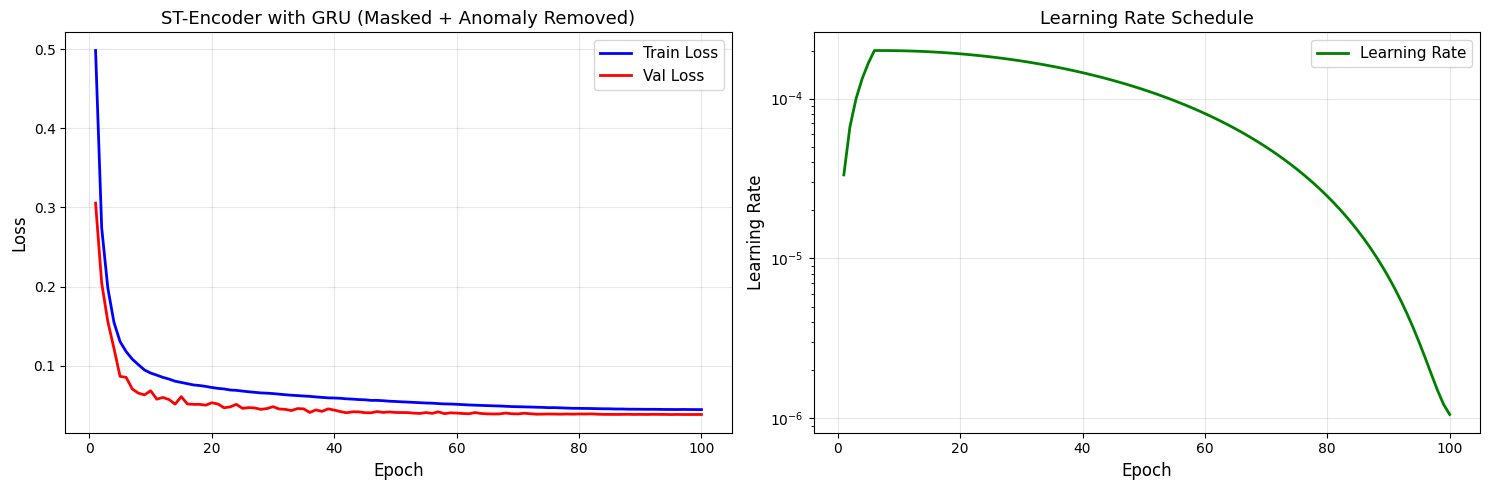


训练完成！
最佳验证损失: 0.037985 (epoch 95)

开始评估验证集...


Inference:   0%|          | 0/72 [00:00<?, ?it/s]

Building solution:   0%|          | 0/9165 [00:00<?, ?it/s]


Validation RMSE: 0.594703
✓ Saved: ./subs/val_pred_stencoder_gru_masked_anomaly_removed.csv

ST-Encoder with GRU Summary (With Attention Mask + Anomaly Removed):
Architecture:
  1. Projection: [B, T, N, F] → [B, T, N, D]
  2. 2x ST-Encoder Layers:
     - Spatial Self-Attention with Mask (球员交互)
     - Temporal GRU + Independent Dropout (时序建模)
  3. Target Extraction: [B, D] from [B, T, N, D]
  4. Horizon Embedding + MLP Head: [B, H, 2]

Model Parameters: 1,454,210
Validation RMSE: 0.594703
Anomaly Plays Removed: 1

⚡ 改进：
  - Attention Mask避免padding稀释真实球员交互
  - 删除异常play提升CV稳定性


In [ ]:
# =========================================================
# NFL Big Data Bowl 2026 — ST-Encoder with GRU (Fixed Dropout + Attention Mask)
#
# 加入少量捕捉"急停"、"转向"、"变速"等高阶运动模式会有提升（二阶存在大量噪音不要用太多不然会loss低rmse高）
#
# cv = 0.587 ,lb =0.584
# =========================================================

import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# =========================================================
# HYPERPARAMETER CONFIGURATION
# =========================================================
class HyperParams:
    """Centralized hyperparameter configuration"""
    RANDOM_SEED = 42
    TRAIN_SPLIT = 0.8
    WINDOW_SIZE = 10
    MODEL_DIM = 192
    NUM_ST_LAYERS = 2
    NUM_ATTENTION_HEADS = 4
    BATCH_SIZE = 128
    NUM_EPOCHS = 100
    LEARNING_RATE = 1.5e-4
    WEIGHT_DECAY = 1e-4
    GRADIENT_CLIP = 1.0
    WARMUP_EPOCHS = 6
    LR_MIN = 1e-6
    HUBER_DELTA = 0.5
    TIME_DECAY = 0.03

hp = HyperParams()
FIELD_WIDTH = 53.3

# Set random seeds
np.random.seed(hp.RANDOM_SEED)
torch.manual_seed(hp.RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(hp.RANDOM_SEED)
    torch.cuda.manual_seed_all(hp.RANDOM_SEED)

# -------------------- 根路径自适配 --------------------
CANDIDATES = ["/content", "/kaggle/input/nfl-big-data-bowl-2026-prediction"]
ROOT_DIR = None
for c in CANDIDATES:
    if os.path.exists(os.path.join(c, "train")):
        ROOT_DIR = c
        break
if ROOT_DIR is None:
    raise FileNotFoundError("未找到数据目录")

print("Using ROOT_DIR =", ROOT_DIR)

# =========================================================
# 1) 数据加载
# =========================================================
input_dfs = []
output_dfs = []

for week in range(1, 19):
    df_in = pd.read_csv(f'{ROOT_DIR}/train/input_2023_w{week:02}.csv')
    df_out = pd.read_csv(f'{ROOT_DIR}/train/output_2023_w{week:02}.csv')
    df_in['week'] = week
    df_out['week'] = week
    input_dfs.append(df_in)
    output_dfs.append(df_out)

train_input = pd.concat(input_dfs, ignore_index=True)
train_output = pd.concat(output_dfs, ignore_index=True)

print(f"Loaded: {len(train_input):,} input, {len(train_output):,} output")

# =========================================================
# 删除异常play - 根据论坛讨论
# =========================================================
print("\n过滤异常play...")
anomaly_plays = [
    (2023091100, 3167),  # num_frames_output=94，实际只有1-2秒有效
]

before_input = len(train_input)
before_output = len(train_output)

for game_id, play_id in anomaly_plays:
    train_input = train_input[~((train_input['game_id'] == game_id) & (train_input['play_id'] == play_id))]
    train_output = train_output[~((train_output['game_id'] == game_id) & (train_output['play_id'] == play_id))]
    print(f"  - 已删除 game_id={game_id}, play_id={play_id}")

after_input = len(train_input)
after_output = len(train_output)

print(f"  - Input: {before_input:,} → {after_input:,} (删除 {before_input - after_input:,} 行)")
print(f"  - Output: {before_output:,} → {after_output:,} (删除 {before_output - after_output:,} 行)")

# 筛选需要预测的球员
players_to_predict = pd.merge(
    train_input[train_input['player_to_predict'] == True][['game_id', 'play_id', 'nfl_id']].drop_duplicates(),
    train_output[['game_id', 'play_id', 'nfl_id']].drop_duplicates(),
    on=['game_id', 'play_id', 'nfl_id'],
    how='inner'
)

print(f"可用球员数: {len(players_to_predict):,}")

# =========================================================
# 2) 特征工程
# =========================================================
def add_basic_features(df):
    """添加基础特征 + 角度周期性处理 + 速度加速度分量"""
    df = df.copy()
    df['is_offense'] = (df['player_side'] == 'Offense').astype(np.int8)
    df['is_defense'] = (df['player_side'] == 'Defense').astype(np.int8)
    df['is_receiver'] = (df['player_role'] == 'Targeted Receiver').astype(np.int8)
    df['is_coverage'] = (df['player_role'] == 'Defensive Coverage').astype(np.int8)
    df['is_passer'] = (df['player_role'] == 'Passer').astype(np.int8)

    def height_to_feet(h):
        try:
            feet, inches = map(int, str(h).split('-'))
            return feet + inches / 12.0
        except:
            return 6.0
    df['height_feet'] = df['player_height'].apply(height_to_feet)
    df['weight'] = df['player_weight'].fillna(200.0)

    df['o_sin'] = np.sin(np.radians(df['o']))
    df['o_cos'] = np.cos(np.radians(df['o']))
    df['dir_sin'] = np.sin(np.radians(df['dir']))
    df['dir_cos'] = np.cos(np.radians(df['dir']))

    dir_rad = np.radians(df['dir'].astype(float).fillna(0.0))
    df['velocity_x'] = df['s'] * np.sin(dir_rad)
    df['velocity_y'] = df['s'] * np.cos(dir_rad)
    df['acceleration_x'] = df['a'] * np.sin(dir_rad)
    df['acceleration_y'] = df['a'] * np.cos(dir_rad)

    return df

# =========================================================
# 水平镜像函数
# =========================================================
def horizontal_mirror_df(df, field_width=FIELD_WIDTH):
    """水平镜像数据增强"""
    df = df.copy()
    if 'y' in df.columns:
        df['y'] = field_width - df['y']
    if 'velocity_y' in df.columns:
        df['velocity_y'] = -df['velocity_y']
    if 'acceleration_y' in df.columns:
        df['acceleration_y'] = -df['acceleration_y']
    if 'dir_cos' in df.columns:
        df['dir_cos'] = -df['dir_cos']
    if 'o_cos' in df.columns:
        df['o_cos'] = -df['o_cos']
    if 'ball_land_y' in df.columns:
        df['ball_land_y'] = field_width - df['ball_land_y']
    return df

# =========================================================
# 3) 多球员序列构建（加速版）
# =========================================================
def build_sequences_multi_player(input_df, output_df, players_to_predict, window_size=10, already_featurized=False):
    """构建多球员时序序列 [T, N_players, F] - 加速版"""
    print(f"\n构建多球员时序序列（窗口大小={window_size}）")

    if not already_featurized:
        input_df = add_basic_features(input_df)

    feature_cols = [
        'x', 'y', 's', 'a',
        'o_sin', 'o_cos', 'dir_sin', 'dir_cos',
        'velocity_x', 'velocity_y', 'acceleration_x', 'acceleration_y',
        'absolute_yardline_number', 'num_frames_output',
        'ball_land_x', 'ball_land_y',
        'is_offense', 'is_defense', 'is_receiver', 'is_coverage', 'is_passer',
        'height_feet', 'weight'
    ]
    feature_cols = [c for c in feature_cols if c in input_df.columns]
    n_features = len(feature_cols)

    # 排序
    input_df = input_df.sort_values(['game_id', 'play_id', 'frame_id', 'nfl_id'])

    # 预先建立索引
    print("建立索引...")
    output_grouped = output_df.groupby(['game_id', 'play_id', 'nfl_id'])

    # 为每个play获取所有球员的最后frame_id
    target_last_frames = input_df[input_df['player_to_predict'] == True].groupby(
        ['game_id', 'play_id', 'nfl_id']
    )['frame_id'].max().reset_index()
    target_last_frames.columns = ['game_id', 'play_id', 'nfl_id', 'last_frame_id']

    # 合并到players_to_predict
    players_with_frame = pd.merge(players_to_predict, target_last_frames, on=['game_id', 'play_id', 'nfl_id'])

    # 按play分组input_df
    play_grouped = {k: v for k, v in input_df.groupby(['game_id', 'play_id'])}

    sequences = []
    targets_dx = []
    targets_dy = []
    targets_frame_ids = []
    target_player_indices = []
    metadata = []

    print("构建序列...")
    for _, row in tqdm(players_with_frame.iterrows(), total=len(players_with_frame)):
        game_id = row['game_id']
        play_id = row['play_id']
        target_nfl_id = row['nfl_id']
        last_frame_id = row['last_frame_id']

        play_key = (game_id, play_id)
        target_key = (game_id, play_id, target_nfl_id)

        # 获取play数据
        if play_key not in play_grouped:
            continue
        play_data = play_grouped[play_key]

        # 获取目标球员output
        try:
            target_output = output_grouped.get_group(target_key).sort_values('frame_id')
        except KeyError:
            continue

        # 计算frame范围
        start_frame_id = last_frame_id - window_size + 1

        # 筛选窗口数据
        window_data = play_data[
            (play_data['frame_id'] >= start_frame_id) &
            (play_data['frame_id'] <= last_frame_id)
        ]

        if len(window_data) == 0:
            continue

        # 获取所有球员ID（固定顺序）
        all_players = sorted(window_data['nfl_id'].unique())
        n_players = len(all_players)

        # 找到目标球员索引
        try:
            target_idx = all_players.index(target_nfl_id)
        except ValueError:
            continue

        # 构造 [T, N_players, F] 张量 - 向量化操作
        seq_tensor = np.zeros((window_size, n_players, n_features), dtype=np.float32)

        # 创建player_id到索引的映射
        player_to_idx = {pid: idx for idx, pid in enumerate(all_players)}

        # 按frame分组并填充
        for t, frame_id in enumerate(range(start_frame_id, last_frame_id + 1)):
            frame_data = window_data[window_data['frame_id'] == frame_id]
            if len(frame_data) == 0:
                continue

            # 向量化填充
            player_ids = frame_data['nfl_id'].values
            player_indices = [player_to_idx[pid] for pid in player_ids]
            seq_tensor[t, player_indices, :] = frame_data[feature_cols].values

        # 处理NaN
        seq_tensor = np.nan_to_num(seq_tensor, nan=0.0)

        # 获取目标球员最后位置
        target_last_data = window_data[
            (window_data['nfl_id'] == target_nfl_id) &
            (window_data['frame_id'] == last_frame_id)
        ]

        if len(target_last_data) == 0:
            continue

        last_x = target_last_data['x'].values[0]
        last_y = target_last_data['y'].values[0]

        # 计算相对位移
        dx = target_output['x'].values - last_x
        dy = target_output['y'].values - last_y
        frame_ids = target_output['frame_id'].values

        # 保存
        sequences.append(seq_tensor)
        targets_dx.append(dx.astype(np.float32))
        targets_dy.append(dy.astype(np.float32))
        targets_frame_ids.append(frame_ids.astype(np.int32))
        target_player_indices.append(target_idx)
        metadata.append({
            'game_id': game_id,
            'play_id': play_id,
            'nfl_id': target_nfl_id,
            'last_frame_id': int(last_frame_id),
            'n_players': n_players,
            'target_idx': target_idx
        })

    print(f"✓ 创建 {len(sequences):,} 个多球员序列")
    print(f"平均球员数: {np.mean([s.shape[1] for s in sequences]):.1f}")

    metadata_df = pd.DataFrame(metadata)
    return sequences, targets_dx, targets_dy, targets_frame_ids, target_player_indices, metadata_df, feature_cols

# =========================================================
# 准备数据
# =========================================================
print("\n准备特征化数据...")
train_input_feat = add_basic_features(train_input)

# 构建原始序列
sequences, targets_dx, targets_dy, targets_frame_ids, target_player_indices, metadata_df, feature_names = \
    build_sequences_multi_player(
        input_df=train_input_feat,
        output_df=train_output,
        players_to_predict=players_to_predict,
        window_size=hp.WINDOW_SIZE,
        already_featurized=True
    )

# =========================================================
# 数据划分
# =========================================================
print("\n划分训练集和验证集...")
keys = metadata_df[["game_id","play_id"]].apply(lambda r: (r["game_id"], r["play_id"]), axis=1).values
uniq_keys = pd.unique(keys)
np.random.seed(hp.RANDOM_SEED)
np.random.shuffle(uniq_keys)
cut = int(len(uniq_keys) * hp.TRAIN_SPLIT)
train_keys = set(uniq_keys[:cut])
val_keys = set(uniq_keys[cut:])

idx_train = [i for i, k in enumerate(keys) if k in train_keys]
idx_val = [i for i, k in enumerate(keys) if k in val_keys]

print(f"原始训练样本数: {len(idx_train)}, 验证样本数: {len(idx_val)}")

# =========================================================
# 镜像数据增强（仅训练集）
# =========================================================
print("\n对训练集进行镜像数据增强...")
train_players = metadata_df.iloc[idx_train][['game_id', 'play_id', 'nfl_id']].drop_duplicates()

mirrored_input_feat = horizontal_mirror_df(train_input_feat)
mirrored_output = horizontal_mirror_df(train_output)

sequences_m, targets_dx_m, targets_dy_m, targets_frame_ids_m, target_player_indices_m, metadata_df_m, _ = \
    build_sequences_multi_player(
        input_df=mirrored_input_feat,
        output_df=mirrored_output,
        players_to_predict=train_players,
        window_size=hp.WINDOW_SIZE,
        already_featurized=True
    )

# 合并训练集
train_sequences = [sequences[i] for i in idx_train] + sequences_m
train_targets_dx = [targets_dx[i] for i in idx_train] + targets_dx_m
train_targets_dy = [targets_dy[i] for i in idx_train] + targets_dy_m
train_targets_frame_ids = [targets_frame_ids[i] for i in idx_train] + targets_frame_ids_m
train_target_indices = [target_player_indices[i] for i in idx_train] + target_player_indices_m
train_metadata = pd.concat([metadata_df.iloc[idx_train], metadata_df_m], ignore_index=True)

# 验证集保持原样
val_sequences = [sequences[i] for i in idx_val]
val_targets_dx = [targets_dx[i] for i in idx_val]
val_targets_dy = [targets_dy[i] for i in idx_val]
val_targets_frame_ids = [targets_frame_ids[i] for i in idx_val]
val_target_indices = [target_player_indices[i] for i in idx_val]
val_metadata = metadata_df.iloc[idx_val].reset_index(drop=True)

print(f"增强后训练样本数: {len(train_sequences)} (原始 {len(idx_train)} + 镜像 {len(sequences_m)})")
print(f"验证集样本数: {len(val_sequences)}")

# =========================================================
# 4) 损失函数
# =========================================================
class TemporalHuber(nn.Module):
    def __init__(self, delta=0.5, time_decay=0.03):
        super().__init__()
        self.delta = delta
        self.time_decay = time_decay

    def forward(self, pred, target, mask):
        err = pred - target
        abs_err = torch.abs(err)
        huber = torch.where(abs_err <= self.delta,
                            0.5 * err * err,
                            self.delta * (abs_err - 0.5 * self.delta))
        if self.time_decay > 0:
            L = pred.size(1)
            t = torch.arange(L, device=pred.device).float()
            weight = torch.exp(-self.time_decay * t).view(1, L)
            huber = huber * weight
            mask = mask * weight
        return (huber * mask).sum() / (mask.sum() + 1e-8)

# =========================================================
# 5) Dataset和DataLoader
# =========================================================
class NFLMultiPlayerDataset(Dataset):
    def __init__(self, sequences, targets_dx, targets_dy, targets_frame_ids,
                 target_player_indices, metadata_df, feature_names):
        self.seq = sequences
        self.dx = targets_dx
        self.dy = targets_dy
        self.fids = targets_frame_ids
        self.target_idx = target_player_indices
        self.meta = metadata_df.reset_index(drop=True)
        self.feats = feature_names
        self.fx = self.feats.index('x')
        self.fy = self.feats.index('y')

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, i):
        X = self.seq[i]
        dx = self.dx[i]
        dy = self.dy[i]
        fids = self.fids[i]
        target_idx = self.target_idx[i]

        last_xy = X[-1, target_idx, [self.fx, self.fy]]

        row = self.meta.loc[i]
        ident = (int(row.game_id), int(row.play_id), int(row.nfl_id), int(row.last_frame_id))

        return {
            "X": torch.from_numpy(X),
            "dx": torch.from_numpy(dx),
            "dy": torch.from_numpy(dy),
            "fids": torch.from_numpy(fids),
            "target_idx": target_idx,
            "last_xy": torch.from_numpy(last_xy),
            "idmeta": ident
        }

def collate_batch_multi_player(batch):
    B = len(batch)
    max_players = max(b["X"].shape[1] for b in batch)
    max_h = max(b["dx"].shape[0] for b in batch)
    T = batch[0]["X"].shape[0]
    F = batch[0]["X"].shape[2]

    X = torch.zeros(B, T, max_players, F, dtype=torch.float32)
    dx = torch.zeros(B, max_h, dtype=torch.float32)
    dy = torch.zeros(B, max_h, dtype=torch.float32)
    mask = torch.zeros(B, max_h, dtype=torch.float32)
    fids = torch.zeros(B, max_h, dtype=torch.int64)
    target_indices = torch.zeros(B, dtype=torch.long)
    player_mask = torch.zeros(B, max_players, dtype=torch.bool)

    for i, b in enumerate(batch):
        n_players = b["X"].shape[1]
        X[i, :, :n_players, :] = b["X"]
        player_mask[i, :n_players] = True

        L = b["dx"].shape[0]
        dx[i, :L] = b["dx"]
        dy[i, :L] = b["dy"]
        mask[i, :L] = 1.0
        fids[i, :L] = b["fids"]
        target_indices[i] = b["target_idx"]

    last_xy = torch.stack([b["last_xy"] for b in batch], dim=0)
    idmeta = [b["idmeta"] for b in batch]

    return {
        "X": X,
        "dx": dx,
        "dy": dy,
        "mask": mask,
        "fids": fids,
        "target_idx": target_indices,
        "last_xy": last_xy,
        "idmeta": idmeta,
        "player_mask": player_mask
    }

train_ds = NFLMultiPlayerDataset(train_sequences, train_targets_dx, train_targets_dy,
                                  train_targets_frame_ids, train_target_indices,
                                  train_metadata, feature_names)
val_ds = NFLMultiPlayerDataset(val_sequences, val_targets_dx, val_targets_dy,
                                val_targets_frame_ids, val_target_indices,
                                val_metadata, feature_names)

train_loader = DataLoader(train_ds, batch_size=hp.BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True, collate_fn=collate_batch_multi_player)
val_loader = DataLoader(val_ds, batch_size=hp.BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True, collate_fn=collate_batch_multi_player)

print(f"Train/Val sizes: {len(train_ds)} / {len(val_ds)}")

# =========================================================
# 6) 模型定义（STEncoderLayer with GRU - Fixed Dropout + Attention Mask）
# =========================================================
class STEncoderLayer(nn.Module):
    """单层时空编码器 - 时序部分使用GRU（修正dropout + attention mask）"""
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()
        # 空间attention
        self.spatial_mha = nn.MultiheadAttention(d_model, num_heads, batch_first=True, dropout=0.2)
        self.spatial_ln = nn.LayerNorm(d_model)
        self.spatial_ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(d_model * 2, d_model)
        )
        self.spatial_ffn_ln = nn.LayerNorm(d_model)

        # 时间GRU (单层GRU + 独立dropout)
        self.temporal_gru = nn.GRU(d_model, d_model, batch_first=True)
        self.temporal_dropout = nn.Dropout(0.2)
        self.temporal_ln = nn.LayerNorm(d_model)
        self.temporal_ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(d_model * 2, d_model)
        )
        self.temporal_ffn_ln = nn.LayerNorm(d_model)

    def forward(self, X: torch.Tensor, player_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            X: [B, T, N, D]
            player_mask: [B, N] bool tensor, True表示有效球员
        Returns:
            [B, T, N, D]
        """
        B, T, N, D = X.shape
        X = X.contiguous()

        # 1. 空间 Self-Attention with mask
        X_flat = X.reshape(B * T, N, D)

        if player_mask is not None:
            # 扩展mask到每个时间步: [B, N] -> [B*T, N]
            attn_mask = player_mask.unsqueeze(1).repeat(1, T, 1)  # [B, T, N]
            attn_mask = attn_mask.reshape(B * T, N)  # [B*T, N]
            # key_padding_mask: True的位置会被忽略，所以需要取反
            ctx, _ = self.spatial_mha(X_flat, X_flat, X_flat,
                                     key_padding_mask=~attn_mask)
        else:
            ctx, _ = self.spatial_mha(X_flat, X_flat, X_flat)

        X_flat = self.spatial_ln(X_flat + ctx)
        X_flat = self.spatial_ffn_ln(X_flat + self.spatial_ffn(X_flat))
        X = X_flat.reshape(B, T, N, D)

        # 2. 时间 GRU
        X_flat = X.permute(0, 2, 1, 3).contiguous()  # [B, N, T, D]
        X_flat = X_flat.reshape(B * N, T, D)         # [B*N, T, D]

        gru_out, _ = self.temporal_gru(X_flat)       # [B*N, T, D]
        gru_out = self.temporal_dropout(gru_out)     # 应用dropout
        X_flat = self.temporal_ln(X_flat + gru_out)  # 残差连接
        X_flat = self.temporal_ffn_ln(X_flat + self.temporal_ffn(X_flat))

        X_flat = X_flat.reshape(B, N, T, D)
        X = X_flat.permute(0, 2, 1, 3).contiguous()  # [B, T, N, D]

        return X


class STEncoderMini(nn.Module):
    """
    ST-Encoder with GRU：
    - 多球员输入 [B, T, N, F]
    - 1~2 层 STEncoderLayer (空间attention + 时序GRU)
    - 无时间位置编码
    - 使用 horizon embedding + MLP 输出未来轨迹
    """
    def __init__(
        self,
        input_dim: int,
        d_model: int,
        num_st_layers: int,
        num_heads: int,
        max_horizon: int = 200
    ):
        super().__init__()
        self.d_model = d_model
        self.max_horizon = max_horizon

        # 1) 特征投影 F -> D
        self.proj = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model)
        )

        # 2) ST-Encoder 层
        self.st_layers = nn.ModuleList([
            STEncoderLayer(d_model, num_heads)
            for _ in range(num_st_layers)
        ])

        # 3) 未来 horizon 位置编码
        self.horizon_emb = nn.Embedding(max_horizon, d_model)

        # 4) MLP Head: [B,H,D] -> [B,H,2]
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(0.2),
        )
        self.out = nn.Linear(d_model, 2)

    def forward(self, X: torch.Tensor, target_idx: torch.Tensor, H: int,
                player_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Args:
            X: [B, T, N, F]
            target_idx: [B]  每个样本要预测的球员 index
            H: 当前 batch 的 horizon 长度 (max_h)
            player_mask: [B, N] bool tensor
        Returns:
            pred: [B, H, 2]，相对位移 (dx, dy)
        """
        B, T, N, F = X.shape
        X = X.contiguous()

        # Step 1: 投影
        X_proj = self.proj(X.view(B * T * N, F))       # [B*T*N, D]
        X_proj = X_proj.view(B, T, N, self.d_model)    # [B,T,N,D]

        # Step 2: ST-Encoder (空间attention + 时序GRU) with mask
        for layer in self.st_layers:
            X_proj = layer(X_proj, player_mask=player_mask)

        # Step 3: 取目标球员最后一帧 token
        batch_idx = torch.arange(B, device=X.device)
        target_token = X_proj[batch_idx, -1, target_idx, :]  # [B,D]

        # Step 4: horizon embedding + MLP Head
        if H > self.max_horizon:
            raise ValueError(f"H={H} > max_horizon={self.max_horizon}")
        h_ids = torch.arange(H, device=X.device)           # [H]
        h_emb = self.horizon_emb(h_ids)[None, :, :]        # [1,H,D]

        base = target_token.unsqueeze(1)                   # [B,1,D]
        dec_in = base + h_emb                              # [B,H,D]

        feat = self.head(dec_in)                           # [B,H,D]
        pred = self.out(feat)                              # [B,H,2]

        return pred


# =========================================================
# 7) 训练
# =========================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

model = STEncoderMini(
    input_dim=len(feature_names),
    d_model=hp.MODEL_DIM,
    num_st_layers=hp.NUM_ST_LAYERS,
    num_heads=hp.NUM_ATTENTION_HEADS,
    max_horizon=200
).to(DEVICE)

# 打印模型参数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

optimizer = torch.optim.AdamW(model.parameters(), lr=hp.LEARNING_RATE, weight_decay=hp.WEIGHT_DECAY)
criterion = TemporalHuber(delta=hp.HUBER_DELTA, time_decay=hp.TIME_DECAY)

from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR, SequentialLR

warmup_scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: (epoch + 1) / hp.WARMUP_EPOCHS)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=hp.NUM_EPOCHS - hp.WARMUP_EPOCHS, eta_min=hp.LR_MIN)
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[hp.WARMUP_EPOCHS])

best_val = float("inf")
train_losses = []
val_losses = []
learning_rates = []
epochs_list = []

def batch_loss(pred, dx, dy, mask):
    return 0.5 * (criterion(pred[..., 0], dx, mask) + criterion(pred[..., 1], dy, mask))

for ep in range(1, hp.NUM_EPOCHS + 1):
    model.train()
    tr_sum = tr_n = 0
    for b in train_loader:
        X = b["X"].to(DEVICE)
        dx = b["dx"].to(DEVICE)
        dy = b["dy"].to(DEVICE)
        m = b["mask"].to(DEVICE)
        target_idx = b["target_idx"].to(DEVICE)
        player_mask = b["player_mask"].to(DEVICE)
        H = dx.shape[1]

        optimizer.zero_grad(set_to_none=True)
        pred = model(X, target_idx, H=H, player_mask=player_mask)
        loss = batch_loss(pred, dx, dy, m)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), hp.GRADIENT_CLIP)
        optimizer.step()
        tr_sum += loss.item() * X.size(0)
        tr_n += X.size(0)

    model.eval()
    va_sum = va_n = 0
    with torch.no_grad():
        for b in val_loader:
            X = b["X"].to(DEVICE)
            dx = b["dx"].to(DEVICE)
            dy = b["dy"].to(DEVICE)
            m = b["mask"].to(DEVICE)
            target_idx = b["target_idx"].to(DEVICE)
            player_mask = b["player_mask"].to(DEVICE)
            H = dx.shape[1]
            pred = model(X, target_idx, H=H, player_mask=player_mask)
            loss = batch_loss(pred, dx, dy, m)
            va_sum += loss.item() * X.size(0)
            va_n += X.size(0)

    tr = tr_sum / tr_n
    va = va_sum / va_n
    current_lr = optimizer.param_groups[0]['lr']

    epochs_list.append(ep)
    train_losses.append(tr)
    val_losses.append(va)
    learning_rates.append(current_lr)

    print(f"[{ep}/{hp.NUM_EPOCHS}] train {tr:.4f} | val {va:.4f} | lr {current_lr:.2e}")

    if va < best_val:
        best_val = va
        os.makedirs("./models", exist_ok=True)
        torch.save(model.state_dict(), "./models/stencoder_gru_masked_anomaly_removed.pt")
        print("✓ Saved: ./models/stencoder_gru_masked_anomaly_removed.pt")

    scheduler.step()

# =========================================================
# 8) 绘制训练曲线
# =========================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(epochs_list, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_list, val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('ST-Encoder with GRU (Masked + Anomaly Removed)', fontsize=13)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_list, learning_rates, 'g-', label='Learning Rate', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Learning Rate', fontsize=12)
ax2.set_title('Learning Rate Schedule', fontsize=13)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('./training_curves_stencoder_gru_masked_anomaly_removed.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved training curves to ./training_curves_stencoder_gru_masked_anomaly_removed.png")
plt.show()

print(f"\n训练完成！")
print(f"最佳验证损失: {min(val_losses):.6f} (epoch {val_losses.index(min(val_losses))+1})")

# =========================================================
# 9) 推理和评估
# =========================================================
def infer_loader(loader, model):
    rows = []
    model.eval()
    with torch.no_grad():
        for b in tqdm(loader, desc="Inference"):
            X = b["X"].to(DEVICE)
            target_idx = b["target_idx"].to(DEVICE)
            player_mask = b["player_mask"].to(DEVICE)
            H = b["dx"].shape[1]
            pred = model(X, target_idx, H=H, player_mask=player_mask).cpu().numpy()

            mask = b["mask"].cpu().numpy()
            fids = b["fids"].cpu().numpy()
            last_xy = b["last_xy"].cpu().numpy()
            metas = b["idmeta"]

            for i in range(X.size(0)):
                g, p, n, last_f = metas[i]
                base_x, base_y = last_xy[i]
                L = int(mask[i].sum())
                for j in range(L):
                    fid = int(fids[i, j])
                    abs_x = float(base_x + pred[i, j, 0])
                    abs_y = float(base_y + pred[i, j, 1])
                    rows.append({"id": f"{g}_{p}_{n}_{fid}", "x": abs_x, "y": abs_y})
    return pd.DataFrame(rows).drop_duplicates(subset=["id"])

def build_solution_from_dataset(dataset):
    rows = []
    for idx in tqdm(range(len(dataset)), desc="Building solution"):
        dx = dataset.dx[idx]
        dy = dataset.dy[idx]
        fids = dataset.fids[idx]
        seq = dataset.seq[idx]
        target_idx = dataset.target_idx[idx]
        base_x, base_y = seq[-1, target_idx, [dataset.fx, dataset.fy]]
        g = int(dataset.meta.loc[idx, 'game_id'])
        p = int(dataset.meta.loc[idx, 'play_id'])
        n = int(dataset.meta.loc[idx, 'nfl_id'])
        for j in range(len(dx)):
            rows.append({"id": f"{g}_{p}_{n}_{int(fids[j])}", "x": float(base_x + dx[j]), "y": float(base_y + dy[j])})
    return pd.DataFrame(rows).drop_duplicates(subset=["id"])

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    submission = submission[['id', 'x', 'y']]
    merged_df = pd.merge(solution, submission, on=row_id_column_name, suffixes=('_true', '_pred'))
    rmse = np.sqrt(0.5 * (mean_squared_error(merged_df['x_true'], merged_df['x_pred']) +
                          mean_squared_error(merged_df['y_true'], merged_df['y_pred'])))
    return float(rmse)

print("\n" + "="*60)
print("开始评估验证集...")
print("="*60)
model.load_state_dict(torch.load("./models/stencoder_gru_masked_anomaly_removed.pt", map_location=DEVICE))
val_pred = infer_loader(val_loader, model)
val_sol = build_solution_from_dataset(val_ds)
rmse = score(val_sol, val_pred, row_id_column_name="id")
print(f"\nValidation RMSE: {rmse:.6f}")

os.makedirs("./subs", exist_ok=True)
val_pred[["id", "x", "y"]].to_csv("./subs/val_pred_stencoder_gru_masked_anomaly_removed.csv", index=False)
print("✓ Saved: ./subs/val_pred_stencoder_gru_masked_anomaly_removed.csv")

print("\n" + "="*60)
print("ST-Encoder with GRU Summary (With Attention Mask + Anomaly Removed):")
print("="*60)
print(f"Architecture:")
print(f"  1. Projection: [B, T, N, F] → [B, T, N, D]")
print(f"  2. {hp.NUM_ST_LAYERS}x ST-Encoder Layers:")
print(f"     - Spatial Self-Attention with Mask (球员交互)")
print(f"     - Temporal GRU + Independent Dropout (时序建模)")
print(f"  3. Target Extraction: [B, D] from [B, T, N, D]")
print(f"  4. Horizon Embedding + MLP Head: [B, H, 2]")
print(f"\nModel Parameters: {trainable_params:,}")
print(f"Validation RMSE: {rmse:.6f}")
print(f"Anomaly Plays Removed: {len(anomaly_plays)}")
print(f"\n⚡ 改进：")
print(f"  - Attention Mask避免padding稀释真实球员交互")
print(f"  - 删除异常play提升CV稳定性")
print("="*60)

单球员序列基线

Using ROOT_DIR = /content
Random Seed: 42
Train/Val Split: 80%/20%
Loaded: 4,880,579 input, 562,936 output

过滤异常play...
  - 已删除 game_id=2023091100, play_id=3167
  - Input: 4,880,579 → 4,880,241 (删除 338 行)
  - Output: 562,936 → 562,184 (删除 752 行)
可用球员数: 46,037

准备特征化数据...

构建时序序列（窗口大小=10，already_featurized=True）
使用 23 个特征 (包含角度sin/cos + 速度加速度分量)


构建序列:   0%|          | 0/46037 [00:00<?, ?it/s]

✓ 创建 46,037 个序列

划分训练集和验证集...
原始训练样本数: 36872, 验证样本数: 9165

对训练集进行镜像数据增强...

构建时序序列（窗口大小=10，already_featurized=True）
使用 23 个特征 (包含角度sin/cos + 速度加速度分量)


构建序列:   0%|          | 0/36872 [00:00<?, ?it/s]

✓ 创建 36,872 个序列
增强后训练样本数: 73744 (原始 36872 + 镜像 36872)
验证集样本数: 9165 (无增强)
Train/Val sizes: 73744 / 9165
Device: cuda
[1/100] train 0.4419 | val 0.3106 | lr 3.33e-05
Saved: ./models/gru2_mha4_mirror_best.pt
[2/100] train 0.2617 | val 0.1973 | lr 6.67e-05
Saved: ./models/gru2_mha4_mirror_best.pt
[3/100] train 0.2179 | val 0.1611 | lr 1.00e-04
Saved: ./models/gru2_mha4_mirror_best.pt
[4/100] train 0.1887 | val 0.1422 | lr 1.33e-04
Saved: ./models/gru2_mha4_mirror_best.pt
[5/100] train 0.1615 | val 0.1154 | lr 1.67e-04
Saved: ./models/gru2_mha4_mirror_best.pt
[6/100] train 0.1403 | val 0.1053 | lr 2.00e-04
Saved: ./models/gru2_mha4_mirror_best.pt


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[7/100] train 0.1220 | val 0.1149 | lr 2.00e-04
[8/100] train 0.1062 | val 0.1050 | lr 2.00e-04
Saved: ./models/gru2_mha4_mirror_best.pt
[9/100] train 0.0952 | val 0.0974 | lr 2.00e-04
Saved: ./models/gru2_mha4_mirror_best.pt
[10/100] train 0.0905 | val 0.0664 | lr 2.00e-04
Saved: ./models/gru2_mha4_mirror_best.pt
[11/100] train 0.0863 | val 0.0828 | lr 1.99e-04
[12/100] train 0.0824 | val 0.0903 | lr 1.99e-04
[13/100] train 0.0786 | val 0.0583 | lr 1.98e-04
Saved: ./models/gru2_mha4_mirror_best.pt
[14/100] train 0.0757 | val 0.0582 | lr 1.97e-04
Saved: ./models/gru2_mha4_mirror_best.pt
[15/100] train 0.0742 | val 0.0619 | lr 1.96e-04
[16/100] train 0.0732 | val 0.0671 | lr 1.96e-04
[17/100] train 0.0721 | val 0.0552 | lr 1.94e-04
Saved: ./models/gru2_mha4_mirror_best.pt
[18/100] train 0.0698 | val 0.0584 | lr 1.93e-04
[19/100] train 0.0691 | val 0.0632 | lr 1.92e-04
[20/100] train 0.0676 | val 0.0585 | lr 1.91e-04
[21/100] train 0.0675 | val 0.0517 | lr 1.89e-04
Saved: ./models/gru2_m

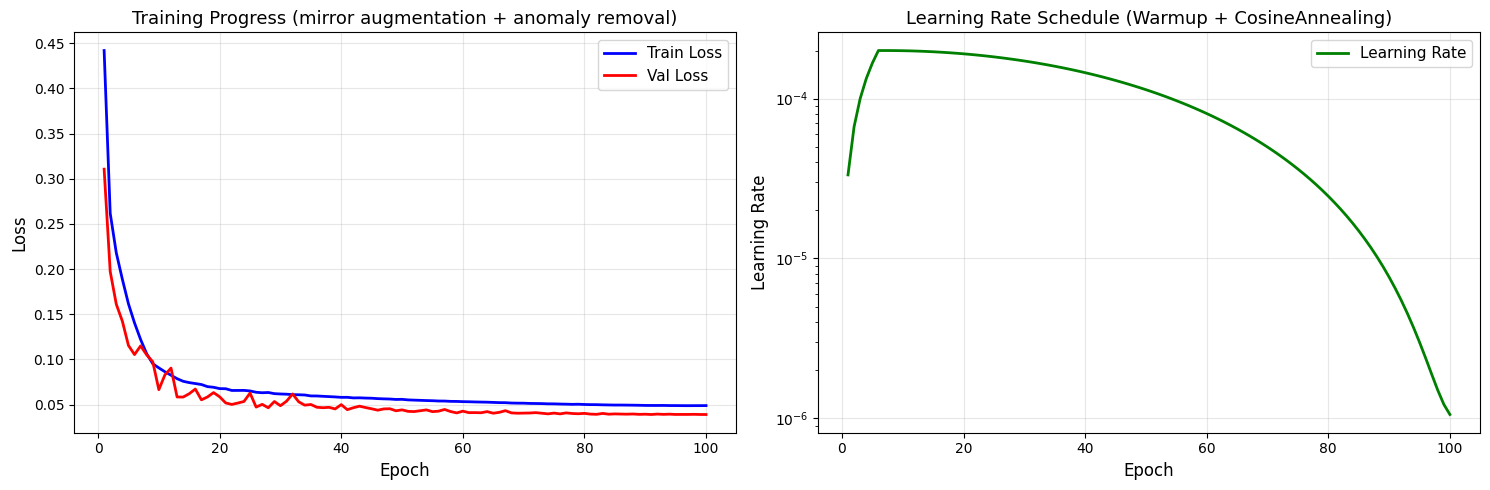


训练完成！
最佳验证损失: 0.038908 (epoch 100)
最终训练损失: 0.048797
最终验证损失: 0.038908

开始评估验证集...


Inference:   0%|          | 0/72 [00:00<?, ?it/s]

Building solution:   0%|          | 0/9165 [00:00<?, ?it/s]


Validation RMSE: 0.594228
Saved: ./subs/val_pred_mirror_anomaly_removed.csv

Hyperparameters Summary:
Random Seed: 42
Train/Val Split: 80%/20%
Window Size: 10
Model Dimension: 192
GRU Layers: 2
Attention Heads: 4
Batch Size: 128
Learning Rate: 0.0002
Weight Decay: 0.0001
Gradient Clip: 1.0
Huber Delta: 0.5
Time Decay: 0.03
Epochs: 100
Warmup Epochs: 6
LR Min: 1e-06
Total Features: 23
Data Augmentation: Horizontal Mirror (TRAIN SET ONLY)
Anomaly Plays Removed: 1

Final Results:
  - Best Val Loss: 0.038908
  - Validation RMSE: 0.594228
  - Train samples: 73744 (original + mirrored)
  - Val samples: 9165 (no augmentation)


In [ ]:
# =========================================================
# NFL Big Data Bowl 2026 — baseline with hyperparameter configuration
# cv = 594
# group 1 fold
# Warmup (6 epochs) + CosineAnnealing LR
# 加cumsum有提升但是轻微过拟合，还没应用（0.01）
# 水平镜像数据增强(0.02+) - 仅应用于训练集
# 目前多头还没有明显提升
# =========================================================
#目前任务直接把模型改造成st encoder 版本，从单球员轨迹预测改为多球员一起轨迹预测

import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# =========================================================
# HYPERPARAMETER CONFIGURATION
# =========================================================
class HyperParams:
    """Centralized hyperparameter configuration"""

    # Random seed
    RANDOM_SEED = 42

    # Data split
    TRAIN_SPLIT = 0.8  # 80% train, 20% validation

    # Model architecture
    WINDOW_SIZE = 10
    MODEL_DIM = 192
    NUM_GRU_LAYERS = 2
    NUM_ATTENTION_HEADS = 4

    # Training parameters
    BATCH_SIZE = 128
    NUM_EPOCHS = 100
    LEARNING_RATE = 2e-4
    WEIGHT_DECAY = 1e-4
    GRADIENT_CLIP = 1.0

    # Learning rate schedule
    WARMUP_EPOCHS = 6
    LR_MIN = 1e-6

    # Loss function parameters
    HUBER_DELTA = 0.5
    TIME_DECAY = 0.03

# Initialize hyperparameters
hp = HyperParams()

# Field dimensions for mirroring
FIELD_WIDTH = 53.3  # 球场宽度（y轴最大值）

# Set random seeds for reproducibility
np.random.seed(hp.RANDOM_SEED)
torch.manual_seed(hp.RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(hp.RANDOM_SEED)
    torch.cuda.manual_seed_all(hp.RANDOM_SEED)

# -------------------- 根路径自适配 --------------------
CANDIDATES = ["/content", "/kaggle/input/nfl-big-data-bowl-2026-prediction"]
ROOT_DIR = None
for c in CANDIDATES:
    if os.path.exists(os.path.join(c, "train")):
        ROOT_DIR = c
        break
if ROOT_DIR is None:
    raise FileNotFoundError("未找到数据目录")

print("Using ROOT_DIR =", ROOT_DIR)
print(f"Random Seed: {hp.RANDOM_SEED}")
print(f"Train/Val Split: {hp.TRAIN_SPLIT:.0%}/{1-hp.TRAIN_SPLIT:.0%}")

# =========================================================
# 1) 数据加载
# =========================================================
input_dfs = []
output_dfs = []

for week in range(1, 19):
    df_in = pd.read_csv(f'{ROOT_DIR}/train/input_2023_w{week:02}.csv')
    df_out = pd.read_csv(f'{ROOT_DIR}/train/output_2023_w{week:02}.csv')
    df_in['week'] = week
    df_out['week'] = week
    input_dfs.append(df_in)
    output_dfs.append(df_out)

train_input = pd.concat(input_dfs, ignore_index=True)
train_output = pd.concat(output_dfs, ignore_index=True)

print(f"Loaded: {len(train_input):,} input, {len(train_output):,} output")

# =========================================================
# 删除异常play - 根据论坛讨论
# =========================================================
print("\n过滤异常play...")
anomaly_plays = [
    (2023091100, 3167),  # num_frames_output=94，实际只有1-2秒有效
]

before_input = len(train_input)
before_output = len(train_output)

for game_id, play_id in anomaly_plays:
    train_input = train_input[~((train_input['game_id'] == game_id) & (train_input['play_id'] == play_id))]
    train_output = train_output[~((train_output['game_id'] == game_id) & (train_output['play_id'] == play_id))]
    print(f"  - 已删除 game_id={game_id}, play_id={play_id}")

after_input = len(train_input)
after_output = len(train_output)

print(f"  - Input: {before_input:,} → {after_input:,} (删除 {before_input - after_input:,} 行)")
print(f"  - Output: {before_output:,} → {after_output:,} (删除 {before_output - after_output:,} 行)")

# 筛选需要预测的球员
players_to_predict = pd.merge(
    train_input[train_input['player_to_predict'] == True][['game_id', 'play_id', 'nfl_id']].drop_duplicates(),
    train_output[['game_id', 'play_id', 'nfl_id']].drop_duplicates(),
    on=['game_id', 'play_id', 'nfl_id'],
    how='inner'
)

print(f"可用球员数: {len(players_to_predict):,}")

# =========================================================
# 2) 特征工程 - 添加角度周期性处理 + 速度加速度分量
# =========================================================
def add_basic_features(df):
    """添加基础特征 + 角度周期性处理 + 速度加速度分量"""
    df = df.copy()

    # 角色编码
    df['is_offense'] = (df['player_side'] == 'Offense').astype(np.int8)
    df['is_defense'] = (df['player_side'] == 'Defense').astype(np.int8)
    df['is_receiver'] = (df['player_role'] == 'Targeted Receiver').astype(np.int8)
    df['is_coverage'] = (df['player_role'] == 'Defensive Coverage').astype(np.int8)
    df['is_passer'] = (df['player_role'] == 'Passer').astype(np.int8)

    # 身高转换
    def height_to_feet(h):
        try:
            feet, inches = map(int, str(h).split('-'))
            return feet + inches / 12.0
        except:
            return 6.0
    df['height_feet'] = df['player_height'].apply(height_to_feet)

    # 体重填充
    df['weight'] = df['player_weight'].fillna(200.0)

    # 将角度转换为 sin 和 cos，处理周期性问题
    df['o_sin'] = np.sin(np.radians(df['o']))
    df['o_cos'] = np.cos(np.radians(df['o']))
    df['dir_sin'] = np.sin(np.radians(df['dir']))
    df['dir_cos'] = np.cos(np.radians(df['dir']))

    # 使用dir角度（运动方向）计算速度和加速度的分量
    dir_rad = np.radians(df['dir'].astype(float).fillna(0.0))
    df['velocity_x'] = df['s'] * np.sin(dir_rad)
    df['velocity_y'] = df['s'] * np.cos(dir_rad)
    df['acceleration_x'] = df['a'] * np.sin(dir_rad)
    df['acceleration_y'] = df['a'] * np.cos(dir_rad)

    return df

# =========================================================
# 水平镜像函数
# =========================================================
def horizontal_mirror_df(df, field_width=FIELD_WIDTH):
    """水平镜像数据增强"""
    df = df.copy()
    if 'y' in df.columns:
        df['y'] = field_width - df['y']
    if 'velocity_y' in df.columns:
        df['velocity_y'] = -df['velocity_y']
    if 'acceleration_y' in df.columns:
        df['acceleration_y'] = -df['acceleration_y']
    if 'dir_cos' in df.columns:
        df['dir_cos'] = -df['dir_cos']
    if 'o_cos' in df.columns:
        df['o_cos'] = -df['o_cos']
    if 'ball_land_y' in df.columns:
        df['ball_land_y'] = field_width - df['ball_land_y']
    return df

# =========================================================
# 3) 序列构建
# =========================================================
def build_sequences_with_basic_features(input_df, output_df, players_to_predict, window_size=10, already_featurized=False):
    """构建时序序列"""
    print(f"\n构建时序序列（窗口大小={window_size}，already_featurized={already_featurized}）")

    # 只有在没算过特征的时候才算
    if not already_featurized:
        input_df = add_basic_features(input_df)

    # 排序和分组
    input_df = input_df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])
    grouped_input = input_df.groupby(['game_id', 'play_id', 'nfl_id'])
    grouped_output = output_df.groupby(['game_id', 'play_id', 'nfl_id'])

    # 特征列 - 包含sin/cos角度 + 速度加速度分量
    feature_cols = [
        'x', 'y', 's', 'a',
        'o_sin', 'o_cos', 'dir_sin', 'dir_cos',
        'velocity_x', 'velocity_y', 'acceleration_x', 'acceleration_y',
        'absolute_yardline_number', 'num_frames_output',
        'ball_land_x', 'ball_land_y',
        'is_offense', 'is_defense', 'is_receiver', 'is_coverage', 'is_passer',
        'height_feet', 'weight'
    ]
    feature_cols = [c for c in feature_cols if c in input_df.columns]
    print(f"使用 {len(feature_cols)} 个特征 (包含角度sin/cos + 速度加速度分量)")

    sequences = []
    targets_dx = []
    targets_dy = []
    targets_frame_ids = []
    metadata = []

    for _, row in tqdm(players_to_predict.iterrows(), total=len(players_to_predict), desc="构建序列"):
        key = (row['game_id'], row['play_id'], row['nfl_id'])
        try:
            player_input = grouped_input.get_group(key).sort_values('frame_id')
            player_output = grouped_output.get_group(key).sort_values('frame_id')
        except KeyError:
            continue

        # 提取窗口
        input_window = player_input[feature_cols].tail(window_size).values

        # Padding
        if len(input_window) < window_size:
            pad_len = window_size - len(input_window)
            padding = np.zeros((pad_len, len(feature_cols)))
            input_window = np.vstack([padding, input_window])

        # 处理NaN
        input_window = np.nan_to_num(input_window, nan=0.0)

        # 计算相对位移
        last_frame = player_input.iloc[-1]
        last_x = last_frame['x']
        last_y = last_frame['y']

        dx = player_output['x'].values - last_x
        dy = player_output['y'].values - last_y
        frame_ids = player_output['frame_id'].values

        # 保存
        sequences.append(input_window.astype(np.float32))
        targets_dx.append(dx.astype(np.float32))
        targets_dy.append(dy.astype(np.float32))
        targets_frame_ids.append(frame_ids.astype(np.int32))
        metadata.append({
            'game_id': key[0],
            'play_id': key[1],
            'nfl_id': key[2],
            'last_frame_id': int(last_frame['frame_id'])
        })

    print(f"✓ 创建 {len(sequences):,} 个序列")
    metadata_df = pd.DataFrame(metadata)
    return sequences, targets_dx, targets_dy, targets_frame_ids, metadata_df, feature_cols

# === 先准备带特征的原始 df ===
print("\n准备特征化数据...")
train_input_feat = add_basic_features(train_input)

# ---- 构建原始序列 ----
sequences, targets_dx, targets_dy, targets_frame_ids, metadata_df, feature_names = build_sequences_with_basic_features(
    input_df=train_input_feat,
    output_df=train_output,
    players_to_predict=players_to_predict,
    window_size=hp.WINDOW_SIZE,
    already_featurized=True
)

# =========================================================
# 数据划分 - 先划分再增强
# =========================================================
print("\n划分训练集和验证集...")
keys = metadata_df[["game_id","play_id"]].apply(lambda r: (r["game_id"], r["play_id"]), axis=1).values
uniq_keys = pd.unique(keys)
np.random.seed(hp.RANDOM_SEED)
np.random.shuffle(uniq_keys)
cut = int(len(uniq_keys) * hp.TRAIN_SPLIT)  # 80% train
train_keys = set(uniq_keys[:cut])
val_keys = set(uniq_keys[cut:])

# 获取训练集和验证集的索引
idx_train = [i for i, k in enumerate(keys) if k in train_keys]
idx_val = [i for i, k in enumerate(keys) if k in val_keys]

print(f"原始训练样本数: {len(idx_train)}, 验证样本数: {len(idx_val)}")

# ---- 只对训练集做镜像数据增强 ----
print("\n对训练集进行镜像数据增强...")

# 获取训练集对应的players_to_predict
train_players = metadata_df.iloc[idx_train][['game_id', 'play_id', 'nfl_id']].drop_duplicates()

# 对训练集做镜像
mirrored_input_feat = horizontal_mirror_df(train_input_feat)
mirrored_output = horizontal_mirror_df(train_output)

sequences_m, targets_dx_m, targets_dy_m, targets_frame_ids_m, metadata_df_m, _ = build_sequences_with_basic_features(
    input_df=mirrored_input_feat,
    output_df=mirrored_output,
    players_to_predict=train_players,  # 只对训练集球员做镜像
    window_size=hp.WINDOW_SIZE,
    already_featurized=True
)

# ---- 合并训练集（原始 + 镜像） ----
train_sequences = [sequences[i] for i in idx_train] + sequences_m
train_targets_dx = [targets_dx[i] for i in idx_train] + targets_dx_m
train_targets_dy = [targets_dy[i] for i in idx_train] + targets_dy_m
train_targets_frame_ids = [targets_frame_ids[i] for i in idx_train] + targets_frame_ids_m
train_metadata = pd.concat([metadata_df.iloc[idx_train], metadata_df_m], ignore_index=True)

# ---- 验证集保持原样 ----
val_sequences = [sequences[i] for i in idx_val]
val_targets_dx = [targets_dx[i] for i in idx_val]
val_targets_dy = [targets_dy[i] for i in idx_val]
val_targets_frame_ids = [targets_frame_ids[i] for i in idx_val]
val_metadata = metadata_df.iloc[idx_val].reset_index(drop=True)

print(f"增强后训练样本数: {len(train_sequences)} (原始 {len(idx_train)} + 镜像 {len(sequences_m)})")
print(f"验证集样本数: {len(val_sequences)} (无增强)")

# =========================================================
# 4) 损失函数和评分
# =========================================================
class TemporalHuber(nn.Module):
    def __init__(self, delta=0.5, time_decay=0.03):
        super().__init__()
        self.delta = delta
        self.time_decay = time_decay

    def forward(self, pred, target, mask):
        err = pred - target
        abs_err = torch.abs(err)
        huber = torch.where(abs_err <= self.delta,
                            0.5 * err * err,
                            self.delta * (abs_err - 0.5 * self.delta))
        if self.time_decay > 0:
            L = pred.size(1)
            t = torch.arange(L, device=pred.device).float()
            weight = torch.exp(-self.time_decay * t).view(1, L)
            huber = huber * weight
            mask = mask * weight
        return (huber * mask).sum() / (mask.sum() + 1e-8)

class ParticipantVisibleError(Exception):
    pass

TARGET = ['x', 'y']

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    if row_id_column_name not in solution.columns:
        raise ParticipantVisibleError(f"Solution file missing required column: '{row_id_column_name}'")
    if row_id_column_name not in submission.columns:
        raise ParticipantVisibleError(f"Submission file missing required column: '{row_id_column_name}'")
    missing_in_solution = set(TARGET) - set(solution.columns)
    missing_in_submission = set(TARGET) - set(submission.columns)
    if missing_in_solution:
        raise ParticipantVisibleError(f'Solution file missing required columns: {missing_in_solution}')
    if missing_in_submission:
        raise ParticipantVisibleError(f'Submission file missing required columns: {missing_in_submission}')
    submission = submission[['id'] + TARGET]
    merged_df = pd.merge(solution, submission, on=row_id_column_name, suffixes=('_true', '_pred'))
    rmse = np.sqrt(
        0.5 * (mean_squared_error(merged_df['x_true'], merged_df['x_pred']) + mean_squared_error(merged_df['y_true'], merged_df['y_pred']))
    )
    return float(rmse)

# =========================================================
# 5) Dataset和DataLoader
# =========================================================
class NFLSeqDataset(Dataset):
    def __init__(self, sequences, targets_dx, targets_dy, targets_frame_ids, metadata_df, feature_names):
        self.seq = sequences
        self.dx = targets_dx
        self.dy = targets_dy
        self.fids = targets_frame_ids
        self.meta = metadata_df.reset_index(drop=True)
        self.feats = feature_names
        self.fx = self.feats.index('x')
        self.fy = self.feats.index('y')

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, i):
        X = self.seq[i]
        dx = self.dx[i]
        dy = self.dy[i]
        fids = self.fids[i]
        last_xy = X[-1, [self.fx, self.fy]]
        row = self.meta.loc[i]
        ident = (int(row.game_id), int(row.play_id), int(row.nfl_id), int(row.last_frame_id))
        return {
            "X": torch.from_numpy(X),
            "dx": torch.from_numpy(dx),
            "dy": torch.from_numpy(dy),
            "fids": torch.from_numpy(fids),
            "last_xy": torch.from_numpy(last_xy),
            "idmeta": ident
        }

def collate_batch(batch):
    B = len(batch)
    X = torch.stack([b["X"] for b in batch], dim=0)

    max_h = max(b["dx"].shape[0] for b in batch)
    dx = torch.zeros(B, max_h, dtype=torch.float32)
    dy = torch.zeros(B, max_h, dtype=torch.float32)
    mask = torch.zeros(B, max_h, dtype=torch.float32)
    fids = torch.zeros(B, max_h, dtype=torch.int64)

    for i, b in enumerate(batch):
        L = b["dx"].shape[0]
        dx[i, :L] = b["dx"]
        dy[i, :L] = b["dy"]
        mask[i, :L] = 1.0
        fids[i, :L] = b["fids"]

    last_xy = torch.stack([b["last_xy"] for b in batch], dim=0)
    idmeta = [b["idmeta"] for b in batch]

    return {"X": X, "dx": dx, "dy": dy, "mask": mask, "fids": fids, "last_xy": last_xy, "idmeta": idmeta}

train_ds = NFLSeqDataset(train_sequences, train_targets_dx, train_targets_dy, train_targets_frame_ids, train_metadata, feature_names)
val_ds = NFLSeqDataset(val_sequences, val_targets_dx, val_targets_dy, val_targets_frame_ids, val_metadata, feature_names)

train_loader = DataLoader(train_ds, batch_size=hp.BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True, collate_fn=collate_batch)
val_loader = DataLoader(val_ds, batch_size=hp.BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True, collate_fn=collate_batch)

print(f"Train/Val sizes: {len(train_ds)} / {len(val_ds)}")

# =========================================================
# 6) 模型定义
# =========================================================
class GRU2_MHA4(nn.Module):
    def __init__(self, input_dim: int, d_model: int, num_gru_layers: int, num_heads: int):
        super().__init__()
        # 增强的投影层: Linear + GELU + LayerNorm
        self.proj = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model)
        )
        self.gru = nn.GRU(d_model, d_model, num_layers=num_gru_layers, batch_first=True)
        self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, batch_first=True, dropout=0.2)
        self.ln = nn.LayerNorm(d_model)
        self.dec = nn.GRU(d_model, d_model, num_layers=1, batch_first=True)
        self.dec_ln = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(d_model, 2)

    def forward(self, X: torch.Tensor, H: int) -> torch.Tensor:
        h, _ = self.gru(self.proj(X))
        last = h[:, -1:, :]
        ctx, _ = self.mha(last, h, h)
        z = self.ln(last + ctx)
        dec_in = z.repeat(1, H, 1)
        y, _ = self.dec(dec_in)
        y = self.dec_ln(y)
        return self.out(self.dropout(y))

# =========================================================
# 7) 训练（带记录）- 使用超参数 + Warmup + CosineAnnealing
# =========================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# 使用超参数初始化模型
model = GRU2_MHA4(
    input_dim=len(feature_names),
    d_model=hp.MODEL_DIM,
    num_gru_layers=hp.NUM_GRU_LAYERS,
    num_heads=hp.NUM_ATTENTION_HEADS
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=hp.LEARNING_RATE, weight_decay=hp.WEIGHT_DECAY)
criterion = TemporalHuber(delta=hp.HUBER_DELTA, time_decay=hp.TIME_DECAY)

# Learning rate scheduler: Warmup + CosineAnnealing
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR, SequentialLR

# Warmup scheduler (epochs 1-6)
warmup_scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda epoch: (epoch + 1) / hp.WARMUP_EPOCHS
)

# CosineAnnealing scheduler (epochs 7-100)
cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=hp.NUM_EPOCHS - hp.WARMUP_EPOCHS,
    eta_min=hp.LR_MIN
)

# Combine warmup and cosine
scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[hp.WARMUP_EPOCHS]
)

best_val = float("inf")

# 用于记录训练历史
train_losses = []
val_losses = []
learning_rates = []
epochs_list = []

def batch_loss(pred, dx, dy, mask):
    return 0.5 * (criterion(pred[..., 0], dx, mask) + criterion(pred[..., 1], dy, mask))

for ep in range(1, hp.NUM_EPOCHS + 1):
    # 训练
    model.train()
    tr_sum = tr_n = 0
    for b in train_loader:
        X = b["X"].to(DEVICE)
        dx = b["dx"].to(DEVICE)
        dy = b["dy"].to(DEVICE)
        m = b["mask"].to(DEVICE)
        H = dx.shape[1]

        optimizer.zero_grad(set_to_none=True)
        pred = model(X, H=H)
        loss = batch_loss(pred, dx, dy, m)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), hp.GRADIENT_CLIP)
        optimizer.step()
        tr_sum += loss.item() * X.size(0)
        tr_n += X.size(0)

    # 验证
    model.eval()
    va_sum = va_n = 0
    with torch.no_grad():
        for b in val_loader:
            X = b["X"].to(DEVICE)
            dx = b["dx"].to(DEVICE)
            dy = b["dy"].to(DEVICE)
            m = b["mask"].to(DEVICE)
            H = dx.shape[1]
            pred = model(X, H=H)
            loss = batch_loss(pred, dx, dy, m)
            va_sum += loss.item() * X.size(0)
            va_n += X.size(0)

    tr = tr_sum / tr_n
    va = va_sum / va_n

    # 获取当前学习率
    current_lr = optimizer.param_groups[0]['lr']

    # 记录损失和学习率
    epochs_list.append(ep)
    train_losses.append(tr)
    val_losses.append(va)
    learning_rates.append(current_lr)

    print(f"[{ep}/{hp.NUM_EPOCHS}] train {tr:.4f} | val {va:.4f} | lr {current_lr:.2e}")

    if va < best_val:
        best_val = va
        os.makedirs("./models", exist_ok=True)
        torch.save(model.state_dict(), "./models/gru2_mha4_mirror_best.pt")
        print("Saved: ./models/gru2_mha4_mirror_best.pt")

    # 更新学习率
    scheduler.step()

# =========================================================
# 8) 绘制训练曲线
# =========================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(epochs_list, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_list, val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Progress (mirror augmentation + anomaly removal)', fontsize=13)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Learning rate curve
ax2.plot(epochs_list, learning_rates, 'g-', label='Learning Rate', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Learning Rate', fontsize=12)
ax2.set_title('Learning Rate Schedule (Warmup + CosineAnnealing)', fontsize=13)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('./training_curves.png', dpi=150, bbox_inches='tight')
print("\nSaved training curves to ./training_curves.png")
plt.show()

print(f"\n训练完成！")
print(f"最佳验证损失: {min(val_losses):.6f} (epoch {val_losses.index(min(val_losses))+1})")
print(f"最终训练损失: {train_losses[-1]:.6f}")
print(f"最终验证损失: {val_losses[-1]:.6f}")

# =========================================================
# 9) 推理和评估
# =========================================================
def infer_loader(loader, model):
    rows = []
    model.eval()
    with torch.no_grad():
        for b in tqdm(loader, desc="Inference"):
            X = b["X"].to(DEVICE)
            H = b["dx"].shape[1]
            pred = model(X, H=H).cpu().numpy()

            mask = b["mask"].cpu().numpy()
            fids = b["fids"].cpu().numpy()
            last_xy = b["last_xy"].cpu().numpy()
            metas = b["idmeta"]

            for i in range(X.size(0)):
                g, p, n, last_f = metas[i]
                base_x, base_y = last_xy[i]
                L = int(mask[i].sum())
                for j in range(L):
                    fid = int(fids[i, j])
                    abs_x = float(base_x + pred[i, j, 0])
                    abs_y = float(base_y + pred[i, j, 1])
                    rows.append({"id": f"{g}_{p}_{n}_{fid}", "x": abs_x, "y": abs_y})
    return pd.DataFrame(rows).drop_duplicates(subset=["id"])

def build_solution_from_dataset(dataset):
    """从Dataset构建solution（用于验证集评估）"""
    rows = []
    for idx in tqdm(range(len(dataset)), desc="Building solution"):
        dx = dataset.dx[idx]
        dy = dataset.dy[idx]
        fids = dataset.fids[idx]
        seq = dataset.seq[idx]
        base_x, base_y = seq[-1, [dataset.fx, dataset.fy]]
        g = int(dataset.meta.loc[idx, 'game_id'])
        p = int(dataset.meta.loc[idx, 'play_id'])
        n = int(dataset.meta.loc[idx, 'nfl_id'])
        for j in range(len(dx)):
            rows.append({"id": f"{g}_{p}_{n}_{int(fids[j])}", "x": float(base_x + dx[j]), "y": float(base_y + dy[j])})
    return pd.DataFrame(rows).drop_duplicates(subset=["id"])

# 评估RMSE
print("\n" + "="*60)
print("开始评估验证集...")
print("="*60)
model.load_state_dict(torch.load("./models/gru2_mha4_mirror_best.pt", map_location=DEVICE))
val_pred = infer_loader(val_loader, model)
val_sol = build_solution_from_dataset(val_ds)
rmse = score(val_sol, val_pred, row_id_column_name="id")
print(f"\nValidation RMSE: {rmse:.6f}")

# 保存预测结果
os.makedirs("./subs", exist_ok=True)
val_pred[["id", "x", "y"]].to_csv("./subs/val_pred_mirror_anomaly_removed.csv", index=False)
print("Saved: ./subs/val_pred_mirror_anomaly_removed.csv")

# =========================================================
# 10) 打印超参数总结
# =========================================================
print("\n" + "="*60)
print("Hyperparameters Summary:")
print("="*60)
print(f"Random Seed: {hp.RANDOM_SEED}")
print(f"Train/Val Split: {hp.TRAIN_SPLIT:.0%}/{1-hp.TRAIN_SPLIT:.0%}")
print(f"Window Size: {hp.WINDOW_SIZE}")
print(f"Model Dimension: {hp.MODEL_DIM}")
print(f"GRU Layers: {hp.NUM_GRU_LAYERS}")
print(f"Attention Heads: {hp.NUM_ATTENTION_HEADS}")
print(f"Batch Size: {hp.BATCH_SIZE}")
print(f"Learning Rate: {hp.LEARNING_RATE}")
print(f"Weight Decay: {hp.WEIGHT_DECAY}")
print(f"Gradient Clip: {hp.GRADIENT_CLIP}")
print(f"Huber Delta: {hp.HUBER_DELTA}")
print(f"Time Decay: {hp.TIME_DECAY}")
print(f"Epochs: {hp.NUM_EPOCHS}")
print(f"Warmup Epochs: {hp.WARMUP_EPOCHS}")
print(f"LR Min: {hp.LR_MIN}")
print(f"Total Features: {len(feature_names)}")
print(f"Data Augmentation: Horizontal Mirror (TRAIN SET ONLY)")
print(f"Anomaly Plays Removed: {len(anomaly_plays)}")
print(f"\nFinal Results:")
print(f"  - Best Val Loss: {min(val_losses):.6f}")
print(f"  - Validation RMSE: {rmse:.6f}")
print(f"  - Train samples: {len(train_ds)} (original + mirrored)")
print(f"  - Val samples: {len(val_ds)} (no augmentation)")
print("="*60)

Public Core Stencoder 5fold 版本

In [ ]:
# =========================================================
# NFL Big Data Bowl 2026 — Single-file ST-Encoder Training Script
# public core cv = 0.5654 ,lb = 0.550
# =========================================================

from sklearn.model_selection import GroupKFold
import json, joblib
import os, random, torch
import numpy as np
import pandas as pd
from pathlib import Path
import torch.nn as nn
import gc, time
from datetime import datetime
from tqdm.auto import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import Manager, Queue
from sklearn.preprocessing import StandardScaler


# ==== Config ====
def is_kaggle():
    return "KAGGLE_URL_BASE" in os.environ or "KAGGLE_KERNEL_RUN_TYPE" in os.environ


class Config:
    TIME_TAG = "default"
    TRAIN = not is_kaggle()
    SUBMIT = not TRAIN
    DEBUG = False
    DEBUG_SIZE = 1

    PREFIX = "/content" if not TRAIN else ""
    DATA_DIR = Path(PREFIX)
    OUTPUT_DIR = Path("./output")
    SAVE_DIR = Path(f"./output/{TIME_TAG}")

    MAX_WORKER = min(8, os.cpu_count() or 1) if TRAIN else 1

    # Feature Engineering
    FEATURE_GROUPS = [
        "target_alignment",
        "lag",
        "motion_change",
        "field_position",
        "distance_rate",
        "geometric",
        "neighbor_gnn",
        "time",
        "passer",
        "curvature",
        "route",
        "receiver",
    ]

    K_NEIGH = 6
    RADIUS = 30.0
    TAU = 8.0

    # Training
    SEEDS = [42]
    N_FOLDS = 5
    BATCH_SIZE = 256
    EPOCHS = 200 if not DEBUG else 20
    PATIENCE = 30
    LEARNING_RATE = 6e-4

    WINDOW_SIZE = 10
    HIDDEN_DIM = 128
    MAX_FUTURE_HORIZON = 55

    N_HEADS = 4
    N_LAYERS = 2
    MLP_HIDDEN_DIM = 256
    N_RES_BLOCKS = 2

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Field
    FPS = 10.0
    FIELD_X_MIN, FIELD_X_MAX = 0.0, 120.0
    FIELD_Y_MIN, FIELD_Y_MAX = 0.0, 53.3

    USE_MIRROR = True


# ==== Utils ====
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


def load_input_output():
    train_input_files = [
        Config.DATA_DIR / f"train/input_2023_w{w:02d}.csv"
        for w in range(1, 19 if not Config.DEBUG else 1 + Config.DEBUG_SIZE)
    ]
    train_output_files = [
        Config.DATA_DIR / f"train/output_2023_w{w:02d}.csv"
        for w in range(1, 19 if not Config.DEBUG else 1 + Config.DEBUG_SIZE)
    ]
    train_input = pd.concat(
        [pd.read_csv(f) for f in train_input_files if f.exists()], ignore_index=True
    )
    train_output = pd.concat(
        [pd.read_csv(f) for f in train_output_files if f.exists()], ignore_index=True
    )

    # Filter outliers
    bad_game_id, bad_play_id = 2023091100, 3167
    before_in, before_out = len(train_input), len(train_output)

    train_input = train_input[
        ~((train_input["game_id"] == bad_game_id) & (train_input["play_id"] == bad_play_id))
    ]
    train_output = train_output[
        ~((train_output["game_id"] == bad_game_id) & (train_output["play_id"] == bad_play_id))
    ]

    print("Filtered input rows:", before_in - len(train_input))
    print("Filtered output rows:", before_out - len(train_output))

    return train_input, train_output


def wrap_angle_deg(s):
    return ((s + 180.0) % 360.0) - 180.0


def build_play_direction_map(df_in: pd.DataFrame) -> pd.Series:
    return (
        df_in[["game_id", "play_id", "play_direction"]]
        .drop_duplicates()
        .set_index(["game_id", "play_id"])["play_direction"]
    )


def unify_left_direction_ipt(df: pd.DataFrame) -> pd.DataFrame:
    if "play_direction" not in df.columns:
        return df

    df = df.copy()
    right = df["play_direction"].eq("right")

    if "x" in df.columns:
        df.loc[right, "x"] = Config.FIELD_X_MAX - df.loc[right, "x"]
    if "y" in df.columns:
        df.loc[right, "y"] = Config.FIELD_Y_MAX - df.loc[right, "y"]
    if "ball_land_x" in df.columns:
        df.loc[right, "ball_land_x"] = Config.FIELD_X_MAX - df.loc[right, "ball_land_x"]
    if "ball_land_y" in df.columns:
        df.loc[right, "ball_land_y"] = Config.FIELD_Y_MAX - df.loc[right, "ball_land_y"]

    for col in ("dir", "o"):
        if col in df.columns:
            df.loc[right, col] = (df.loc[right, col].astype(float) + 180.0) % 360.0

    return df


def unify_left_direction_opt(df: pd.DataFrame, dir_map: dict) -> pd.DataFrame:
    df["play_direction"] = df.apply(
        lambda r: dir_map.get((r["game_id"], r["play_id"])), axis=1
    )
    right = df["play_direction"].eq("right")

    if "x" in df.columns:
        df.loc[right, "x"] = Config.FIELD_X_MAX - df["x"]
    if "y" in df.columns:
        df.loc[right, "y"] = Config.FIELD_Y_MAX - df["y"]

    df.drop(columns=["play_direction"], inplace=True)
    return df


def horizontal_mirror_raw_input(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "y" in df.columns:
        df["y"] = Config.FIELD_Y_MAX - df["y"]
    if "ball_land_y" in df.columns:
        df["ball_land_y"] = Config.FIELD_Y_MAX - df["ball_land_y"]

    for col in ("dir", "o"):
        if col in df.columns:
            df[col] = (180.0 - df[col].astype(float)) % 360.0

    return df


def horizontal_mirror_raw_output(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "y" in df.columns:
        df["y"] = Config.FIELD_Y_MAX - df["y"]
    return df


def save_fold_artifacts_stt(seed: int, fold: int, scaler, model: nn.Module, base_dir: Path):
    sdir = base_dir / f"seed_{seed}"
    sdir.mkdir(parents=True, exist_ok=True)
    joblib.dump(scaler, sdir / f"scaler_fold{fold}.pkl")
    torch.save(model.state_dict(), sdir / f"model_fold{fold}.pt")


def write_meta(feature_cols: list, base_dir: Path):
    meta = {
        "seeds": Config.SEEDS,
        "n_folds": Config.N_FOLDS,
        "feature_cols": feature_cols,
        "window_size": Config.WINDOW_SIZE,
        "feature_groups": Config.FEATURE_GROUPS,
        "version": 1,
    }
    with open(base_dir / "meta.json", "w") as f:
        json.dump(meta, f, indent=2)
    print(f"[META] wrote meta.json to {base_dir}")


def write_cv_log(cv_log: list, all_rmse: list):
    with open(Config.SAVE_DIR / "cv_metrics.json", "w") as f:
        json.dump(
            {
                "per_fold": cv_log,
                "overall_mean_perdim": float(np.mean(all_rmse)),
            },
            f,
            indent=2,
        )
    print(f"\nCV metrics written to {Config.SAVE_DIR / 'cv_metrics.json'}")


def prepare_targets_stt(batch_dx, batch_dy, max_h):
    tensors_x, tensors_y, masks = [], [], []

    for dx, dy in zip(batch_dx, batch_dy):
        dx = np.asarray(dx, dtype=np.float32)
        dy = np.asarray(dy, dtype=np.float32)

        L = min(dx.shape[0], max_h)

        padded_x = np.zeros(max_h, dtype=np.float32)
        padded_y = np.zeros(max_h, dtype=np.float32)
        mask = np.zeros(max_h, dtype=np.float32)

        if L > 0:
            padded_x[:L] = dx[:L]
            padded_y[:L] = dy[:L]
            mask[:L] = 1.0

        tensors_x.append(torch.from_numpy(padded_x))
        tensors_y.append(torch.from_numpy(padded_y))
        masks.append(torch.from_numpy(mask))

    targets = torch.stack([torch.stack(tensors_x), torch.stack(tensors_y)], dim=-1)
    masks = torch.stack(masks)
    return targets, masks


# ==== Feature Engineering ====
class FeatureEngineer:
    def __init__(self, feature_groups_to_create: list):
        self.gcols = ["game_id", "play_id", "nfl_id"]
        self.active_groups = feature_groups_to_create
        self.feature_creators = {
            "target_alignment": (self._create_target_alignment_features, False),
            "lag": (self._create_extended_lag_features, False),
            "motion_change": (self._create_motion_change_features, False),
            "field_position": (self._create_field_position_features, False),
            "distance_rate": (self._create_distance_rate_features, False),
            "geometric": (self._create_geometric_features, False),
            "neighbor_gnn": (self._create_neighbor_features, True),
            "time": (self._create_time_features, False),
            "passer": (self._create_passer_features, True),
            "curvature": (self._create_curvature_features, False),
            "route": (self._create_route_features, False),
            "receiver": (self._create_receiver_features, True),
        }
        self.created_feature_cols = []

    def _height_to_feet(self, height_str):
        try:
            ft, inches = map(int, str(height_str).split("-"))
            return ft + inches / 12
        except Exception:
            return 6.0

    def _mirror_angle(self, df: pd.DataFrame, cols: list):
        for col in cols:
            df[col] = (450 - df[col]) % 360
        return df

    def _warp_angle(self, df: pd.DataFrame, col: str):
        return np.minimum(df[col], 360 - df[col])

    def _create_basic_features(self, df: pd.DataFrame):
        angle_cols = ["dir", "o"]
        df = self._mirror_angle(df, angle_cols)

        # Height & Weight & BMI
        df["player_height_feet"] = df["player_height"].apply(self._height_to_feet)
        height_parts = df["player_height"].str.split("-", expand=True)
        df["height_inches"] = height_parts[0].astype(float) * 12 + height_parts[1].astype(float)
        df["bmi"] = (df["player_weight"] / (df["height_inches"] ** 2)) * 703

        # Velocity & Acceleration
        dir_rad = np.deg2rad(df["dir"].fillna(0))
        df["velocity_x"] = df["s"] * np.cos(dir_rad)
        df["velocity_y"] = df["s"] * np.sin(dir_rad)
        df["acceleration_x"] = df["a"] * np.cos(dir_rad)
        df["acceleration_y"] = df["a"] * np.sin(dir_rad)

        df["momentum_x"] = df["velocity_x"] * df["player_weight"]
        df["momentum_y"] = df["velocity_y"] * df["player_weight"]
        df["speed_squared"] = df["s"] ** 2
        df["kinetic_energy"] = 0.5 * df["player_weight"] * df["speed_squared"]

        df["orientation_diff"] = np.abs(df["o"] - df["dir"])
        df["orientation_diff"] = self._warp_angle(df, "orientation_diff")

        df["is_offense"] = (df["player_side"] == "Offense").astype(int)
        df["is_defense"] = (df["player_side"] == "Defense").astype(int)
        df["is_receiver"] = (df["player_role"] == "Targeted Receiver").astype(int)
        df["is_coverage"] = (df["player_role"] == "Defensive Coverage").astype(int)
        df["is_passer"] = (df["player_role"] == "Passer").astype(int)

        ball_dx = df["ball_land_x"] - df["x"]
        ball_dy = df["ball_land_y"] - df["y"]
        df["distance_to_ball"] = np.sqrt(ball_dx**2 + ball_dy**2)
        df["angle_to_ball"] = np.arctan2(ball_dy, ball_dx)
        df["ball_direction_x"] = ball_dx / (df["distance_to_ball"] + 1e-6)
        df["ball_direction_y"] = ball_dy / (df["distance_to_ball"] + 1e-6)
        df["angle_diff"] = np.abs(df["o"] - np.degrees(df["angle_to_ball"]))
        df["angle_diff"] = self._warp_angle(df, "angle_diff")
        df["closing_speed"] = (
            df["velocity_x"] * df["ball_direction_x"]
            + df["velocity_y"] * df["ball_direction_y"]
        )

        base = [
            "x", "y", "s", "a", "o", "dir", "frame_id",
            "ball_land_x", "ball_land_y", "player_weight", "player_height_feet", "bmi",
            "velocity_x", "velocity_y", "acceleration_x", "acceleration_y",
            "momentum_x", "momentum_y", "speed_squared", "kinetic_energy",
            "orientation_diff", "is_offense", "is_defense", "is_receiver",
            "is_coverage", "is_passer", "distance_to_ball", "angle_to_ball",
            "ball_direction_x", "ball_direction_y", "angle_diff", "closing_speed",
        ]
        self.created_feature_cols.extend([c for c in base if c in df.columns])
        return df

    def _create_target_alignment_features(self, df: pd.DataFrame):
        new_cols = []
        if not {"ball_direction_x", "ball_direction_y"}.issubset(df.columns):
            return df, new_cols

        if {"velocity_x", "velocity_y"}.issubset(df.columns):
            df["velocity_alignment"] = (
                df["velocity_x"] * df["ball_direction_x"]
                + df["velocity_y"] * df["ball_direction_y"]
            )
            df["velocity_perpendicular"] = (
                df["velocity_x"] * (-df["ball_direction_y"])
                + df["velocity_y"] * df["ball_direction_x"]
            )
            new_cols.extend(["velocity_alignment", "velocity_perpendicular"])

        if {"acceleration_x", "acceleration_y"}.issubset(df.columns):
            df["accel_alignment"] = (
                df["acceleration_x"] * df["ball_direction_x"]
                + df["acceleration_y"] * df["ball_direction_y"]
            )
            df["accel_perpendicular"] = (
                df["acceleration_x"] * (-df["ball_direction_y"])
                + df["acceleration_y"] * df["ball_direction_x"]
            )
            new_cols.extend(["accel_alignment", "accel_perpendicular"])

        return df, new_cols

    def _create_extended_lag_features(self, df: pd.DataFrame):
        new_cols = []
        mask = df["player_to_predict"]
        df_target = df.loc[mask].copy()

        for lag in (1, 2, 3, 5, 10):
            for col in ("velocity_x", "velocity_y", "s"):
                if col in df.columns:
                    g = df_target.groupby(self.gcols)[col]
                    lagv = g.shift(lag)
                    fillv = lagv.fillna(g.transform("first"))

                    df.loc[mask, f"{col}_lag{lag}"] = fillv[mask]
                    new_cols.append(f"{col}_lag{lag}")

                    if lag <= 3:
                        diffv = df[col] - fillv
                        df.loc[mask, f"{col}_diff_lag{lag}"] = diffv[mask]
                        new_cols.append(f"{col}_diff_lag{lag}")

        return df, new_cols

    def _create_motion_change_features(self, df: pd.DataFrame):
        new_cols = []
        diff_cols = ["velocity_x", "velocity_y", "s", "a", "dir", "o"]

        for col in diff_cols:
            if col not in df.columns:
                continue

            new_col = f"{col}_change"
            df[new_col] = df.groupby(self.gcols)[col].diff().fillna(0.0)
            if col in ["dir", "o"]:
                df[new_col] = wrap_angle_deg(df[new_col])
            new_cols.append(new_col)

        return df, new_cols

    def _create_field_position_features(self, df: pd.DataFrame):
        df["dist_from_left"] = df["y"]
        df["dist_from_right"] = Config.FIELD_X_MAX - df["y"]
        df["dist_from_sideline"] = np.minimum(df["dist_from_left"], df["dist_from_right"])
        df["dist_from_endzone"] = np.minimum(df["x"], Config.FIELD_Y_MAX - df["x"])
        df["field_zone_x"] = (df["x"] / Config.FIELD_Y_MAX * 5).astype(int).clip(0, 4)
        df["field_zone_y"] = (df["y"] / Config.FIELD_X_MAX * 3).astype(int).clip(0, 2)
        df["in_red_zone"] = (df["dist_from_endzone"] < 20).astype(np.int8)
        df["near_sideline"] = (df["dist_from_sideline"] < 5).astype(np.int8)
        df["dist_from_center"] = np.hypot(
            df["x"] - Config.FIELD_Y_MAX / 2, df["y"] - Config.FIELD_X_MAX / 2
        )
        return df, [
            "dist_from_sideline", "dist_from_endzone", "field_zone_x", "field_zone_y",
            "in_red_zone", "near_sideline", "dist_from_center",
        ]

    def _create_distance_rate_features(self, df: pd.DataFrame):
        new_cols = []
        if "distance_to_ball" in df.columns:
            d = df.groupby(self.gcols)["distance_to_ball"].diff()
            df["d2ball_dt"] = d.fillna(0.0) * Config.FPS
            df["d2ball_ddt"] = (
                df.groupby(self.gcols)["d2ball_dt"].diff().fillna(0.0) * Config.FPS
            )
            df["time_to_intercept"] = (
                df["distance_to_ball"] / (df["d2ball_dt"].abs() + 1e-3)
            ).clip(0, 10)
            new_cols.extend(["d2ball_dt", "d2ball_ddt", "time_to_intercept"])
        return df, new_cols

    def _create_geometric_features(self, df: pd.DataFrame):
        t_total = df["num_frames_output"] / Config.FPS
        df["geo_endpoint_x"] = (df["x"] + df["velocity_x"] * t_total).clip(
            Config.FIELD_X_MIN, Config.FIELD_X_MAX
        )
        df["geo_endpoint_y"] = (df["y"] + df["velocity_y"] * t_total).clip(
            Config.FIELD_Y_MIN, Config.FIELD_Y_MAX
        )
        return df, ["geo_endpoint_x", "geo_endpoint_y"]

    def _create_neighbor_features(self, df: pd.DataFrame):
        new_cols = []
        info_cols = [
            "frame_id", "x", "y", "velocity_x", "velocity_y",
            "player_side", "dir", "player_to_predict"
        ]

        info_df = df[self.gcols + info_cols].copy()

        last_df = (
            info_df[info_df["player_to_predict"]]
            .sort_values(self.gcols + ["frame_id"])
            .groupby(self.gcols, as_index=False)
            .tail(1)
            .rename(columns={"frame_id": "frame_id_last"})
            .reset_index(drop=True)
        )

        nb_cols_map = {c: f"{c}_nb" for c in info_cols + ["nfl_id"]}
        info_df = last_df.merge(
            info_df.rename(columns=nb_cols_map),
            left_on=["game_id", "play_id", "frame_id_last"],
            right_on=["game_id", "play_id", "frame_id_nb"],
            how="left",
        )

        info_df.drop(columns=["player_to_predict", "player_to_predict_nb"], inplace=True)
        info_df = info_df[info_df["nfl_id_nb"] != info_df["nfl_id"]]

        dx = info_df["x_nb"] - info_df["x"]
        dy = info_df["y_nb"] - info_df["y"]
        info_df["dx"] = dx
        info_df["dy"] = dy
        info_df["dvx"] = info_df["velocity_x_nb"] - info_df["velocity_x"]
        info_df["dvy"] = info_df["velocity_y_nb"] - info_df["velocity_y"]

        info_df["dist"] = np.sqrt(info_df["dx"] ** 2 + info_df["dy"] ** 2)
        info_df = info_df[np.isfinite(info_df["dist"]) & (info_df["dist"] > 1e-6)]
        info_df = info_df[info_df["dist"] <= Config.RADIUS]

        info_df["rnk"] = info_df.groupby(self.gcols)["dist"].rank(method="first").astype(int)
        info_df = info_df[info_df["rnk"] <= Config.K_NEIGH]

        info_df["w"] = np.exp(-info_df["dist"] / Config.TAU)
        sum_w = info_df.groupby(self.gcols)["w"].transform("sum")
        info_df["wn"] = np.where(sum_w > 0, info_df["w"] / sum_w, 0.0)

        info_df["is_ally"] = (info_df["player_side_nb"] == info_df["player_side"]).astype(np.float32)
        info_df["is_opp"] = 1.0 - info_df["is_ally"]
        info_df["wn_ally"] = info_df["wn"] * info_df["is_ally"]
        info_df["wn_opp"] = info_df["wn"] * (1.0 - info_df["is_ally"])

        orig_agg_cols = ["momentum_x", "momentum_y", "kinetic_energy", "bmi"]
        diff_agg_cols = ["dx", "dy", "dvx", "dvy"]

        for col in orig_agg_cols + diff_agg_cols:
            if col in orig_agg_cols and col not in info_cols:
                continue
            col_nb = f"{col}_nb" if col in orig_agg_cols else col
            info_df[f"{col}_ally_w"] = info_df[col_nb] * info_df["wn_ally"]
            info_df[f"{col}_opp_w"] = info_df[col_nb] * info_df["wn_opp"]

        info_df["dist_ally"] = np.where(info_df["is_ally"] > 0.5, info_df["dist"], np.nan)
        info_df["dist_opp"] = np.where(info_df["is_ally"] < 0.5, info_df["dist"], np.nan)

        agg_dict = {}
        for col in orig_agg_cols + diff_agg_cols:
            if col in orig_agg_cols and col not in info_cols:
                continue
            agg_dict[f"{col}_ally_w"] = "sum"
            agg_dict[f"{col}_opp_w"] = "sum"
        agg_dict.update({
            "is_ally": "sum",
            "is_opp": "sum",
            "dist_ally": ["min", "mean"],
            "dist_opp": ["min", "mean"],
        })

        ag = info_df.groupby(self.gcols).agg(agg_dict)
        ag.columns = ["_".join(filter(None, col)).strip() for col in ag.columns.values]
        ag = ag.reset_index()

        # Nearest K=3 features
        K = 3
        near_cols = ["dist"]
        near = info_df.loc[info_df["rnk"] <= K, self.gcols + ["rnk"] + near_cols].copy()

        for col in near_cols:
            dwide = near.pivot_table(
                index=self.gcols, columns="rnk", values=col, aggfunc="first"
            )
            dwide = dwide.rename(
                columns={i: f"gnn_n{int(i)}_{col}" for i in dwide.columns}
            ).reset_index()
            ag = ag.merge(dwide, on=self.gcols, how="left")

        new_cols = [c for c in ag.columns if c not in self.gcols]
        for c in new_cols:
            ag[c] = ag[c].fillna(0.0)

        df = df.merge(ag, on=self.gcols, how="left")

        # Pressure features
        df["dist_opp_min"] = df["dist_opp_min"].replace(0, np.nan)
        df["dist_ally_min"] = df["dist_ally_min"].replace(0, np.nan)
        df["dist_opp_eff"] = df["dist_opp_min"].fillna(np.inf)
        df["dist_ally_eff"] = df["dist_ally_min"].fillna(np.inf)

        df["pressure"] = 1 / np.maximum(df["dist_opp_eff"], 0.5)
        df["under_pressure"] = (df["dist_opp_eff"] < 3).astype(int)
        df["have_assistance"] = (
            (df["dist_ally_min"].notna()) & (df["dist_ally_eff"] < df["dist_opp_eff"])
        ).astype(int)

        df.drop(columns=["dist_opp_eff", "dist_ally_eff"], inplace=True)

        df["pressure_speed"] = df["pressure"] * df["s"]
        df["ally_density"] = df["is_ally_sum"] / (np.pi * df["dist_ally_mean"] ** 2 + 1e-6)
        df["oppn_density"] = df["is_opp_sum"] / (np.pi * df["dist_opp_mean"] ** 2 + 1e-6)
        df["density_ratio"] = df["ally_density"] / (df["oppn_density"] + 1e-6)

        new_cols.extend([
            "pressure", "under_pressure", "have_assistance",
            "pressure_speed", "ally_density", "oppn_density", "density_ratio",
        ])

        return df, new_cols

    def _create_time_features(self, df: pd.DataFrame):
        max_frame = df.groupby(self.gcols)["frame_id"].transform("max")
        df["time_to_end"] = max_frame - df["frame_id"] + df["num_frames_output"]
        df["time_urgency"] = 1 / df["time_to_end"]
        df["time_dist_urgency"] = df["distance_to_ball"] / df["time_to_end"]
        df["time_normalized_pass"] = df["frame_id"] / max_frame
        df["time_normalized_all"] = df["frame_id"] / (max_frame + df["num_frames_output"])

        return df, [
            "time_to_end", "time_urgency", "time_dist_urgency",
            "time_normalized_pass", "time_normalized_all"
        ]

    def _create_passer_features(self, df: pd.DataFrame):
        passer_df = (
            df[df["player_role"] == "Passer"]
            .groupby(["game_id", "play_id", "frame_id"], as_index=False)[["x", "y"]]
            .first()
            .rename(columns={"x": "passer_x", "y": "passer_y"})
        )

        df = df.merge(passer_df, on=["game_id", "play_id", "frame_id"], how="left", validate="many_to_one")
        mask = df["player_to_predict"]

        dx = df.loc[mask, "x"].astype("float32") - df.loc[mask, "passer_x"].astype("float32")
        dy = df.loc[mask, "y"].astype("float32") - df.loc[mask, "passer_y"].astype("float32")

        dist = np.sqrt(dx * dx + dy * dy) + 1e-6
        ux, uy = dx / dist, dy / dist

        vx = df.loc[mask, "velocity_x"].astype("float32")
        vy = df.loc[mask, "velocity_y"].astype("float32")

        align = vx * ux + vy * uy
        perp = vx * (-uy) + vy * ux

        dir_rad = np.deg2rad(df.loc[mask, "dir"].fillna(0).astype("float32"))
        to_passer_angle = np.arctan2(-dy, -dx)
        bearing = np.rad2deg(to_passer_angle - dir_rad)
        bearing = wrap_angle_deg(bearing)

        df.drop(columns=["passer_x", "passer_y"], inplace=True)

        df.loc[mask, "passer_distance"] = dist
        df.loc[mask, "v_to_passer_alignment"] = align
        df.loc[mask, "v_to_passer_perp"] = perp
        df.loc[mask, "bearing_to_passer"] = bearing

        return df, ["passer_distance", "v_to_passer_alignment", "v_to_passer_perp", "bearing_to_passer"]

    def _create_curvature_features(self, df: pd.DataFrame):
        dx = df["ball_land_x"] - df["x"]
        dy = df["ball_land_y"] - df["y"]
        a_dir = np.deg2rad(df["dir"].fillna(0.0).values)

        bearing = np.arctan2(dy, dx)
        df["bearing_to_land_signed"] = np.rad2deg(
            np.arctan2(np.sin(bearing - a_dir), np.cos(bearing - a_dir))
        )

        ux, uy = np.cos(a_dir), np.sin(a_dir)
        df["land_lateral_offset"] = dy * ux - dx * uy

        dir_rad = np.deg2rad(df["dir"].fillna(0.0).values)
        curvature_signed = np.zeros(len(df), dtype="float32")

        df["_grp"] = pd.factorize(df[self.gcols].apply(tuple, axis=1))[0]
        grp_ids, grp_counts = np.unique(df["_grp"], return_counts=True)
        start_idx = 0
        for gid, cnt in tqdm(zip(grp_ids, grp_counts), total=len(grp_ids)):
            idx = slice(start_idx, start_idx + cnt)
            ddir = np.diff(dir_rad[idx], prepend=dir_rad[idx][0])
            ddir = (ddir + np.pi) % (2 * np.pi) - np.pi
            s = df["s"].values[idx].astype("float32")
            curvature_signed[idx] = ddir / (s / Config.FPS + 1e-6)
            start_idx += cnt

        df["curvature_signed"] = curvature_signed
        df["curvature_abs"] = np.abs(curvature_signed)
        df.drop(columns="_grp", inplace=True)

        return df, ["bearing_to_land_signed", "land_lateral_offset", "curvature_signed", "curvature_abs"]

    def _create_route_features(self, df: pd.DataFrame):
        mask = df["player_to_predict"] == 1
        sub = df[mask].copy()
        sub = sub.sort_values(self.gcols + ["frame_id"]).groupby(self.gcols).tail(5)

        sub["dx"] = sub.groupby(self.gcols)["x"].diff()
        sub["dy"] = sub.groupby(self.gcols)["y"].diff()
        sub["step_dist"] = np.sqrt(sub["dx"] ** 2 + sub["dy"] ** 2)

        sub["angle"] = np.arctan2(sub["dy"], sub["dx"])
        sub["dangle"] = sub.groupby(self.gcols)["angle"].diff().abs()

        feats = (
            sub.groupby(self.gcols)
            .agg(
                traj_total_dist=("step_dist", "sum"),
                start_x=("x", "first"),
                end_x=("x", "last"),
                start_y=("y", "first"),
                end_y=("y", "last"),
                speed_mean=("s", "mean"),
                speed_change=("s", lambda s: s.iloc[-1] - s.iloc[0]),
                traj_turn_ratio=("dangle", lambda a: (a > np.pi / 6).mean()),
            )
            .reset_index()
        )

        feats["traj_dx"] = feats["end_x"] - feats["start_x"]
        feats["traj_dy"] = feats["end_y"] - feats["start_y"]
        feats["traj_displacement"] = np.sqrt(feats["traj_dx"] ** 2 + feats["traj_dy"] ** 2)
        feats["traj_straightness"] = feats["traj_displacement"] / (feats["traj_total_dist"] + 0.1)
        feats["traj_depth"] = feats["traj_dx"].abs()
        feats["traj_width"] = feats["traj_dy"].abs()
        feats["traj_direction_angle"] = np.arctan2(feats["traj_dy"], feats["traj_dx"])

        turn = sub.groupby(self.gcols).agg(
            traj_max_turn=("dangle", "max"),
            traj_mean_turn=("dangle", "mean"),
        ).reset_index()

        feats = feats.merge(turn, on=self.gcols, how="left")

        feat_cols = [
            "speed_mean", "speed_change", "traj_straightness", "traj_depth",
            "traj_width", "traj_direction_angle", "traj_max_turn", "traj_mean_turn",
        ]

        df = df.merge(feats[self.gcols + feat_cols], on=self.gcols, how="left")
        return df, feat_cols

    def _create_receiver_features(self, df: pd.DataFrame):
        receiver_df = (
            df[df["player_role"] == "Targeted Receiver"]
            .groupby(["game_id", "play_id", "frame_id"], as_index=False)[["x", "y"]]
            .first()
            .rename(columns={"x": "receiver_x", "y": "receiver_y"})
        )

        df = df.merge(receiver_df, on=["game_id", "play_id", "frame_id"], how="left", validate="many_to_one")
        mask = df["player_to_predict"]

        dx = df.loc[mask, "x"].astype("float32") - df.loc[mask, "receiver_x"].astype("float32")
        dy = df.loc[mask, "y"].astype("float32") - df.loc[mask, "receiver_y"].astype("float32")

        dist = np.sqrt(dx * dx + dy * dy) + 1e-6
        ux, uy = dx / dist, dy / dist

        vx = df.loc[mask, "velocity_x"].astype("float32")
        vy = df.loc[mask, "velocity_y"].astype("float32")

        align = vx * ux + vy * uy
        perp = vx * (-uy) + vy * ux

        dir_rad = np.deg2rad(df.loc[mask, "dir"].fillna(0).astype("float32"))
        to_receiver_angle = np.arctan2(-dy, -dx)
        bearing = np.rad2deg(to_receiver_angle - dir_rad)
        bearing = wrap_angle_deg(bearing)

        df.loc[mask, "receiver_distance"] = dist
        df.loc[mask, "v_to_receiver_alignment"] = align
        df.loc[mask, "v_to_receiver_perp"] = perp
        df.loc[mask, "bearing_to_receiver"] = bearing

        return df, [
            "receiver_distance", "v_to_receiver_alignment",
            "v_to_receiver_perp", "bearing_to_receiver"
        ]

    def transform(self, df: pd.DataFrame):
        df = df.copy().sort_values(["game_id", "play_id", "nfl_id", "frame_id"])
        df = self._create_basic_features(df)

        for group_name in self.active_groups:
            if group_name in self.feature_creators:
                creator, _ = self.feature_creators[group_name]
                start_time = time.time()
                df, new_cols = creator(df)
                elapsed = time.time() - start_time
                self.created_feature_cols.extend(new_cols)
                print(
                    f"[{datetime.now().strftime('%H:%M:%S')}] [+] Added '{group_name}' "
                    f"({len(new_cols)} cols) in {elapsed:.2f}s"
                )
            else:
                print(f"[{datetime.now().strftime('%H:%M:%S')}] [!] Unknown feature group: {group_name}")

        df = df[df["player_to_predict"]]
        final_cols = sorted(set(self.created_feature_cols))
        print(f"\nTotal features created: {len(final_cols)}")
        return df, final_cols


# ==== Preprocessing ====
def _canonicalize_key_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in ("game_id", "play_id", "nfl_id"):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["game_id", "play_id", "nfl_id"])
    df["game_id"] = df["game_id"].astype("int64")
    df["play_id"] = df["play_id"].astype("int64")
    df["nfl_id"] = df["nfl_id"].astype("int64")
    return df


def _process_group_batch(
    batch_keys: list,
    grouped_dict: dict,
    feature_cols: list,
    target_rows: pd.DataFrame,
    idx_x: int,
    idx_y: int,
    dir_map: pd.DataFrame,
    queue: Queue,
):
    sequences, targets_dx, targets_dy, targets_fids, seq_meta = [], [], [], [], []
    for key in batch_keys:
        gid, pid, nid = key
        group_df = grouped_dict.get(key)
        if group_df is None:
            continue

        input_window = group_df.tail(Config.WINDOW_SIZE)
        if len(input_window) < Config.WINDOW_SIZE:
            pad_len = Config.WINDOW_SIZE - len(input_window)
            pad_df = pd.DataFrame(np.nan, index=range(pad_len), columns=input_window.columns)
            input_window = pd.concat([pad_df, input_window], ignore_index=True)

        input_window = input_window.fillna(input_window.mean(numeric_only=True))
        seq = input_window[feature_cols].to_numpy(dtype=np.float32)
        seq = np.nan_to_num(seq, nan=0.0)
        sequences.append(seq)

        if Config.TRAIN:
            out_grp = target_rows[
                (target_rows["game_id"] == gid)
                & (target_rows["play_id"] == pid)
                & (target_rows["nfl_id"] == nid)
            ].sort_values("frame_id")
            if len(out_grp) == 0:
                sequences.pop()
                continue
            dx = out_grp["x"].to_numpy(np.float32) - seq[-1, idx_x]
            dy = out_grp["y"].to_numpy(np.float32) - seq[-1, idx_y]
            fids = out_grp["frame_id"].to_numpy(np.int32)
            targets_dx.append(dx)
            targets_dy.append(dy)
            targets_fids.append(fids)

        play_dir_val = dir_map.loc[(gid, pid)]
        seq_meta.append({
            "game_id": gid,
            "play_id": pid,
            "nfl_id": nid,
            "frame_id": int(input_window.iloc[-1]["frame_id"]),
            "play_direction": play_dir_val,
        })

        if queue is not None:
            queue.put(1)

    return sequences, targets_dx, targets_dy, targets_fids, seq_meta


def prepare_sequences_with_advanced_features(
    input_df: pd.DataFrame,
    output_df: pd.DataFrame,
    feature_groups: list = None,
):
    print(f"\n{'='*80}")
    print(f"PREPARING SEQUENCES WITH ADVANCED FEATURES")
    print(f"{'='*80}")
    print(f"Window size: {Config.WINDOW_SIZE}")

    input_df = _canonicalize_key_dtypes(input_df)
    output_df = _canonicalize_key_dtypes(output_df)

    dir_map = build_play_direction_map(input_df)
    input_df = unify_left_direction_ipt(input_df)
    output_df = unify_left_direction_opt(output_df, dir_map)

    target_rows = output_df
    target_groups = output_df[["game_id", "play_id", "nfl_id"]].drop_duplicates()

    fe = FeatureEngineer(feature_groups)
    processed_df, feature_cols = fe.transform(input_df)

    start_time = time.time()
    grouped_dict = {
        (gid, pid, nid): g
        for (gid, pid, nid), g in processed_df.groupby(
            ["game_id", "play_id", "nfl_id"], sort=False
        )
    }

    idx_x = feature_cols.index("x")
    idx_y = feature_cols.index("y")

    all_keys = [tuple(x) for x in target_groups.to_numpy()]
    batch_size = (len(all_keys) + Config.MAX_WORKER - 1) // Config.MAX_WORKER
    batches = [all_keys[i : i + batch_size] for i in range(0, len(all_keys), batch_size)]

    sequences, targets_dx, targets_dy, targets_fids, seq_meta = [], [], [], [], []

    if Config.TRAIN:
        manager = Manager()
        queue = manager.Queue()
        pbar = tqdm(total=len(all_keys), desc="Creating sequences")

        with ProcessPoolExecutor(max_workers=Config.MAX_WORKER) as ex:
            futures = [
                ex.submit(
                    _process_group_batch,
                    b, grouped_dict, feature_cols, target_rows,
                    idx_x, idx_y, dir_map, queue,
                )
                for b in batches
            ]
            finished = 0
            while finished < len(all_keys):
                queue.get()
                finished += 1
                pbar.update(1)

            for fut in as_completed(futures):
                seqs, dxs, dys, fids_list, metas = fut.result()
                sequences.extend(seqs)
                targets_dx.extend(dxs)
                targets_dy.extend(dys)
                targets_fids.extend(fids_list)
                seq_meta.extend(metas)

        pbar.close()
    else:
        print("[INFO] Running in single-process mode")
        pbar = tqdm(total=len(all_keys), desc="Creating sequences")
        for key in all_keys:
            seqs, dxs, dys, fids_list, metas = _process_group_batch(
                [key], grouped_dict, feature_cols, target_rows,
                idx_x, idx_y, dir_map, None,
            )
            sequences.extend(seqs)
            seq_meta.extend(metas)
            pbar.update(1)
        pbar.close()

    end_time = time.time()
    print(f"Created {len(sequences)} sequences with {len(feature_cols)} features")
    print(f"Time: {end_time - start_time:.2f} seconds")

    if Config.TRAIN:
        return sequences, targets_dx, targets_dy, targets_fids, seq_meta, feature_cols
    return sequences, seq_meta, feature_cols


# ==== Validation ====
def compute_val_rmse_stt(model, X_val_sc, ydx_list, ydy_list, horizon, device):
    if isinstance(X_val_sc, list):
        X_val_sc = np.stack(X_val_sc).astype(np.float32)

    X_t = torch.tensor(X_val_sc, dtype=torch.float32).to(device)

    with torch.no_grad():
        predict = model(X_t).cpu().numpy()

    by, bm = prepare_targets_stt(ydx_list, ydy_list, horizon)
    if torch.is_tensor(by):
        by = by.numpy()
    if torch.is_tensor(bm):
        bm = bm.numpy()

    pdx, pdy = predict[..., 0], predict[..., 1]
    ydx, ydy = by[..., 0], by[..., 1]
    mask = bm

    se_sum2d = ((pdx - ydx) ** 2 + (pdy - ydy) ** 2) * mask
    denom = mask.sum() + 1e-8

    return float(np.sqrt(se_sum2d.sum() / (2.0 * denom)))


# ==== Model ====
class TemporalHuber(nn.Module):
    def __init__(self, delta=0.5, time_decay=0.02):
        super().__init__()
        self.delta = delta
        self.time_decay = time_decay

    def forward(self, pred, target, mask):
        err = pred - target
        abs_err = torch.abs(err)
        huber = torch.where(
            abs_err <= self.delta,
            0.5 * err * err,
            self.delta * (abs_err - 0.5 * self.delta),
        )

        if self.time_decay and self.time_decay > 0:
            L = pred.size(1)
            t = torch.arange(L, device=pred.device, dtype=pred.dtype)
            w = torch.exp(-self.time_decay * t).view(1, L, 1)
            huber = huber * w
            mask = mask.unsqueeze(-1) * w

        main_loss = (huber * mask).sum() / (mask.sum() + 1e-8)
        return main_loss


class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
        )
        self.activation = nn.GELU()

    def forward(self, x):
        return self.activation(self.net(x) + x)


class ResidualMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.2):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.LayerNorm(hidden_dim))
        layers.append(nn.GELU())
        layers.append(nn.Dropout(dropout))

        for _ in range(num_layers - 2):
            layers.append(ResidualBlock(hidden_dim, hidden_dim, dropout))

        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# ============================================================
# 唯一修改的部分：STTransformer 类（添加 Gated Attention Context）
# ============================================================
class STTransformer(nn.Module):
    def __init__(self, input_dim: int, dropout: float = 0.1):
        super().__init__()
        self.horizon = Config.MAX_FUTURE_HORIZON
        self.hidden_dim = Config.HIDDEN_DIM
        self.n_heads = Config.N_HEADS
        self.n_layers = Config.N_LAYERS

        # Input projection
        self.input_projection = nn.Linear(input_dim, self.hidden_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, Config.WINDOW_SIZE, self.hidden_dim))
        self.embed_dropout = nn.Dropout(dropout)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.hidden_dim,
            nhead=self.n_heads,
            dim_feedforward=self.hidden_dim * 4,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=self.n_layers)

        # ========== Gated Attention Context (替换固定query pooling) ==========
        self.pool_ln = nn.LayerNorm(self.hidden_dim)
        self.pool_key = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)
        self.pool_val = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)

        # 门控融合机制
        self.ctx_proj = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.ctx_gate = nn.Linear(self.hidden_dim * 2, 1)
        # ====================================================================

        # Decoder (ResidualMLP 保持不变)
        self.head = ResidualMLP(
            input_dim=self.hidden_dim,  # 注意：改为 hidden_dim (不再是 n_querys * hidden_dim)
            hidden_dim=Config.MLP_HIDDEN_DIM,
            output_dim=self.horizon * 2,
            num_layers=Config.N_RES_BLOCKS,
            dropout=0.2,
        )

    def forward(self, x: torch.Tensor):
        B, T, _ = x.shape

        # 1. Transformer Encoder
        x_embed = self.input_projection(x)
        x = x_embed + self.pos_embed[:, :T, :]
        x = self.embed_dropout(x)
        h = self.transformer_encoder(x)  # (B, T, D)

        # ========== Gated Attention Pooling ==========
        # 用最后一个时间步作为"目标token"
        target_token = h[:, -1, :]  # (B, D)

        # Attention pooling
        Q = target_token.unsqueeze(1)  # (B, 1, D)
        K = self.pool_key(self.pool_ln(h))  # (B, T, D)
        V = self.pool_val(self.pool_ln(h))  # (B, T, D)

        # 计算注意力权重
        attn_weights = torch.softmax(
            (Q @ K.transpose(1, 2)) / (self.hidden_dim ** 0.5),
            dim=-1
        )  # (B, 1, T)

        # 加权聚合全局context
        global_ctx = (attn_weights @ V).squeeze(1)  # (B, D)

        # 门控融合
        ctx_proj = torch.tanh(self.ctx_proj(global_ctx))  # (B, D)
        gate_input = torch.cat([target_token, ctx_proj], dim=-1)  # (B, 2D)
        gate = torch.sigmoid(self.ctx_gate(gate_input))  # (B, 1)

        # 动态混合：base_token = target + gate * global_context
        ctx = target_token + gate * ctx_proj  # (B, D)
        # ============================================

        # 2. Decoder (保持不变)
        out = self.head(ctx)
        out = out.view(B, self.horizon, 2)
        out = torch.cumsum(out, dim=1)

        return out


def train_model_stt(X_train, y_train_dx, y_train_dy, X_val, y_val_dx, y_val_dy, input_dim):
    device = Config.DEVICE

    train_batches = []
    for i in range(0, len(X_train), Config.BATCH_SIZE):
        end = min(i + Config.BATCH_SIZE, len(X_train))
        bx = torch.tensor(np.stack(X_train[i:end]).astype(np.float32))
        by, bm = prepare_targets_stt(
            [y_train_dx[j] for j in range(i, end)],
            [y_train_dy[j] for j in range(i, end)],
            Config.MAX_FUTURE_HORIZON,
        )
        train_batches.append((bx, by, bm))

    val_batches = []
    for i in range(0, len(X_val), Config.BATCH_SIZE):
        end = min(i + Config.BATCH_SIZE, len(X_val))
        bx = torch.tensor(np.stack(X_val[i:end]).astype(np.float32))
        by, bm = prepare_targets_stt(
            [y_val_dx[j] for j in range(i, end)],
            [y_val_dy[j] for j in range(i, end)],
            Config.MAX_FUTURE_HORIZON,
        )
        val_batches.append((bx, by, bm))

    model = STTransformer(input_dim=input_dim).to(device)
    criterion = TemporalHuber(delta=0.5, time_decay=0.03)

    optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    best_loss, best_state, bad = float("inf"), None, 0
    start_time = time.time()

    for epoch in range(1, Config.EPOCHS + 1):
        model.train()
        train_losses = []
        for bx, by, bm in train_batches:
            bx, by, bm = bx.to(device), by.to(device), bm.to(device)
            pred = model(bx)
            loss = criterion(pred, by, bm)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for bx, by, bm in val_batches:
                bx, by, bm = bx.to(device), by.to(device), bm.to(device)
                pred = model(bx)
                val_losses.append(criterion(pred, by, bm).item())

        train_loss, val_loss = np.mean(train_losses), np.mean(val_losses)
        scheduler.step(val_loss)

        if epoch % 10 == 0:
            total_time = time.time() - start_time
            minutes, seconds = int(total_time // 60), int(total_time % 60)
            print(
                f"  Epoch {epoch:>3}: train={train_loss:.4f}, val={val_loss:.4f}, "
                f"Time={minutes:>2}min {seconds:>2}s"
            )

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= Config.PATIENCE:
                print(f"  Early stop at epoch {epoch}")
                break

    if best_state:
        model.load_state_dict(best_state)

    return model, best_loss


def train_all_folds_stt(gkf, sequences, groups, targets_dx, targets_dy, seed, input_dim):
    fold_rmses = []
    all_rmse = []
    cv_log = []

    for fold, (tr, va) in enumerate(gkf.split(sequences, y=None, groups=groups), 1):
        print(f"\n{'-'*60}\nFold {fold}/{Config.N_FOLDS} (seed {seed})\n{'-'*60}")

        X_tr = [sequences[i] for i in tr]
        X_va = [sequences[i] for i in va]
        y_tr_dx = [targets_dx[i] for i in tr]
        y_va_dx = [targets_dx[i] for i in va]
        y_tr_dy = [targets_dy[i] for i in tr]
        y_va_dy = [targets_dy[i] for i in va]

        scaler = StandardScaler()
        scaler.fit(np.vstack([s for s in X_tr]))

        X_tr_sc = [scaler.transform(s) for s in X_tr]
        X_va_sc = [scaler.transform(s) for s in X_va]

        model, loss = train_model_stt(
            X_tr_sc, y_tr_dx, y_tr_dy,
            X_va_sc, y_va_dx, y_va_dy,
            input_dim,
        )

        rmse = compute_val_rmse_stt(
            model, X_va_sc,
            [targets_dx[i] for i in va],
            [targets_dy[i] for i in va],
            Config.MAX_FUTURE_HORIZON,
            Config.DEVICE,
        )

        print(f"[VAL] seed {seed} fold {fold} → Huber loss={loss:.5f} | RMSE={rmse:.4f}")

        fold_rmses.append(rmse)
        all_rmse.append(rmse)
        cv_log.append({"seed": seed, "fold": fold, "rmse": rmse, "loss": float(loss)})

        save_fold_artifacts_stt(
            seed=seed, fold=fold, scaler=scaler,
            model=model, base_dir=Config.SAVE_DIR,
        )

    print(
        f"[SEED SUMMARY] seed {seed} RMSEs: {[f'{r:.4f}' for r in fold_rmses]} | "
        f"mean={float(np.mean(fold_rmses)):.4f} yards"
    )

    return all_rmse, cv_log


# ==== Main ====
def main():
    Config.OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    Config.SAVE_DIR.mkdir(parents=True, exist_ok=True)

    print("[STEP 1] Loading raw train data...")
    train_input, train_output = load_input_output()
    print(f"  → input: {train_input.shape}, output: {train_output.shape}")

    print("[STEP 2] Building sequences & features (base)...")
    sequences, targets_dx, targets_dy, targets_fids, seq_meta, feature_cols = (
        prepare_sequences_with_advanced_features(
            train_input, train_output, feature_groups=Config.FEATURE_GROUPS,
        )
    )
    print(f"  → base: {len(sequences)} sequences, {len(feature_cols)} features")

    if Config.TRAIN and Config.USE_MIRROR:
        print("[STEP 2b] Building sequences & features (mirrored)...")
        train_input_m = horizontal_mirror_raw_input(train_input)
        train_output_m = horizontal_mirror_raw_output(train_output)

        sequences_m, targets_dx_m, targets_dy_m, targets_fids_m, seq_meta_m, feature_cols_m = (
            prepare_sequences_with_advanced_features(
                train_input_m, train_output_m, feature_groups=Config.FEATURE_GROUPS,
            )
        )

        if feature_cols_m != feature_cols:
            raise ValueError("feature_cols for mirrored data does not match base data")

        print(
            f"  → mirror: {len(sequences_m)} sequences; "
            f"total after aug = {len(sequences) + len(sequences_m)}"
        )

        sequences += sequences_m
        targets_dx += targets_dx_m
        targets_dy += targets_dy_m
        targets_fids += targets_fids_m
        seq_meta += seq_meta_m

    print("[STEP 3] Preparing GroupKFold groups...")
    groups = np.array([f"{m['game_id']}_{m['play_id']}" for m in seq_meta])
    input_dim = len(feature_cols)

    print("[STEP 4] Training ST-Encoder with CV...")
    all_rmse_all_seeds = []
    cv_log_all = []

    for seed in Config.SEEDS:
        print(f"\n{'='*16} SEED {seed} {'='*16}")
        set_seed(seed)

        gkf = GroupKFold(n_splits=Config.N_FOLDS)
        all_rmse, cv_log = train_all_folds_stt(
            gkf=gkf,
            sequences=sequences,
            groups=groups,
            targets_dx=targets_dx,
            targets_dy=targets_dy,
            seed=seed,
            input_dim=input_dim,
        )
        all_rmse_all_seeds.extend(all_rmse)
        cv_log_all.extend(cv_log)

    print("[STEP 5] Writing meta & CV logs...")
    write_meta(feature_cols, Config.SAVE_DIR)
    write_cv_log(cv_log_all, all_rmse_all_seeds)

    print("\n✓ Training finished.")
    print(f"Models and scalers saved under: {Config.SAVE_DIR}")


if __name__ == "__main__":
    main()

ST-Encoder with GRU + Attention-based Global Context + gru decoder版本

In [ ]:
# =========================================================
# NFL Big Data Bowl 2026 — ST-Encoder with Horizon GRU Decoder
#
# cv = 0.558 lb = 0.558
# =========================================================

import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# =========================================================
# HYPERPARAMETER CONFIGURATION
# =========================================================
class HyperParams:
    """Centralized hyperparameter configuration"""
    RANDOM_SEED = 42
    TRAIN_SPLIT = 0.8
    WINDOW_SIZE = 10
    MODEL_DIM = 192
    NUM_ST_LAYERS = 2
    NUM_ATTENTION_HEADS = 4
    BATCH_SIZE = 128
    NUM_EPOCHS = 100
    LEARNING_RATE = 1.5e-4
    WEIGHT_DECAY = 1e-4
    GRADIENT_CLIP = 1.0
    WARMUP_EPOCHS = 6
    LR_MIN = 1e-6
    HUBER_DELTA = 0.5
    TIME_DECAY = 0.03

hp = HyperParams()
FIELD_WIDTH = 53.3

# Set random seeds
np.random.seed(hp.RANDOM_SEED)
torch.manual_seed(hp.RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(hp.RANDOM_SEED)
    torch.cuda.manual_seed_all(hp.RANDOM_SEED)

# -------------------- 根路径自适配 --------------------
CANDIDATES = ["/content", "/kaggle/input/nfl-big-data-bowl-2026-prediction"]
ROOT_DIR = None
for c in CANDIDATES:
    if os.path.exists(os.path.join(c, "train")):
        ROOT_DIR = c
        break
if ROOT_DIR is None:
    raise FileNotFoundError("未找到数据目录")

print("Using ROOT_DIR =", ROOT_DIR)

# =========================================================
# 1) 数据加载
# =========================================================
input_dfs = []
output_dfs = []

for week in range(1, 19):
    df_in = pd.read_csv(f'{ROOT_DIR}/train/input_2023_w{week:02}.csv')
    df_out = pd.read_csv(f'{ROOT_DIR}/train/output_2023_w{week:02}.csv')
    df_in['week'] = week
    df_out['week'] = week
    input_dfs.append(df_in)
    output_dfs.append(df_out)

train_input = pd.concat(input_dfs, ignore_index=True)
train_output = pd.concat(output_dfs, ignore_index=True)

print(f"Loaded: {len(train_input):,} input, {len(train_output):,} output")

# =========================================================
# 删除异常play
# =========================================================
anomaly_plays = [(2023091100, 3167)]

for game_id, play_id in anomaly_plays:
    train_input = train_input[~((train_input['game_id'] == game_id) & (train_input['play_id'] == play_id))]
    train_output = train_output[~((train_output['game_id'] == game_id) & (train_output['play_id'] == play_id))]

players_to_predict = pd.merge(
    train_input[train_input['player_to_predict'] == True][['game_id', 'play_id', 'nfl_id']].drop_duplicates(),
    train_output[['game_id', 'play_id', 'nfl_id']].drop_duplicates(),
    on=['game_id', 'play_id', 'nfl_id'],
    how='inner'
)

print(f"可用球员数: {len(players_to_predict):,}")

# =========================================================
# 2) 正确的镜像函数：使用 180° - angle
# =========================================================
def horizontal_mirror_raw(df, field_width=FIELD_WIDTH):
    """正确的横向镜像变换 (dir/o: 180° - angle)"""
    df = df.copy()

    if 'y' in df.columns:
        df['y'] = field_width - df['y']
    if 'ball_land_y' in df.columns:
        df['ball_land_y'] = field_width - df['ball_land_y']
    if 'dir' in df.columns:
        df['dir'] = (180.0 - df['dir']) % 360.0
    if 'o' in df.columns:
        df['o'] = (180.0 - df['o']) % 360.0

    return df

# =========================================================
# 3) 特征工程函数
# =========================================================
def add_basic_features(df):
    """在给定坐标系下计算所有导出特征"""
    df = df.copy()

    # 角色特征
    df['is_offense'] = (df['player_side'] == 'Offense').astype(np.int8)
    df['is_defense'] = (df['player_side'] == 'Defense').astype(np.int8)
    df['is_receiver'] = (df['player_role'] == 'Targeted Receiver').astype(np.int8)
    df['is_coverage'] = (df['player_role'] == 'Defensive Coverage').astype(np.int8)
    df['is_passer'] = (df['player_role'] == 'Passer').astype(np.int8)

    # 球员身体特征
    def height_to_feet(h):
        try:
            feet, inches = map(int, str(h).split('-'))
            return feet + inches / 12.0
        except:
            return 6.0
    df['height_feet'] = df['player_height'].apply(height_to_feet)
    df['weight'] = df['player_weight'].fillna(200.0)

    # 周期性特征
    df['o_sin'] = np.sin(np.radians(df['o']))
    df['o_cos'] = np.cos(np.radians(df['o']))
    df['dir_sin'] = np.sin(np.radians(df['dir']))
    df['dir_cos'] = np.cos(np.radians(df['dir']))

    # 速度/加速度分量
    dir_rad = np.radians(df['dir'].astype(float).fillna(0.0))
    df['velocity_x'] = df['s'] * np.sin(dir_rad)
    df['velocity_y'] = df['s'] * np.cos(dir_rad)
    df['acceleration_x'] = df['a'] * np.sin(dir_rad)
    df['acceleration_y'] = df['a'] * np.cos(dir_rad)

    # 球相关特征
    df['dist_to_ball'] = np.sqrt(
        (df['x'] - df['ball_land_x'])**2 +
        (df['y'] - df['ball_land_y'])**2
    )

    dx_ball = df['ball_land_x'] - df['x']
    dy_ball = df['ball_land_y'] - df['y']
    ball_angle = np.degrees(np.arctan2(dy_ball, dx_ball)) % 360
    player_dir = df['dir'].fillna(0.0)
    angle_diff = (ball_angle - player_dir + 180) % 360 - 180

    df['angle_to_ball_sin'] = np.sin(np.radians(angle_diff))
    df['angle_to_ball_cos'] = np.cos(np.radians(angle_diff))

    return df

# =========================================================
# 4) 多球员序列构建
# =========================================================
def build_sequences_multi_player(input_df, output_df, players_to_predict, window_size=10, already_featurized=False):
    """构建多球员时序序列 [T, N_players, F]"""

    if not already_featurized:
        input_df = add_basic_features(input_df)

    feature_cols = [
        'x', 'y', 's', 'a',
        'o_sin', 'o_cos', 'dir_sin', 'dir_cos',
        'velocity_x', 'velocity_y', 'acceleration_x', 'acceleration_y',
        'absolute_yardline_number', 'num_frames_output',
        'ball_land_x', 'ball_land_y',
        'dist_to_ball',
        'angle_to_ball_sin', 'angle_to_ball_cos',
        'is_offense', 'is_defense', 'is_receiver', 'is_coverage', 'is_passer',
        'height_feet', 'weight'
    ]
    feature_cols = [c for c in feature_cols if c in input_df.columns]
    n_features = len(feature_cols)

    input_df = input_df.sort_values(['game_id', 'play_id', 'frame_id', 'nfl_id'])

    output_grouped = output_df.groupby(['game_id', 'play_id', 'nfl_id'])

    target_last_frames = input_df[input_df['player_to_predict'] == True].groupby(
        ['game_id', 'play_id', 'nfl_id']
    )['frame_id'].max().reset_index()
    target_last_frames.columns = ['game_id', 'play_id', 'nfl_id', 'last_frame_id']

    players_with_frame = pd.merge(players_to_predict, target_last_frames, on=['game_id', 'play_id', 'nfl_id'])

    play_grouped = {k: v for k, v in input_df.groupby(['game_id', 'play_id'])}

    sequences = []
    targets_dx = []
    targets_dy = []
    targets_frame_ids = []
    target_player_indices = []
    metadata = []

    for _, row in tqdm(players_with_frame.iterrows(), total=len(players_with_frame), desc="Building sequences"):
        game_id = row['game_id']
        play_id = row['play_id']
        target_nfl_id = row['nfl_id']
        last_frame_id = row['last_frame_id']

        play_key = (game_id, play_id)
        target_key = (game_id, play_id, target_nfl_id)

        if play_key not in play_grouped:
            continue
        play_data = play_grouped[play_key]

        try:
            target_output = output_grouped.get_group(target_key).sort_values('frame_id')
        except KeyError:
            continue

        start_frame_id = last_frame_id - window_size + 1

        window_data = play_data[
            (play_data['frame_id'] >= start_frame_id) &
            (play_data['frame_id'] <= last_frame_id)
        ]

        if len(window_data) == 0:
            continue

        all_players = sorted(window_data['nfl_id'].unique())
        n_players = len(all_players)

        try:
            target_idx = all_players.index(target_nfl_id)
        except ValueError:
            continue

        seq_tensor = np.zeros((window_size, n_players, n_features), dtype=np.float32)
        player_to_idx = {pid: idx for idx, pid in enumerate(all_players)}

        for t, frame_id in enumerate(range(start_frame_id, last_frame_id + 1)):
            frame_data = window_data[window_data['frame_id'] == frame_id]
            if len(frame_data) == 0:
                continue

            player_ids = frame_data['nfl_id'].values
            player_indices = [player_to_idx[pid] for pid in player_ids]
            seq_tensor[t, player_indices, :] = frame_data[feature_cols].values

        seq_tensor = np.nan_to_num(seq_tensor, nan=0.0)

        target_last_data = window_data[
            (window_data['nfl_id'] == target_nfl_id) &
            (window_data['frame_id'] == last_frame_id)
        ]

        if len(target_last_data) == 0:
            continue

        last_x = target_last_data['x'].values[0]
        last_y = target_last_data['y'].values[0]

        dx = target_output['x'].values - last_x
        dy = target_output['y'].values - last_y
        frame_ids = target_output['frame_id'].values

        sequences.append(seq_tensor)
        targets_dx.append(dx.astype(np.float32))
        targets_dy.append(dy.astype(np.float32))
        targets_frame_ids.append(frame_ids.astype(np.int32))
        target_player_indices.append(target_idx)
        metadata.append({
            'game_id': game_id,
            'play_id': play_id,
            'nfl_id': target_nfl_id,
            'last_frame_id': int(last_frame_id),
            'n_players': n_players,
            'target_idx': target_idx
        })

    print(f"Created {len(sequences):,} sequences (avg {np.mean([s.shape[1] for s in sequences]):.1f} players, {n_features} features)")

    metadata_df = pd.DataFrame(metadata)
    return sequences, targets_dx, targets_dy, targets_frame_ids, target_player_indices, metadata_df, feature_cols

# =========================================================
# 5) 数据准备流程
# =========================================================
print("\n" + "="*70)
print("数据准备流程")
print("="*70)

# Step 1: 特征工程
print("\n[1/5] 特征工程...")
train_input_feat = add_basic_features(train_input)
train_output_feat = train_output.copy()

# Step 2: 构建原始序列
print("[2/5] 构建原始序列...")
sequences, targets_dx, targets_dy, targets_frame_ids, target_player_indices, metadata_df, feature_names = \
    build_sequences_multi_player(
        input_df=train_input_feat,
        output_df=train_output_feat,
        players_to_predict=players_to_predict,
        window_size=hp.WINDOW_SIZE,
        already_featurized=True
    )

# Step 3: 划分训练/验证集
print("[3/5] 划分训练/验证集...")
keys = metadata_df[["game_id","play_id"]].apply(
    lambda r: (r["game_id"], r["play_id"]), axis=1
).values
uniq_keys = pd.unique(keys)
np.random.seed(hp.RANDOM_SEED)
np.random.shuffle(uniq_keys)
cut = int(len(uniq_keys) * hp.TRAIN_SPLIT)
train_keys = set(uniq_keys[:cut])

idx_train = [i for i, k in enumerate(keys) if k in train_keys]
idx_val = [i for i, k in enumerate(keys) if k not in train_keys]

print(f"Train: {len(idx_train)}, Val: {len(idx_val)}")

# Step 4: 镜像增强
print("[4/5] 镜像增强...")
train_players = metadata_df.iloc[idx_train][
    ['game_id', 'play_id', 'nfl_id']
].drop_duplicates()

mirrored_input_raw = horizontal_mirror_raw(train_input)
mirrored_output_raw = horizontal_mirror_raw(train_output)

mirrored_input_feat = add_basic_features(mirrored_input_raw)

sequences_m, targets_dx_m, targets_dy_m, targets_frame_ids_m, \
target_player_indices_m, metadata_df_m, _ = \
    build_sequences_multi_player(
        input_df=mirrored_input_feat,
        output_df=mirrored_output_raw,
        players_to_predict=train_players,
        window_size=hp.WINDOW_SIZE,
        already_featurized=True
    )

# Step 5: 合并
print("[5/5] 合并数据...")
train_sequences = [sequences[i] for i in idx_train] + sequences_m
train_targets_dx = [targets_dx[i] for i in idx_train] + targets_dx_m
train_targets_dy = [targets_dy[i] for i in idx_train] + targets_dy_m
train_targets_frame_ids = [targets_frame_ids[i] for i in idx_train] + targets_frame_ids_m
train_target_indices = [target_player_indices[i] for i in idx_train] + target_player_indices_m
train_metadata = pd.concat([metadata_df.iloc[idx_train], metadata_df_m], ignore_index=True)

val_sequences = [sequences[i] for i in idx_val]
val_targets_dx = [targets_dx[i] for i in idx_val]
val_targets_dy = [targets_dy[i] for i in idx_val]
val_targets_frame_ids = [targets_frame_ids[i] for i in idx_val]
val_target_indices = [target_player_indices[i] for i in idx_val]
val_metadata = metadata_df.iloc[idx_val].reset_index(drop=True)

print(f"\n✅ Final: Train={len(train_sequences):,} ({len(idx_train):,}+{len(sequences_m):,}), Val={len(val_sequences):,}")
print("="*70 + "\n")

# =========================================================
# 6) 损失函数
# =========================================================
class TemporalHuber(nn.Module):
    def __init__(self, delta=0.5, time_decay=0.03):
        super().__init__()
        self.delta = delta
        self.time_decay = time_decay

    def forward(self, pred, target, mask):
        err = pred - target
        abs_err = torch.abs(err)
        huber = torch.where(
            abs_err <= self.delta,
            0.5 * err * err,
            self.delta * (abs_err - 0.5 * self.delta)
        )
        if self.time_decay > 0:
            L = pred.size(1)
            t = torch.arange(L, device=pred.device).float()
            weight = torch.exp(-self.time_decay * t).view(1, L)
            huber = huber * weight
            mask = mask * weight
        return (huber * mask).sum() / (mask.sum() + 1e-8)

# =========================================================
# 7) Dataset和DataLoader
# =========================================================
class NFLMultiPlayerDataset(Dataset):
    def __init__(self, sequences, targets_dx, targets_dy, targets_frame_ids,
                 target_player_indices, metadata_df, feature_names):
        self.seq = sequences
        self.dx = targets_dx
        self.dy = targets_dy
        self.fids = targets_frame_ids
        self.target_idx = target_player_indices
        self.meta = metadata_df.reset_index(drop=True)
        self.feats = feature_names
        self.fx = self.feats.index('x')
        self.fy = self.feats.index('y')

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, i):
        X = self.seq[i]
        dx = self.dx[i]
        dy = self.dy[i]
        fids = self.fids[i]
        target_idx = self.target_idx[i]

        last_xy = X[-1, target_idx, [self.fx, self.fy]]

        row = self.meta.loc[i]
        ident = (int(row.game_id), int(row.play_id), int(row.nfl_id), int(row.last_frame_id))

        return {
            "X": torch.from_numpy(X),
            "dx": torch.from_numpy(dx),
            "dy": torch.from_numpy(dy),
            "fids": torch.from_numpy(fids),
            "target_idx": target_idx,
            "last_xy": torch.from_numpy(last_xy),
            "idmeta": ident
        }

def collate_batch_multi_player(batch):
    B = len(batch)
    max_players = max(b["X"].shape[1] for b in batch)
    max_h = max(b["dx"].shape[0] for b in batch)
    T = batch[0]["X"].shape[0]
    F = batch[0]["X"].shape[2]

    X = torch.zeros(B, T, max_players, F, dtype=torch.float32)
    dx = torch.zeros(B, max_h, dtype=torch.float32)
    dy = torch.zeros(B, max_h, dtype=torch.float32)
    mask = torch.zeros(B, max_h, dtype=torch.float32)
    fids = torch.zeros(B, max_h, dtype=torch.int64)
    target_indices = torch.zeros(B, dtype=torch.long)
    player_mask = torch.zeros(B, max_players, dtype=torch.bool)

    for i, b in enumerate(batch):
        n_players = b["X"].shape[1]
        X[i, :, :n_players, :] = b["X"]
        player_mask[i, :n_players] = True

        L = b["dx"].shape[0]
        dx[i, :L] = b["dx"]
        dy[i, :L] = b["dy"]
        mask[i, :L] = 1.0
        fids[i, :L] = b["fids"]
        target_indices[i] = b["target_idx"]

    last_xy = torch.stack([b["last_xy"] for b in batch], dim=0)
    idmeta = [b["idmeta"] for b in batch]

    return {
        "X": X,
        "dx": dx,
        "dy": dy,
        "mask": mask,
        "fids": fids,
        "target_idx": target_indices,
        "last_xy": last_xy,
        "idmeta": idmeta,
        "player_mask": player_mask
    }

train_ds = NFLMultiPlayerDataset(
    train_sequences, train_targets_dx, train_targets_dy,
    train_targets_frame_ids, train_target_indices,
    train_metadata, feature_names
)
val_ds = NFLMultiPlayerDataset(
    val_sequences, val_targets_dx, val_targets_dy,
    val_targets_frame_ids, val_target_indices,
    val_metadata, feature_names
)

train_loader = DataLoader(
    train_ds, batch_size=hp.BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True, collate_fn=collate_batch_multi_player
)
val_loader = DataLoader(
    val_ds, batch_size=hp.BATCH_SIZE, shuffle=False,
    num_workers=2, pin_memory=True, collate_fn=collate_batch_multi_player
)

# =========================================================
# 8) 模型定义
# =========================================================
class STEncoderLayer(nn.Module):
    """单层时空编码器：Spatial MHA + Temporal GRU"""
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()

        self.spatial_mha = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            batch_first=True,
            dropout=0.2,
        )
        self.spatial_ln = nn.LayerNorm(d_model)
        self.spatial_ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(d_model * 2, d_model),
        )
        self.spatial_ffn_ln = nn.LayerNorm(d_model)

        self.temporal_gru = nn.GRU(
            input_size=d_model,
            hidden_size=d_model,
            batch_first=True,
        )
        self.temporal_dropout = nn.Dropout(0.2)
        self.temporal_ln = nn.LayerNorm(d_model)
        self.temporal_ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(d_model * 2, d_model),
        )
        self.temporal_ffn_ln = nn.LayerNorm(d_model)

    def forward(self, X: torch.Tensor, player_mask: torch.Tensor = None) -> torch.Tensor:
        B, T, N, D = X.shape
        X = X.contiguous()

        # Spatial Self-Attention
        X_flat = X.view(B * T, N, D)

        if player_mask is not None:
            attn_mask = player_mask.unsqueeze(1).expand(B, T, N).reshape(B * T, N)
            key_padding_mask = ~attn_mask
        else:
            key_padding_mask = None

        attn_out, _ = self.spatial_mha(
            X_flat, X_flat, X_flat,
            key_padding_mask=key_padding_mask,
        )

        X_flat = self.spatial_ln(X_flat + attn_out)
        X_flat = self.spatial_ffn_ln(X_flat + self.spatial_ffn(X_flat))
        X = X_flat.view(B, T, N, D)

        # Temporal GRU + FFN
        X_flat = X.permute(0, 2, 1, 3).contiguous()
        X_flat = X_flat.view(B * N, T, D)

        gru_out, _ = self.temporal_gru(X_flat)
        gru_out = self.temporal_dropout(gru_out)

        X_flat = self.temporal_ln(X_flat + gru_out)
        X_flat = self.temporal_ffn_ln(X_flat + self.temporal_ffn(X_flat))

        X_flat = X_flat.view(B, N, T, D)
        X = X_flat.permute(0, 2, 1, 3).contiguous()

        return X


class AttnGlobalContext(nn.Module):
    """Target-conditioned Attention Pooling + 门控残差融合"""
    def __init__(self, d_model: int):
        super().__init__()
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.val = nn.Linear(d_model, d_model, bias=False)
        self.scale = d_model ** -0.5

        self.ctx_proj = nn.Linear(d_model, d_model)
        self.ctx_gate = nn.Linear(d_model * 2, 1)

    def forward(
        self,
        target_token: torch.Tensor,
        last_frame_all: torch.Tensor,
        player_mask: torch.Tensor = None
    ) -> torch.Tensor:
        B, N, D = last_frame_all.shape

        Q = target_token.unsqueeze(1)     # [B, 1, D]
        K = self.key(last_frame_all)      # [B, N, D]
        V = self.val(last_frame_all)      # [B, N, D]

        attn_logits = (Q @ K.transpose(1, 2)) * self.scale  # [B, 1, N]

        if player_mask is not None:
            mask = ~player_mask.unsqueeze(1)                 # [B, 1, N]
            attn_logits = attn_logits.masked_fill(mask, -1e9)

        attn_weights = attn_logits.softmax(dim=-1)           # [B, 1, N]
        global_ctx = (attn_weights @ V).squeeze(1)           # [B, D]

        ctx_proj = torch.tanh(self.ctx_proj(global_ctx))     # [B, D]
        gate_input = torch.cat([target_token, ctx_proj], dim=-1)  # [B, 2D]
        gate = torch.sigmoid(self.ctx_gate(gate_input))           # [B, 1]

        base_token = target_token + gate * ctx_proj          # [B, D]

        return base_token


class STEncoderMini(nn.Module):
    """ST-Encoder with GRU + Attention-based Global Context + Horizon GRU Decoder"""
    def __init__(
        self,
        input_dim: int,
        d_model: int,
        num_st_layers: int,
        num_heads: int,
        max_horizon: int = 200
    ):
        super().__init__()
        self.d_model = d_model
        self.max_horizon = max_horizon

        # 输入特征投影（保持不变）
        self.proj = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model),
        )

        # 时空编码层（保持不变）
        self.st_layers = nn.ModuleList([
            STEncoderLayer(d_model, num_heads)
            for _ in range(num_st_layers)
        ])

        # horizon embedding（保持不变）
        self.horizon_emb = nn.Embedding(max_horizon, d_model)

        # 目标球员 + 全场注意力（保持不变）
        self.gated_context = AttnGlobalContext(d_model)

        # ★ 新增：沿 horizon 的 GRU 解码器
        self.horizon_gru = nn.GRU(
            input_size=d_model,
            hidden_size=d_model,
            batch_first=True,
        )

        # head + 输出层结构保持不变，只是作用在 GRU 输出上
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(0.2),
        )
        self.out = nn.Linear(d_model, 2)

    def forward(
        self,
        X: torch.Tensor,
        target_idx: torch.Tensor,
        H: int,
        player_mask: torch.Tensor = None
    ) -> torch.Tensor:
        """
        X: [B, T, N, F]
        target_idx: [B]
        H: 预测 horizon 长度
        player_mask: [B, N]，True = 有效球员
        """
        B, T, N, F = X.shape
        X = X.contiguous()

        # 1) 特征投影
        X_proj = self.proj(X.view(B * T * N, F))
        X_proj = X_proj.view(B, T, N, self.d_model)

        # 2) 时空编码
        for layer in self.st_layers:
            X_proj = layer(X_proj, player_mask=player_mask)

        # 3) 取目标球员最后一帧 token + 全场 token
        batch_idx = torch.arange(B, device=X.device)
        target_token = X_proj[batch_idx, -1, target_idx, :]  # [B, D]
        last_frame_all = X_proj[:, -1, :, :]                 # [B, N, D]

        # 全场注意力做 gated context
        base_token = self.gated_context(
            target_token=target_token,
            last_frame_all=last_frame_all,
            player_mask=player_mask,
        )  # [B, D]

        if H > self.max_horizon:
            raise ValueError(f"H={H} > max_horizon={self.max_horizon}")

        # 4) horizon embedding 序列
        h_ids = torch.arange(H, device=X.device)                 # [H]
        h_emb = self.horizon_emb(h_ids).unsqueeze(0)             # [1, H, D]
        h_emb = h_emb.expand(B, -1, -1)                          # [B, H, D]

        # 5) 使用 base_token 作为 GRU 初始 hidden state
        h0 = base_token.unsqueeze(0)                             # [1, B, D]

        # 6) 沿 horizon 的 GRU 解码
        gru_out, _ = self.horizon_gru(h_emb, h0)                 # [B, H, D]

        # 7) 对每个 horizon step 做 MLP + 输出
        feat = self.head(gru_out)                                # [B, H, D]
        pred = self.out(feat)                                    # [B, H, 2] (dx, dy)

        return pred


# =========================================================
# 9) 训练
# =========================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

model = STEncoderMini(
    input_dim=len(feature_names),
    d_model=hp.MODEL_DIM,
    num_st_layers=hp.NUM_ST_LAYERS,
    num_heads=hp.NUM_ATTENTION_HEADS,
    max_horizon=200
).to(DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {trainable_params:,}\n")

optimizer = torch.optim.AdamW(model.parameters(), lr=hp.LEARNING_RATE, weight_decay=hp.WEIGHT_DECAY)
criterion = TemporalHuber(delta=hp.HUBER_DELTA, time_decay=hp.TIME_DECAY)

from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR, SequentialLR

warmup_scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: (epoch + 1) / hp.WARMUP_EPOCHS)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=hp.NUM_EPOCHS - hp.WARMUP_EPOCHS, eta_min=hp.LR_MIN)
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[hp.WARMUP_EPOCHS])

best_val = float("inf")
train_losses = []
val_losses = []
learning_rates = []
epochs_list = []

def batch_loss(pred, dx, dy, mask):
    return 0.5 * (criterion(pred[..., 0], dx, mask) + criterion(pred[..., 1], dy, mask))

print("="*70)
print("Training")
print("="*70)

for ep in range(1, hp.NUM_EPOCHS + 1):
    model.train()
    tr_sum = tr_n = 0

    for b in train_loader:
        X = b["X"].to(DEVICE)
        dx = b["dx"].to(DEVICE)
        dy = b["dy"].to(DEVICE)
        m = b["mask"].to(DEVICE)
        target_idx = b["target_idx"].to(DEVICE)
        player_mask = b["player_mask"].to(DEVICE)
        H = dx.shape[1]

        optimizer.zero_grad(set_to_none=True)
        pred = model(X, target_idx, H=H, player_mask=player_mask)
        loss = batch_loss(pred, dx, dy, m)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), hp.GRADIENT_CLIP)
        optimizer.step()
        tr_sum += loss.item() * X.size(0)
        tr_n += X.size(0)

    model.eval()
    va_sum = va_n = 0
    with torch.no_grad():
        for b in val_loader:
            X = b["X"].to(DEVICE)
            dx = b["dx"].to(DEVICE)
            dy = b["dy"].to(DEVICE)
            m = b["mask"].to(DEVICE)
            target_idx = b["target_idx"].to(DEVICE)
            player_mask = b["player_mask"].to(DEVICE)
            H = dx.shape[1]
            pred = model(X, target_idx, H=H, player_mask=player_mask)
            loss = batch_loss(pred, dx, dy, m)
            va_sum += loss.item() * X.size(0)
            va_n += X.size(0)

    tr = tr_sum / tr_n
    va = va_sum / va_n
    current_lr = optimizer.param_groups[0]['lr']

    epochs_list.append(ep)
    train_losses.append(tr)
    val_losses.append(va)
    learning_rates.append(current_lr)

    print(f"[{ep}/{hp.NUM_EPOCHS}] train {tr:.4f} | val {va:.4f} | lr {current_lr:.2e}")

    if va < best_val:
        best_val = va
        os.makedirs("./models", exist_ok=True)
        torch.save(model.state_dict(), "./models/stencoder_gru_attn_context_v3_fixed.pt")
        print("✓ Saved checkpoint")

    scheduler.step()

# =========================================================
# 10) 绘制训练曲线
# =========================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(epochs_list, train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_list, val_losses, 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('ST-Encoder V3 Training Curves', fontsize=13)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_list, learning_rates, 'g-', label='Learning Rate', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Learning Rate', fontsize=12)
ax2.set_title('Learning Rate Schedule', fontsize=13)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('./training_curves_v3_fixed_geometry.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved training curves")
plt.show()

print(f"\nTraining complete! Best val loss: {min(val_losses):.6f} (epoch {val_losses.index(min(val_losses))+1})")

# =========================================================
# 11) 推理和评估
# =========================================================
def infer_loader(loader, model):
    rows = []
    model.eval()
    with torch.no_grad():
        for b in tqdm(loader, desc="Inference"):
            X = b["X"].to(DEVICE)
            target_idx = b["target_idx"].to(DEVICE)
            player_mask = b["player_mask"].to(DEVICE)
            H = b["dx"].shape[1]
            pred = model(X, target_idx, H=H, player_mask=player_mask).cpu().numpy()

            mask = b["mask"].cpu().numpy()
            fids = b["fids"].cpu().numpy()
            last_xy = b["last_xy"].cpu().numpy()
            metas = b["idmeta"]

            for i in range(X.size(0)):
                g, p, n, last_f = metas[i]
                base_x, base_y = last_xy[i]
                L = int(mask[i].sum())
                for j in range(L):
                    fid = int(fids[i, j])
                    abs_x = float(base_x + pred[i, j, 0])
                    abs_y = float(base_y + pred[i, j, 1])
                    rows.append({"id": f"{g}_{p}_{n}_{fid}", "x": abs_x, "y": abs_y})
    return pd.DataFrame(rows).drop_duplicates(subset=["id"])

def build_solution_from_dataset(dataset):
    rows = []
    for idx in tqdm(range(len(dataset)), desc="Building solution"):
        dx = dataset.dx[idx]
        dy = dataset.dy[idx]
        fids = dataset.fids[idx]
        seq = dataset.seq[idx]
        target_idx = dataset.target_idx[idx]
        base_x, base_y = seq[-1, target_idx, [dataset.fx, dataset.fy]]
        g = int(dataset.meta.loc[idx, 'game_id'])
        p = int(dataset.meta.loc[idx, 'play_id'])
        n = int(dataset.meta.loc[idx, 'nfl_id'])
        for j in range(len(dx)):
            rows.append({
                "id": f"{g}_{p}_{n}_{int(fids[j])}",
                "x": float(base_x + dx[j]),
                "y": float(base_y + dy[j])
            })
    return pd.DataFrame(rows).drop_duplicates(subset=["id"])

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    submission = submission[['id', 'x', 'y']]
    merged_df = pd.merge(solution, submission, on=row_id_column_name, suffixes=('_true', '_pred'))
    rmse = np.sqrt(0.5 * (
        mean_squared_error(merged_df['x_true'], merged_df['x_pred']) +
        mean_squared_error(merged_df['y_true'], merged_df['y_pred'])
    ))
    return float(rmse)

print("\n" + "="*70)
print("Validation Evaluation")
print("="*70)
model.load_state_dict(torch.load("./models/stencoder_gru_attn_context_v3_fixed.pt", map_location=DEVICE))
val_pred = infer_loader(val_loader, model)
val_sol = build_solution_from_dataset(val_ds)
rmse = score(val_sol, val_pred, row_id_column_name="id")
print(f"\nValidation RMSE: {rmse:.6f}")

os.makedirs("./subs", exist_ok=True)
val_pred[["id", "x", "y"]].to_csv("./subs/val_pred_v3_fixed_geometry.csv", index=False)
print("✓ Saved predictions")
print("="*70)


5fold版本

In [ ]:
# =========================================================
# NFL Big Data Bowl 2026 — ST-Encoder with Horizon GRU Decoder
#
# 5-fold GroupKFold version
# cv = 0.575， lb = 0.543
# =========================================================

import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt

# =========================================================
# HYPERPARAMETER CONFIGURATION
# =========================================================
class HyperParams:
    """Centralized hyperparameter configuration"""
    RANDOM_SEED = 42
    TRAIN_SPLIT = 0.8    # 不再使用，但保留字段以兼容旧代码
    WINDOW_SIZE = 10
    MODEL_DIM = 192
    NUM_ST_LAYERS = 2
    NUM_ATTENTION_HEADS = 4
    BATCH_SIZE = 128
    NUM_EPOCHS = 100
    LEARNING_RATE = 1.5e-4
    WEIGHT_DECAY = 1e-4
    GRADIENT_CLIP = 1.0
    WARMUP_EPOCHS = 6
    LR_MIN = 1e-6
    HUBER_DELTA = 0.5
    TIME_DECAY = 0.03

hp = HyperParams()
FIELD_WIDTH = 53.3
NUM_FOLDS = 5

# Set random seeds
np.random.seed(hp.RANDOM_SEED)
torch.manual_seed(hp.RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(hp.RANDOM_SEED)
    torch.cuda.manual_seed_all(hp.RANDOM_SEED)

# -------------------- 根路径自适配 --------------------
CANDIDATES = ["/content", "/kaggle/input/nfl-big-data-bowl-2026-prediction"]
ROOT_DIR = None
for c in CANDIDATES:
    if os.path.exists(os.path.join(c, "train")):
        ROOT_DIR = c
        break
if ROOT_DIR is None:
    raise FileNotFoundError("未找到数据目录")

print("Using ROOT_DIR =", ROOT_DIR)

# =========================================================
# 1) 数据加载
# =========================================================
input_dfs = []
output_dfs = []

for week in range(1, 19):
    df_in = pd.read_csv(f'{ROOT_DIR}/train/input_2023_w{week:02}.csv')
    df_out = pd.read_csv(f'{ROOT_DIR}/train/output_2023_w{week:02}.csv')
    df_in['week'] = week
    df_out['week'] = week
    input_dfs.append(df_in)
    output_dfs.append(df_out)

train_input = pd.concat(input_dfs, ignore_index=True)
train_output = pd.concat(output_dfs, ignore_index=True)

print(f"Loaded: {len(train_input):,} input, {len(train_output):,} output")

# =========================================================
# 删除异常play
# =========================================================
anomaly_plays = [(2023091100, 3167)]

for game_id, play_id in anomaly_plays:
    train_input = train_input[~((train_input['game_id'] == game_id) & (train_input['play_id'] == play_id))]
    train_output = train_output[~((train_output['game_id'] == game_id) & (train_output['play_id'] == play_id))]

players_to_predict = pd.merge(
    train_input[train_input['player_to_predict'] == True][['game_id', 'play_id', 'nfl_id']].drop_duplicates(),
    train_output[['game_id', 'play_id', 'nfl_id']].drop_duplicates(),
    on=['game_id', 'play_id', 'nfl_id'],
    how='inner'
)

print(f"可用球员数: {len(players_to_predict):,}")

# =========================================================
# 2) 正确的镜像函数：使用 180° - angle
# =========================================================
def horizontal_mirror_raw(df, field_width=FIELD_WIDTH):
    """正确的横向镜像变换 (dir/o: 180° - angle)"""
    df = df.copy()

    if 'y' in df.columns:
        df['y'] = field_width - df['y']
    if 'ball_land_y' in df.columns:
        df['ball_land_y'] = field_width - df['ball_land_y']
    if 'dir' in df.columns:
        df['dir'] = (180.0 - df['dir']) % 360.0
    if 'o' in df.columns:
        df['o'] = (180.0 - df['o']) % 360.0

    return df

# =========================================================
# 3) 特征工程函数
# =========================================================
def add_basic_features(df):
    """在给定坐标系下计算所有导出特征"""
    df = df.copy()

    # 角色特征
    df['is_offense'] = (df['player_side'] == 'Offense').astype(np.int8)
    df['is_defense'] = (df['player_side'] == 'Defense').astype(np.int8)
    df['is_receiver'] = (df['player_role'] == 'Targeted Receiver').astype(np.int8)
    df['is_coverage'] = (df['player_role'] == 'Defensive Coverage').astype(np.int8)
    df['is_passer'] = (df['player_role'] == 'Passer').astype(np.int8)

    # 球员身体特征
    def height_to_feet(h):
        try:
            feet, inches = map(int, str(h).split('-'))
            return feet + inches / 12.0
        except:
            return 6.0
    df['height_feet'] = df['player_height'].apply(height_to_feet)
    df['weight'] = df['player_weight'].fillna(200.0)

    # 周期性特征
    df['o_sin'] = np.sin(np.radians(df['o']))
    df['o_cos'] = np.cos(np.radians(df['o']))
    df['dir_sin'] = np.sin(np.radians(df['dir']))
    df['dir_cos'] = np.cos(np.radians(df['dir']))

    # 速度/加速度分量
    dir_rad = np.radians(df['dir'].astype(float).fillna(0.0))
    df['velocity_x'] = df['s'] * np.sin(dir_rad)
    df['velocity_y'] = df['s'] * np.cos(dir_rad)
    df['acceleration_x'] = df['a'] * np.sin(dir_rad)
    df['acceleration_y'] = df['a'] * np.cos(dir_rad)

    # 球相关特征
    df['dist_to_ball'] = np.sqrt(
        (df['x'] - df['ball_land_x'])**2 +
        (df['y'] - df['ball_land_y'])**2
    )

    dx_ball = df['ball_land_x'] - df['x']
    dy_ball = df['ball_land_y'] - df['y']
    ball_angle = np.degrees(np.arctan2(dy_ball, dx_ball)) % 360
    player_dir = df['dir'].fillna(0.0)
    angle_diff = (ball_angle - player_dir + 180) % 360 - 180

    df['angle_to_ball_sin'] = np.sin(np.radians(angle_diff))
    df['angle_to_ball_cos'] = np.cos(np.radians(angle_diff))

    return df

# =========================================================
# 4) 多球员序列构建
# =========================================================
def build_sequences_multi_player(input_df, output_df, players_to_predict, window_size=10, already_featurized=False):
    """构建多球员时序序列 [T, N_players, F]"""

    if not already_featurized:
        input_df = add_basic_features(input_df)

    feature_cols = [
        'x', 'y', 's', 'a',
        'o_sin', 'o_cos', 'dir_sin', 'dir_cos',
        'velocity_x', 'velocity_y', 'acceleration_x', 'acceleration_y',
        'absolute_yardline_number', 'num_frames_output',
        'ball_land_x', 'ball_land_y',
        'dist_to_ball',
        'angle_to_ball_sin', 'angle_to_ball_cos',
        'is_offense', 'is_defense', 'is_receiver', 'is_coverage', 'is_passer',
        'height_feet', 'weight'
    ]
    feature_cols = [c for c in feature_cols if c in input_df.columns]
    n_features = len(feature_cols)

    input_df = input_df.sort_values(['game_id', 'play_id', 'frame_id', 'nfl_id'])

    output_grouped = output_df.groupby(['game_id', 'play_id', 'nfl_id'])

    target_last_frames = input_df[input_df['player_to_predict'] == True].groupby(
        ['game_id', 'play_id', 'nfl_id']
    )['frame_id'].max().reset_index()
    target_last_frames.columns = ['game_id', 'play_id', 'nfl_id', 'last_frame_id']

    players_with_frame = pd.merge(players_to_predict, target_last_frames, on=['game_id', 'play_id', 'nfl_id'])

    play_grouped = {k: v for k, v in input_df.groupby(['game_id', 'play_id'])}

    sequences = []
    targets_dx = []
    targets_dy = []
    targets_frame_ids = []
    target_player_indices = []
    metadata = []

    for _, row in tqdm(players_with_frame.iterrows(), total=len(players_with_frame), desc="Building sequences"):
        game_id = row['game_id']
        play_id = row['play_id']
        target_nfl_id = row['nfl_id']
        last_frame_id = row['last_frame_id']

        play_key = (game_id, play_id)
        target_key = (game_id, play_id, target_nfl_id)

        if play_key not in play_grouped:
            continue
        play_data = play_grouped[play_key]

        try:
            target_output = output_grouped.get_group(target_key).sort_values('frame_id')
        except KeyError:
            continue

        start_frame_id = last_frame_id - window_size + 1

        window_data = play_data[
            (play_data['frame_id'] >= start_frame_id) &
            (play_data['frame_id'] <= last_frame_id)
        ]

        if len(window_data) == 0:
            continue

        all_players = sorted(window_data['nfl_id'].unique())
        n_players = len(all_players)

        try:
            target_idx = all_players.index(target_nfl_id)
        except ValueError:
            continue

        seq_tensor = np.zeros((window_size, n_players, n_features), dtype=np.float32)
        player_to_idx = {pid: idx for idx, pid in enumerate(all_players)}

        for t, frame_id in enumerate(range(start_frame_id, last_frame_id + 1)):
            frame_data = window_data[window_data['frame_id'] == frame_id]
            if len(frame_data) == 0:
                continue

            player_ids = frame_data['nfl_id'].values
            player_indices = [player_to_idx[pid] for pid in player_ids]
            seq_tensor[t, player_indices, :] = frame_data[feature_cols].values

        seq_tensor = np.nan_to_num(seq_tensor, nan=0.0)

        target_last_data = window_data[
            (window_data['nfl_id'] == target_nfl_id) &
            (window_data['frame_id'] == last_frame_id)
        ]

        if len(target_last_data) == 0:
            continue

        last_x = target_last_data['x'].values[0]
        last_y = target_last_data['y'].values[0]

        dx = target_output['x'].values - last_x
        dy = target_output['y'].values - last_y
        frame_ids = target_output['frame_id'].values

        sequences.append(seq_tensor)
        targets_dx.append(dx.astype(np.float32))
        targets_dy.append(dy.astype(np.float32))
        targets_frame_ids.append(frame_ids.astype(np.int32))
        target_player_indices.append(target_idx)
        metadata.append({
            'game_id': game_id,
            'play_id': play_id,
            'nfl_id': target_nfl_id,
            'last_frame_id': int(last_frame_id),
            'n_players': n_players,
            'target_idx': target_idx
        })

    print(f"Created {len(sequences):,} sequences (avg {np.mean([s.shape[1] for s in sequences]):.1f} players, {n_features} features)")

    metadata_df = pd.DataFrame(metadata)
    return sequences, targets_dx, targets_dy, targets_frame_ids, target_player_indices, metadata_df, feature_cols

# =========================================================
# 5) 数据准备流程（构建全量序列，后续用 GroupKFold 划分）
# =========================================================
print("\n" + "="*70)
print("数据准备流程")
print("="*70)

# Step 1: 特征工程
print("\n[1/3] 特征工程...")
train_input_feat = add_basic_features(train_input)
train_output_feat = train_output.copy()

# Step 2: 构建原始序列（全量）
print("[2/3] 构建原始序列...")
sequences, targets_dx, targets_dy, targets_frame_ids, target_player_indices, metadata_df, feature_names = \
    build_sequences_multi_player(
        input_df=train_input_feat,
        output_df=train_output_feat,
        players_to_predict=players_to_predict,
        window_size=hp.WINDOW_SIZE,
        already_featurized=True
    )

# GroupKFold 的 group 按 (game_id, play_id)
print("[3/3] 准备 GroupKFold 分组键...")
play_keys = metadata_df[["game_id", "play_id"]].apply(
    lambda r: f"{r['game_id']}_{r['play_id']}", axis=1
).values

print(f"Total sequences: {len(sequences):,}")
print("="*70 + "\n")

# =========================================================
# 6) 损失函数
# =========================================================
class TemporalHuber(nn.Module):
    def __init__(self, delta=0.5, time_decay=0.03):
        super().__init__()
        self.delta = delta
        self.time_decay = time_decay

    def forward(self, pred, target, mask):
        err = pred - target
        abs_err = torch.abs(err)
        huber = torch.where(
            abs_err <= self.delta,
            0.5 * err * err,
            self.delta * (abs_err - 0.5 * self.delta)
        )
        if self.time_decay > 0:
            L = pred.size(1)
            t = torch.arange(L, device=pred.device).float()
            weight = torch.exp(-self.time_decay * t).view(1, L)
            huber = huber * weight
            mask = mask * weight
        return (huber * mask).sum() / (mask.sum() + 1e-8)

# =========================================================
# 7) Dataset和DataLoader
# =========================================================
class NFLMultiPlayerDataset(Dataset):
    def __init__(self, sequences, targets_dx, targets_dy, targets_frame_ids,
                 target_player_indices, metadata_df, feature_names):
        self.seq = sequences
        self.dx = targets_dx
        self.dy = targets_dy
        self.fids = targets_frame_ids
        self.target_idx = target_player_indices
        self.meta = metadata_df.reset_index(drop=True)
        self.feats = feature_names
        self.fx = self.feats.index('x')
        self.fy = self.feats.index('y')

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, i):
        X = self.seq[i]
        dx = self.dx[i]
        dy = self.dy[i]
        fids = self.fids[i]
        target_idx = self.target_idx[i]

        last_xy = X[-1, target_idx, [self.fx, self.fy]]

        row = self.meta.loc[i]
        ident = (int(row.game_id), int(row.play_id), int(row.nfl_id), int(row.last_frame_id))

        return {
            "X": torch.from_numpy(X),
            "dx": torch.from_numpy(dx),
            "dy": torch.from_numpy(dy),
            "fids": torch.from_numpy(fids),
            "target_idx": target_idx,
            "last_xy": torch.from_numpy(last_xy),
            "idmeta": ident
        }

def collate_batch_multi_player(batch):
    B = len(batch)
    max_players = max(b["X"].shape[1] for b in batch)
    max_h = max(b["dx"].shape[0] for b in batch)
    T = batch[0]["X"].shape[0]
    F = batch[0]["X"].shape[2]

    X = torch.zeros(B, T, max_players, F, dtype=torch.float32)
    dx = torch.zeros(B, max_h, dtype=torch.float32)
    dy = torch.zeros(B, max_h, dtype=torch.float32)
    mask = torch.zeros(B, max_h, dtype=torch.float32)
    fids = torch.zeros(B, max_h, dtype=torch.int64)
    target_indices = torch.zeros(B, dtype=torch.long)
    player_mask = torch.zeros(B, max_players, dtype=torch.bool)

    for i, b in enumerate(batch):
        n_players = b["X"].shape[1]
        X[i, :, :n_players, :] = b["X"]
        player_mask[i, :n_players] = True

        L = b["dx"].shape[0]
        dx[i, :L] = b["dx"]
        dy[i, :L] = b["dy"]
        mask[i, :L] = 1.0
        fids[i, :L] = b["fids"]
        target_indices[i] = b["target_idx"]

    last_xy = torch.stack([b["last_xy"] for b in batch], dim=0)
    idmeta = [b["idmeta"] for b in batch]

    return {
        "X": X,
        "dx": dx,
        "dy": dy,
        "mask": mask,
        "fids": fids,
        "target_idx": target_indices,
        "last_xy": last_xy,
        "idmeta": idmeta,
        "player_mask": player_mask
    }

# =========================================================
# 8) 模型定义
# =========================================================
class STEncoderLayer(nn.Module):
    """单层时空编码器：Spatial MHA + Temporal GRU"""
    def __init__(self, d_model: int, num_heads: int):
        super().__init__()

        self.spatial_mha = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=num_heads,
            batch_first=True,
            dropout=0.2,
        )
        self.spatial_ln = nn.LayerNorm(d_model)
        self.spatial_ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(d_model * 2, d_model),
        )
        self.spatial_ffn_ln = nn.LayerNorm(d_model)

        self.temporal_gru = nn.GRU(
            input_size=d_model,
            hidden_size=d_model,
            batch_first=True,
        )
        self.temporal_dropout = nn.Dropout(0.2)
        self.temporal_ln = nn.LayerNorm(d_model)
        self.temporal_ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(d_model * 2, d_model),
        )
        self.temporal_ffn_ln = nn.LayerNorm(d_model)

    def forward(self, X: torch.Tensor, player_mask: torch.Tensor = None) -> torch.Tensor:
        B, T, N, D = X.shape
        X = X.contiguous()

        # Spatial Self-Attention
        X_flat = X.view(B * T, N, D)

        if player_mask is not None:
            attn_mask = player_mask.unsqueeze(1).expand(B, T, N).reshape(B * T, N)
            key_padding_mask = ~attn_mask
        else:
            key_padding_mask = None

        attn_out, _ = self.spatial_mha(
            X_flat, X_flat, X_flat,
            key_padding_mask=key_padding_mask,
        )

        X_flat = self.spatial_ln(X_flat + attn_out)
        X_flat = self.spatial_ffn_ln(X_flat + self.spatial_ffn(X_flat))
        X = X_flat.view(B, T, N, D)

        # Temporal GRU + FFN
        X_flat = X.permute(0, 2, 1, 3).contiguous()
        X_flat = X_flat.view(B * N, T, D)

        gru_out, _ = self.temporal_gru(X_flat)
        gru_out = self.temporal_dropout(gru_out)

        X_flat = self.temporal_ln(X_flat + gru_out)
        X_flat = self.temporal_ffn_ln(X_flat + self.temporal_ffn(X_flat))

        X_flat = X_flat.view(B, N, T, D)
        X = X_flat.permute(0, 2, 1, 3).contiguous()

        return X


class AttnGlobalContext(nn.Module):
    """Target-conditioned Attention Pooling + 门控残差融合"""
    def __init__(self, d_model: int):
        super().__init__()
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.val = nn.Linear(d_model, d_model, bias=False)
        self.scale = d_model ** -0.5

        self.ctx_proj = nn.Linear(d_model, d_model)
        self.ctx_gate = nn.Linear(d_model * 2, 1)

    def forward(
        self,
        target_token: torch.Tensor,
        last_frame_all: torch.Tensor,
        player_mask: torch.Tensor = None
    ) -> torch.Tensor:
        B, N, D = last_frame_all.shape

        Q = target_token.unsqueeze(1)     # [B, 1, D]
        K = self.key(last_frame_all)      # [B, N, D]
        V = self.val(last_frame_all)      # [B, N, D]

        attn_logits = (Q @ K.transpose(1, 2)) * self.scale  # [B, 1, N]

        if player_mask is not None:
            mask = ~player_mask.unsqueeze(1)                 # [B, 1, N]
            attn_logits = attn_logits.masked_fill(mask, -1e9)

        attn_weights = attn_logits.softmax(dim=-1)           # [B, 1, N]
        global_ctx = (attn_weights @ V).squeeze(1)           # [B, D]

        ctx_proj = torch.tanh(self.ctx_proj(global_ctx))     # [B, D]
        gate_input = torch.cat([target_token, ctx_proj], dim=-1)  # [B, 2D]
        gate = torch.sigmoid(self.ctx_gate(gate_input))           # [B, 1]

        base_token = target_token + gate * ctx_proj          # [B, D]

        return base_token


class STEncoderMini(nn.Module):
    """ST-Encoder with GRU + Attention-based Global Context + Horizon GRU Decoder"""
    def __init__(
        self,
        input_dim: int,
        d_model: int,
        num_st_layers: int,
        num_heads: int,
        max_horizon: int = 200
    ):
        super().__init__()
        self.d_model = d_model
        self.max_horizon = max_horizon

        # 输入特征投影
        self.proj = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model),
        )

        # 时空编码层
        self.st_layers = nn.ModuleList([
            STEncoderLayer(d_model, num_heads)
            for _ in range(num_st_layers)
        ])

        # horizon embedding
        self.horizon_emb = nn.Embedding(max_horizon, d_model)

        # 目标球员 + 全场注意力
        self.gated_context = AttnGlobalContext(d_model)

        # 沿 horizon 的 GRU 解码器
        self.horizon_gru = nn.GRU(
            input_size=d_model,
            hidden_size=d_model,
            batch_first=True,
        )

        # head + 输出层
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(0.2),
        )
        self.out = nn.Linear(d_model, 2)

    def forward(
        self,
        X: torch.Tensor,
        target_idx: torch.Tensor,
        H: int,
        player_mask: torch.Tensor = None
    ) -> torch.Tensor:
        """
        X: [B, T, N, F]
        target_idx: [B]
        H: 预测 horizon 长度
        player_mask: [B, N]，True = 有效球员
        """
        B, T, N, F = X.shape
        X = X.contiguous()

        # 1) 特征投影
        X_proj = self.proj(X.view(B * T * N, F))
        X_proj = X_proj.view(B, T, N, self.d_model)

        # 2) 时空编码
        for layer in self.st_layers:
            X_proj = layer(X_proj, player_mask=player_mask)

        # 3) 取目标球员最后一帧 token + 全场 token
        batch_idx = torch.arange(B, device=X.device)
        target_token = X_proj[batch_idx, -1, target_idx, :]  # [B, D]
        last_frame_all = X_proj[:, -1, :, :]                 # [B, N, D]

        # 全场注意力做 gated context
        base_token = self.gated_context(
            target_token=target_token,
            last_frame_all=last_frame_all,
            player_mask=player_mask,
        )  # [B, D]

        if H > self.max_horizon:
            raise ValueError(f"H={H} > max_horizon={self.max_horizon}")

        # 4) horizon embedding 序列
        h_ids = torch.arange(H, device=X.device)                 # [H]
        h_emb = self.horizon_emb(h_ids).unsqueeze(0)             # [1, H, D]
        h_emb = h_emb.expand(B, -1, -1)                          # [B, H, D]

        # 5) 使用 base_token 作为 GRU 初始 hidden state
        h0 = base_token.unsqueeze(0)                             # [1, B, D]

        # 6) 沿 horizon 的 GRU 解码
        gru_out, _ = self.horizon_gru(h_emb, h0)                 # [B, H, D]

        # 7) 对每个 horizon step 做 MLP + 输出
        feat = self.head(gru_out)                                # [B, H, D]
        pred = self.out(feat)                                    # [B, H, 2] (dx, dy)

        return pred

# =========================================================
# 9) 推理与评分函数（对任意 DataLoader / Dataset 可复用）
# =========================================================
def infer_loader(loader, model, device):
    rows = []
    model.eval()
    with torch.no_grad():
        for b in tqdm(loader, desc="Inference"):
            X = b["X"].to(device)
            target_idx = b["target_idx"].to(device)
            player_mask = b["player_mask"].to(device)
            H = b["dx"].shape[1]
            pred = model(X, target_idx, H=H, player_mask=player_mask).cpu().numpy()

            mask = b["mask"].cpu().numpy()
            fids = b["fids"].cpu().numpy()
            last_xy = b["last_xy"].cpu().numpy()
            metas = b["idmeta"]

            for i in range(X.size(0)):
                g, p, n, last_f = metas[i]
                base_x, base_y = last_xy[i]
                L = int(mask[i].sum())
                for j in range(L):
                    fid = int(fids[i, j])
                    abs_x = float(base_x + pred[i, j, 0])
                    abs_y = float(base_y + pred[i, j, 1])
                    rows.append({"id": f"{g}_{p}_{n}_{fid}", "x": abs_x, "y": abs_y})
    return pd.DataFrame(rows).drop_duplicates(subset=["id"])

def build_solution_from_dataset(dataset):
    rows = []
    for idx in tqdm(range(len(dataset)), desc="Building solution"):
        dx = dataset.dx[idx]
        dy = dataset.dy[idx]
        fids = dataset.fids[idx]
        seq = dataset.seq[idx]
        target_idx = dataset.target_idx[idx]
        base_x, base_y = seq[-1, target_idx, [dataset.fx, dataset.fy]]
        g = int(dataset.meta.loc[idx, 'game_id'])
        p = int(dataset.meta.loc[idx, 'play_id'])
        n = int(dataset.meta.loc[idx, 'nfl_id'])
        for j in range(len(dx)):
            rows.append({
                "id": f"{g}_{p}_{n}_{int(fids[j])}",
                "x": float(base_x + dx[j]),
                "y": float(base_y + dy[j])
            })
    return pd.DataFrame(rows).drop_duplicates(subset=["id"])

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    submission = submission[['id', 'x', 'y']]
    merged_df = pd.merge(solution, submission, on=row_id_column_name, suffixes=('_true', '_pred'))
    rmse = np.sqrt(0.5 * (
        mean_squared_error(merged_df['x_true'], merged_df['x_pred']) +
        mean_squared_error(merged_df['y_true'], merged_df['y_pred'])
    ))
    return float(rmse)

# =========================================================
# 10) 5-fold GroupKFold 训练
# =========================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

gkf = GroupKFold(n_splits=NUM_FOLDS)
fold_scores = []

from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR, SequentialLR

os.makedirs("./models", exist_ok=True)
os.makedirs("./subs", exist_ok=True)

for fold, (idx_train, idx_val) in enumerate(gkf.split(metadata_df, groups=play_keys), 1):
    print("\n" + "="*70)
    print(f"Fold {fold}/{NUM_FOLDS}")
    print("="*70)

    # ----- 当前 fold 的 metadata -----
    train_metadata = metadata_df.iloc[idx_train].reset_index(drop=True)
    val_metadata = metadata_df.iloc[idx_val].reset_index(drop=True)

    # ----- 镜像增强：仅对当前 fold 的训练 players -----
    print("[Fold %d] 镜像增强..." % fold)
    train_players = train_metadata[['game_id', 'play_id', 'nfl_id']].drop_duplicates()

    mirrored_input_raw = horizontal_mirror_raw(train_input)
    mirrored_output_raw = horizontal_mirror_raw(train_output)
    mirrored_input_feat = add_basic_features(mirrored_input_raw)

    sequences_m, targets_dx_m, targets_dy_m, targets_frame_ids_m, \
    target_player_indices_m, metadata_df_m, _ = \
        build_sequences_multi_player(
            input_df=mirrored_input_feat,
            output_df=mirrored_output_raw,
            players_to_predict=train_players,
            window_size=hp.WINDOW_SIZE,
            already_featurized=True
        )

    # ----- 合并当前 fold 的 train / val -----
    train_sequences = [sequences[i] for i in idx_train] + sequences_m
    train_targets_dx = [targets_dx[i] for i in idx_train] + targets_dx_m
    train_targets_dy = [targets_dy[i] for i in idx_train] + targets_dy_m
    train_targets_frame_ids = [targets_frame_ids[i] for i in idx_train] + targets_frame_ids_m
    train_target_indices = [target_player_indices[i] for i in idx_train] + target_player_indices_m
    train_metadata_fold = pd.concat([train_metadata, metadata_df_m], ignore_index=True)

    val_sequences = [sequences[i] for i in idx_val]
    val_targets_dx = [targets_dx[i] for i in idx_val]
    val_targets_dy = [targets_dy[i] for i in idx_val]
    val_targets_frame_ids = [targets_frame_ids[i] for i in idx_val]
    val_target_indices = [target_player_indices[i] for i in idx_val]
    val_metadata_fold = val_metadata

    print(f"[Fold {fold}] Train={len(train_sequences):,} ({len(idx_train):,}+{len(sequences_m):,}), "
          f"Val={len(val_sequences):,}")

    # ----- 构建 Dataset / DataLoader -----
    train_ds = NFLMultiPlayerDataset(
        train_sequences, train_targets_dx, train_targets_dy,
        train_targets_frame_ids, train_target_indices,
        train_metadata_fold, feature_names
    )
    val_ds = NFLMultiPlayerDataset(
        val_sequences, val_targets_dx, val_targets_dy,
        val_targets_frame_ids, val_target_indices,
        val_metadata_fold, feature_names
    )

    train_loader = DataLoader(
        train_ds, batch_size=hp.BATCH_SIZE, shuffle=True,
        num_workers=4, pin_memory=True, collate_fn=collate_batch_multi_player
    )
    val_loader = DataLoader(
        val_ds, batch_size=hp.BATCH_SIZE, shuffle=False,
        num_workers=2, pin_memory=True, collate_fn=collate_batch_multi_player
    )

    # ----- 初始化模型 / 优化器 / 调度器 -----
    model = STEncoderMini(
        input_dim=len(feature_names),
        d_model=hp.MODEL_DIM,
        num_st_layers=hp.NUM_ST_LAYERS,
        num_heads=hp.NUM_ATTENTION_HEADS,
        max_horizon=200
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[Fold {fold}] Model parameters: {trainable_params:,}")

    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=hp.LEARNING_RATE,
                                  weight_decay=hp.WEIGHT_DECAY)
    criterion = TemporalHuber(delta=hp.HUBER_DELTA, time_decay=hp.TIME_DECAY)

    warmup_scheduler = LambdaLR(
        optimizer,
        lr_lambda=lambda epoch: (epoch + 1) / hp.WARMUP_EPOCHS
    )
    cosine_scheduler = CosineAnnealingLR(
        optimizer,
        T_max=hp.NUM_EPOCHS - hp.WARMUP_EPOCHS,
        eta_min=hp.LR_MIN
    )
    scheduler = SequentialLR(
        optimizer,
        schedulers=[warmup_scheduler, cosine_scheduler],
        milestones=[hp.WARMUP_EPOCHS]
    )

    best_val = float("inf")
    train_losses = []
    val_losses = []
    learning_rates = []
    epochs_list = []

    def batch_loss(pred, dx, dy, mask):
        return 0.5 * (criterion(pred[..., 0], dx, mask) +
                      criterion(pred[..., 1], dy, mask))

    print("="*70)
    print(f"[Fold {fold}] Training")
    print("="*70)

    for ep in range(1, hp.NUM_EPOCHS + 1):
        model.train()
        tr_sum = tr_n = 0

        for b in train_loader:
            X = b["X"].to(DEVICE)
            dx = b["dx"].to(DEVICE)
            dy = b["dy"].to(DEVICE)
            m = b["mask"].to(DEVICE)
            target_idx = b["target_idx"].to(DEVICE)
            player_mask = b["player_mask"].to(DEVICE)
            H = dx.shape[1]

            optimizer.zero_grad(set_to_none=True)
            pred = model(X, target_idx, H=H, player_mask=player_mask)
            loss = batch_loss(pred, dx, dy, m)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), hp.GRADIENT_CLIP)
            optimizer.step()
            tr_sum += loss.item() * X.size(0)
            tr_n += X.size(0)

        model.eval()
        va_sum = va_n = 0
        with torch.no_grad():
            for b in val_loader:
                X = b["X"].to(DEVICE)
                dx = b["dx"].to(DEVICE)
                dy = b["dy"].to(DEVICE)
                m = b["mask"].to(DEVICE)
                target_idx = b["target_idx"].to(DEVICE)
                player_mask = b["player_mask"].to(DEVICE)
                H = dx.shape[1]
                pred = model(X, target_idx, H=H, player_mask=player_mask)
                loss = batch_loss(pred, dx, dy, m)
                va_sum += loss.item() * X.size(0)
                va_n += X.size(0)

        tr = tr_sum / tr_n
        va = va_sum / va_n
        current_lr = optimizer.param_groups[0]['lr']

        epochs_list.append(ep)
        train_losses.append(tr)
        val_losses.append(va)
        learning_rates.append(current_lr)

        print(f"[Fold {fold}] [{ep}/{hp.NUM_EPOCHS}] "
              f"train {tr:.4f} | val {va:.4f} | lr {current_lr:.2e}")

        if va < best_val:
            best_val = va
            ckpt_path = f"./models/stencoder_gru_attn_context_v3_fold{fold}.pt"
            torch.save(model.state_dict(), ckpt_path)
            print(f"[Fold {fold}] ✓ Saved checkpoint -> {ckpt_path}")

        scheduler.step()

    # ----- 绘制当前 fold 训练曲线 -----
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs_list, train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs_list, val_losses, 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'Fold {fold} Training Curves', fontsize=13)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    ax2.plot(epochs_list, learning_rates, 'g-', label='Learning Rate', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Learning Rate', fontsize=12)
    ax2.set_title(f'Fold {fold} Learning Rate Schedule', fontsize=13)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')

    plt.tight_layout()
    fig_path = f'./training_curves_v3_fold{fold}.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    print(f"\n[Fold {fold}] ✓ Saved training curves -> {fig_path}")
    plt.close(fig)

    # ----- 使用最佳模型在本 fold 验证集上做评估 -----
    print("\n" + "-"*70)
    print(f"[Fold {fold}] Validation Evaluation")
    print("-"*70)
    best_ckpt = f"./models/stencoder_gru_attn_context_v3_fold{fold}.pt"
    model.load_state_dict(torch.load(best_ckpt, map_location=DEVICE))

    val_pred = infer_loader(val_loader, model, DEVICE)
    val_sol = build_solution_from_dataset(val_ds)
    rmse = score(val_sol, val_pred, row_id_column_name="id")
    fold_scores.append(rmse)
    print(f"[Fold {fold}] Validation RMSE: {rmse:.6f}")
    sub_path = f"./subs/val_pred_v3_fold{fold}.csv"
    val_pred[["id", "x", "y"]].to_csv(sub_path, index=False)
    print(f"[Fold {fold}] ✓ Saved predictions -> {sub_path}")
    print("="*70)

# =========================================================
# 11) 5-fold 总结
# =========================================================
print("\n" + "="*70)
print("5-fold GroupKFold CV Summary")
print("="*70)
for i, s in enumerate(fold_scores, 1):
    print(f"Fold {i}: RMSE = {s:.6f}")
print(f"Mean RMSE: {np.mean(fold_scores):.6f}  |  Std: {np.std(fold_scores):.6f}")
print("="*70)


Using ROOT_DIR = /content
Loaded: 4,880,579 input, 562,936 output
可用球员数: 46,037

数据准备流程

[1/3] 特征工程...
[2/3] 构建原始序列...


Building sequences:   0%|          | 0/46037 [00:00<?, ?it/s]

Created 46,037 sequences (avg 12.3 players, 26 features)
[3/3] 准备 GroupKFold 分组键...
Total sequences: 46,037

Device: cuda

Fold 1/5
[Fold 1] 镜像增强...


Building sequences:   0%|          | 0/36829 [00:00<?, ?it/s]

Created 36,829 sequences (avg 12.3 players, 26 features)
[Fold 1] Train=73,658 (36,829+36,829), Val=9,208
[Fold 1] Model parameters: 1,788,291
[Fold 1] Training
[Fold 1] [1/100] train 0.5188 | val 0.2350 | lr 2.50e-05
[Fold 1] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold1.pt
[Fold 1] [2/100] train 0.2384 | val 0.1749 | lr 5.00e-05
[Fold 1] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold1.pt
[Fold 1] [3/100] train 0.1810 | val 0.1103 | lr 7.50e-05
[Fold 1] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold1.pt
[Fold 1] [4/100] train 0.1465 | val 0.0904 | lr 1.00e-04
[Fold 1] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold1.pt
[Fold 1] [5/100] train 0.1265 | val 0.0744 | lr 1.25e-04
[Fold 1] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold1.pt
[Fold 1] [6/100] train 0.1145 | val 0.0768 | lr 1.50e-04


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Fold 1] [7/100] train 0.1046 | val 0.0822 | lr 1.50e-04
[Fold 1] [8/100] train 0.0982 | val 0.0620 | lr 1.50e-04
[Fold 1] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold1.pt
[Fold 1] [9/100] train 0.0933 | val 0.0669 | lr 1.50e-04
[Fold 1] [10/100] train 0.0890 | val 0.0609 | lr 1.50e-04
[Fold 1] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold1.pt
[Fold 1] [11/100] train 0.0861 | val 0.0683 | lr 1.49e-04
[Fold 1] [12/100] train 0.0830 | val 0.0628 | lr 1.49e-04
[Fold 1] [13/100] train 0.0804 | val 0.0535 | lr 1.49e-04
[Fold 1] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold1.pt
[Fold 1] [14/100] train 0.0784 | val 0.0497 | lr 1.48e-04
[Fold 1] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold1.pt
[Fold 1] [15/100] train 0.0771 | val 0.0553 | lr 1.47e-04
[Fold 1] [16/100] train 0.0753 | val 0.0521 | lr 1.47e-04
[Fold 1] [17/100] train 0.0735 | val 0.0516 | lr 1.46e-04
[Fold 1] [18/100] train 0.0727 | val 0.0541 | lr 

Inference:   0%|          | 0/72 [00:00<?, ?it/s]

Building solution:   0%|          | 0/9208 [00:00<?, ?it/s]

[Fold 1] Validation RMSE: 0.543071
[Fold 1] ✓ Saved predictions -> ./subs/val_pred_v3_fold1.csv

Fold 2/5
[Fold 2] 镜像增强...


Building sequences:   0%|          | 0/36829 [00:00<?, ?it/s]

Created 36,829 sequences (avg 12.3 players, 26 features)
[Fold 2] Train=73,658 (36,829+36,829), Val=9,208
[Fold 2] Model parameters: 1,788,291
[Fold 2] Training
[Fold 2] [1/100] train 0.5334 | val 0.2767 | lr 2.50e-05
[Fold 2] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold2.pt
[Fold 2] [2/100] train 0.2500 | val 0.1817 | lr 5.00e-05
[Fold 2] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold2.pt
[Fold 2] [3/100] train 0.1927 | val 0.1234 | lr 7.50e-05
[Fold 2] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold2.pt
[Fold 2] [4/100] train 0.1560 | val 0.1303 | lr 1.00e-04
[Fold 2] [5/100] train 0.1347 | val 0.0883 | lr 1.25e-04
[Fold 2] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold2.pt
[Fold 2] [6/100] train 0.1200 | val 0.0832 | lr 1.50e-04
[Fold 2] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold2.pt


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Fold 2] [7/100] train 0.1078 | val 0.0665 | lr 1.50e-04
[Fold 2] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold2.pt
[Fold 2] [8/100] train 0.1010 | val 0.0858 | lr 1.50e-04
[Fold 2] [9/100] train 0.0959 | val 0.0780 | lr 1.50e-04
[Fold 2] [10/100] train 0.0907 | val 0.0640 | lr 1.50e-04
[Fold 2] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold2.pt
[Fold 2] [11/100] train 0.0874 | val 0.0574 | lr 1.49e-04
[Fold 2] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold2.pt
[Fold 2] [12/100] train 0.0852 | val 0.0569 | lr 1.49e-04
[Fold 2] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold2.pt
[Fold 2] [13/100] train 0.0826 | val 0.0558 | lr 1.49e-04
[Fold 2] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold2.pt
[Fold 2] [14/100] train 0.0802 | val 0.0578 | lr 1.48e-04
[Fold 2] [15/100] train 0.0781 | val 0.0551 | lr 1.47e-04
[Fold 2] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold2.pt
[Fold 2

Inference:   0%|          | 0/72 [00:00<?, ?it/s]

Building solution:   0%|          | 0/9208 [00:00<?, ?it/s]

[Fold 2] Validation RMSE: 0.571182
[Fold 2] ✓ Saved predictions -> ./subs/val_pred_v3_fold2.csv

Fold 3/5
[Fold 3] 镜像增强...


Building sequences:   0%|          | 0/36830 [00:00<?, ?it/s]

Created 36,830 sequences (avg 12.3 players, 26 features)
[Fold 3] Train=73,660 (36,830+36,830), Val=9,207
[Fold 3] Model parameters: 1,788,291
[Fold 3] Training
[Fold 3] [1/100] train 0.5380 | val 0.2633 | lr 2.50e-05
[Fold 3] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold3.pt
[Fold 3] [2/100] train 0.2513 | val 0.1682 | lr 5.00e-05
[Fold 3] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold3.pt
[Fold 3] [3/100] train 0.1985 | val 0.1363 | lr 7.50e-05
[Fold 3] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold3.pt
[Fold 3] [4/100] train 0.1587 | val 0.1186 | lr 1.00e-04
[Fold 3] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold3.pt
[Fold 3] [5/100] train 0.1348 | val 0.0810 | lr 1.25e-04
[Fold 3] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold3.pt
[Fold 3] [6/100] train 0.1208 | val 0.0856 | lr 1.50e-04


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Fold 3] [7/100] train 0.1087 | val 0.0694 | lr 1.50e-04
[Fold 3] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold3.pt
[Fold 3] [8/100] train 0.1023 | val 0.0774 | lr 1.50e-04
[Fold 3] [9/100] train 0.0959 | val 0.0659 | lr 1.50e-04
[Fold 3] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold3.pt
[Fold 3] [10/100] train 0.0924 | val 0.0769 | lr 1.50e-04
[Fold 3] [11/100] train 0.0885 | val 0.0608 | lr 1.49e-04
[Fold 3] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold3.pt
[Fold 3] [12/100] train 0.0855 | val 0.0529 | lr 1.49e-04
[Fold 3] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold3.pt
[Fold 3] [13/100] train 0.0836 | val 0.0507 | lr 1.49e-04
[Fold 3] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold3.pt
[Fold 3] [14/100] train 0.0807 | val 0.0508 | lr 1.48e-04
[Fold 3] [15/100] train 0.0787 | val 0.0561 | lr 1.47e-04
[Fold 3] [16/100] train 0.0773 | val 0.0515 | lr 1.47e-04
[Fold 3] [17/100] train 0.07

Inference:   0%|          | 0/72 [00:00<?, ?it/s]

Building solution:   0%|          | 0/9207 [00:00<?, ?it/s]

[Fold 3] Validation RMSE: 0.536966
[Fold 3] ✓ Saved predictions -> ./subs/val_pred_v3_fold3.csv

Fold 4/5
[Fold 4] 镜像增强...


Building sequences:   0%|          | 0/36830 [00:00<?, ?it/s]

Created 36,830 sequences (avg 12.3 players, 26 features)
[Fold 4] Train=73,660 (36,830+36,830), Val=9,207
[Fold 4] Model parameters: 1,788,291
[Fold 4] Training
[Fold 4] [1/100] train 0.5292 | val 0.2686 | lr 2.50e-05
[Fold 4] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold4.pt
[Fold 4] [2/100] train 0.2488 | val 0.1811 | lr 5.00e-05
[Fold 4] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold4.pt
[Fold 4] [3/100] train 0.1853 | val 0.1410 | lr 7.50e-05
[Fold 4] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold4.pt
[Fold 4] [4/100] train 0.1501 | val 0.1000 | lr 1.00e-04
[Fold 4] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold4.pt
[Fold 4] [5/100] train 0.1306 | val 0.0874 | lr 1.25e-04
[Fold 4] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold4.pt
[Fold 4] [6/100] train 0.1169 | val 0.0913 | lr 1.50e-04


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Fold 4] [7/100] train 0.1074 | val 0.0717 | lr 1.50e-04
[Fold 4] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold4.pt
[Fold 4] [8/100] train 0.1013 | val 0.0679 | lr 1.50e-04
[Fold 4] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold4.pt
[Fold 4] [9/100] train 0.0948 | val 0.0659 | lr 1.50e-04
[Fold 4] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold4.pt
[Fold 4] [10/100] train 0.0915 | val 0.0693 | lr 1.50e-04
[Fold 4] [11/100] train 0.0877 | val 0.0610 | lr 1.49e-04
[Fold 4] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold4.pt
[Fold 4] [12/100] train 0.0846 | val 0.0609 | lr 1.49e-04
[Fold 4] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold4.pt
[Fold 4] [13/100] train 0.0820 | val 0.0631 | lr 1.49e-04
[Fold 4] [14/100] train 0.0795 | val 0.0530 | lr 1.48e-04
[Fold 4] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold4.pt
[Fold 4] [15/100] train 0.0784 | val 0.0556 | lr 1.47e-04
[Fold 4

Inference:   0%|          | 0/72 [00:00<?, ?it/s]

Building solution:   0%|          | 0/9207 [00:00<?, ?it/s]

[Fold 4] Validation RMSE: 0.604032
[Fold 4] ✓ Saved predictions -> ./subs/val_pred_v3_fold4.csv

Fold 5/5
[Fold 5] 镜像增强...


Building sequences:   0%|          | 0/36830 [00:00<?, ?it/s]

Created 36,830 sequences (avg 12.3 players, 26 features)
[Fold 5] Train=73,660 (36,830+36,830), Val=9,207
[Fold 5] Model parameters: 1,788,291
[Fold 5] Training
[Fold 5] [1/100] train 0.5384 | val 0.2703 | lr 2.50e-05
[Fold 5] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold5.pt
[Fold 5] [2/100] train 0.2539 | val 0.1747 | lr 5.00e-05
[Fold 5] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold5.pt
[Fold 5] [3/100] train 0.1944 | val 0.1325 | lr 7.50e-05
[Fold 5] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold5.pt
[Fold 5] [4/100] train 0.1548 | val 0.1053 | lr 1.00e-04
[Fold 5] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold5.pt
[Fold 5] [5/100] train 0.1304 | val 0.1205 | lr 1.25e-04
[Fold 5] [6/100] train 0.1185 | val 0.0784 | lr 1.50e-04
[Fold 5] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold5.pt


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[Fold 5] [7/100] train 0.1066 | val 0.0691 | lr 1.50e-04
[Fold 5] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold5.pt
[Fold 5] [8/100] train 0.0994 | val 0.0705 | lr 1.50e-04
[Fold 5] [9/100] train 0.0943 | val 0.0707 | lr 1.50e-04
[Fold 5] [10/100] train 0.0907 | val 0.0657 | lr 1.50e-04
[Fold 5] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold5.pt
[Fold 5] [11/100] train 0.0883 | val 0.0649 | lr 1.49e-04
[Fold 5] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold5.pt
[Fold 5] [12/100] train 0.0846 | val 0.0615 | lr 1.49e-04
[Fold 5] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold5.pt
[Fold 5] [13/100] train 0.0829 | val 0.0682 | lr 1.49e-04
[Fold 5] [14/100] train 0.0806 | val 0.0548 | lr 1.48e-04
[Fold 5] ✓ Saved checkpoint -> ./models/stencoder_gru_attn_context_v3_fold5.pt
[Fold 5] [15/100] train 0.0783 | val 0.0590 | lr 1.47e-04
[Fold 5] [16/100] train 0.0767 | val 0.0527 | lr 1.47e-04
[Fold 5] ✓ Saved checkpoint 

Inference:   0%|          | 0/72 [00:00<?, ?it/s]

Building solution:   0%|          | 0/9207 [00:00<?, ?it/s]

[Fold 5] Validation RMSE: 0.620206
[Fold 5] ✓ Saved predictions -> ./subs/val_pred_v3_fold5.csv

5-fold GroupKFold CV Summary
Fold 1: RMSE = 0.543071
Fold 2: RMSE = 0.571182
Fold 3: RMSE = 0.536966
Fold 4: RMSE = 0.604032
Fold 5: RMSE = 0.620206
Mean RMSE: 0.575091  |  Std: 0.032763
